In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import itertools
from typing import Union, Optional
import networkx as nx
from adjustText import adjust_text
from cinnabar import plotlying, stats
import glob
import warnings
import math
import seaborn as sns

In [2]:
def _get_statistics(
    x: np.ndarray,
    y: np.ndarray,
    xerr: Optional[np.ndarray] = None,
    yerr: Optional[np.ndarray] = None,
    statistics: list = ["RMSE", "MUE"],
    bootstrap_x_uncertainty: bool = False,
    bootstrap_y_uncertainty: bool = False,
    statistic_type: str = "mle",
):
    statistics_out = {}
    for statistic in statistics:
        s = stats.bootstrap_statistic(x,
                                      y,
                                      xerr,
                                      yerr,
                                      statistic=statistic,
                                      include_true_uncertainty=bootstrap_x_uncertainty,
                                      include_pred_uncertainty=bootstrap_y_uncertainty)
        statistics_out[statistic] = s[statistic_type]
        statistics_out[f'{statistic}_low'] = abs(s[statistic_type] - s['low'])
        statistics_out[f'{statistic}_high'] = abs(s[statistic_type] - s['high'])
    return statistics_out

In [3]:
def _master_plot(
    x: np.ndarray,
    y: np.ndarray,
    title: str = "",
    xerr: Optional[np.ndarray] = None,
    yerr: Optional[np.ndarray] = None,
    method_name: str = "",
    target_name: str = "",
    quantity: str = r"$\Delta \Delta$ G",
    xlabel: str = "Experimental",
    ylabel: str = "Calculated",
    units: str = r"$\mathrm{kcal\,mol^{-1}}$",
    guidelines: bool = True,
    origins: bool = True,
    color: Optional[str] = None,
    statistics: list = ["RMSE", "MUE"],
    filename: Optional[str] = None,
    centralizing: bool = True,
    shift: float = 0.0,
    figsize: float = 3.25,
    dpi: Union[float, str] = "figure",
    data_labels: list = [],
    axis_padding: float = 0.5,
    xy_lim: list = [],
    font_sizes: dict = {"title": 12, "labels": 9, "other": 12},
    bootstrap_x_uncertainty: bool = False,
    bootstrap_y_uncertainty: bool = False,
    statistic_type: str = "mle",
    scatter_kwargs: dict = {"s": 20, "marker": "o"},
):
    """Handles the aesthetics of the plots in one place.

    Parameters
    ----------
    x : np.ndarray
        Values to plot on the x axis
    y : np.ndarray
        Values to plot on the y axis
    title : string, default = ''
        Title for the plot
    xerr : np.ndarray , default = None
        Error bars for x values
    yerr : np.ndarray , default = None
        Error bars for y values
    method_name : string, optional
        name of method associated with results, e.g. 'perses'
    target_name : string, optional
        name of system for results, e.g. 'Thrombin'
    quantity : str, default = '$\Delta \Delta$ G'
        metric that is being plotted
    xlabel : str, default = 'Experimental'
        label for xaxis
    ylabel : str, default = 'Calculated'
        label for yaxis
    units : str, default = r'$\mathrm{kcal\,mol^{-1}}$'
        string value of units to label axis
    guidelines : bool, default = True
        toggles plotting of grey 0.5 and 1 kcal/mol error zone
    origins : bool, default = True
        toggles plotting of x and y axis
    color : str, default = None
        if None, will be coloured according to distance from unity
    statistics : list(str), default = ['RMSE',  'MUE']
        list of statistics to calculate and report on the plot
    filename : str, default = None
        filename for plot
    centralizing : bool, default = True
        ofset the free energies
    shift : float, default = 0.
        shift both the x and y axis by a constant
    figsize : float, default = 3.25
        size of figure for matplotlib
    dpi : float or 'figure', default 'figure'
        the resolution in dots per inch
        if 'figure', uses the figure's dpi value (this behavior is copied from
        https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html)
    data_labels : list of str, default []
        list of labels for each data point
    axis_padding : float, default = 0.5
        padding to add to maximum axis value and subtract from the minimum axis value
    xy_lim : list, default []
        contains the minimium and maximum values to use for the x and y axes. if specified, axis_padding is ignored
    font_sizes : dict, default {"title": 12, "labels": 9, "other": 12}
        font sizes to use for the title ("title"), the data labels ("labels"), and the rest of the plot ("other")
    bootstrap_x_uncertainty : bool, default False
        whether to account for uncertainty in x when bootstrapping
    bootstrap_y_uncertainty : bool, default False
        whether to account for uncertainty in y when bootstrapping
    statistic_type : str, default 'mle'
        the type of statistic to use, either 'mle' (i.e. sample statistic)
        or 'mean' (i.e. bootstrapped mean statistic)
    scatter_kwargs : dict, default {"s": 20, "marker": "o"}
        arguments to control plt.scatter()

    Returns
    -------

    """
    nsamples = len(x)
    # aesthetics
    plt.rcParams["xtick.labelsize"] = font_sizes["other"]
    plt.rcParams["ytick.labelsize"] = font_sizes["other"]
    plt.rcParams["font.size"] = font_sizes["other"]

    fig = plt.figure(figsize=(figsize, figsize))
    plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)

    plt.xlabel(f"{xlabel} {quantity} ({units})")
    plt.ylabel(f"{ylabel} {quantity} ({units})")

    if xy_lim:
        ax_min, ax_max = xy_lim
        scale = xy_lim
    else:
        ax_min = min(min(x), min(y)) - axis_padding
        ax_max = max(max(x), max(y)) + axis_padding
        scale = [ax_min, ax_max]

    plt.xlim(scale)
    plt.ylim(scale)

    # plots x-axis and y-axis
    if origins:
        plt.plot([0, 0], scale, "gray")
        plt.plot(scale, [0, 0], "gray")

    # plots x=y line
    plt.plot(scale, scale, "k:")
    if guidelines:
        small_dist = 0.5
        # plots grey region around x=y line
        plt.fill_between(
            scale,
            [ax_min - small_dist, ax_max - small_dist],
            [ax_min + small_dist, ax_max + small_dist],
            color="grey",
            alpha=0.2,
        )
        plt.fill_between(
            scale,
            [ax_min - small_dist * 2, ax_max - small_dist * 2],
            [ax_min + small_dist * 2, ax_max + small_dist * 2],
            color="grey",
            alpha=0.2,
        )
    # actual plotting
    cm = plt.get_cmap("coolwarm")

    if color is None:
        color = np.abs(x - y)
        # 2.372 kcal / mol = 4 RT
        color = cm(color / 2.372)
    plt.errorbar(
        x,
        y,
        xerr=xerr,
        yerr=yerr,
        color="gray",
        linewidth=0.0,
        elinewidth=1.5,
        zorder=1,
    )
    plt.scatter(x, y, color=color, zorder=2, edgecolors='black', linewidths=0.8, **scatter_kwargs)

    # Label points
    texts = []
    for i, label in enumerate(data_labels):
        texts.append(plt.text(x[i] + 0.03, y[i] + 0.03, label, fontsize=font_sizes["labels"]))
    adjust_text(texts)

    # stats and title
    statistics_string = ""
    if statistic_type not in ['mle', 'mean']:
        raise ValueError(f"Unknown statistic type {statistic_type}")
    statistics_out = []
    for statistic in statistics:
        s = stats.bootstrap_statistic(x,
                                      y,
                                      xerr,
                                      yerr,
                                      statistic=statistic,
                                      include_true_uncertainty=bootstrap_x_uncertainty,
                                      include_pred_uncertainty=bootstrap_y_uncertainty)
        string = f"{statistic}:   {s[statistic_type]:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
        statistics_string += string
        statistics_out.append([statistic, s[statistic_type], s['low'], s['high']])

    long_title = f"{title} \n {target_name} (N = {nsamples}) \n {statistics_string}"

    plt.title(
        long_title,
        fontsize=font_sizes["title"],
        loc="right",
        horizontalalignment="right",
        family="monospace",
    )

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, bbox_inches="tight", dpi=dpi)
    return fig, statistics_out

<>:49: SyntaxWarning: invalid escape sequence '\D'
<>:49: SyntaxWarning: invalid escape sequence '\D'
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_95638/1433915640.py:49: SyntaxWarning: invalid escape sequence '\D'
  quantity : str, default = '$\Delta \Delta$ G'


In [4]:
from scipy.optimize import curve_fit

def bar_plot(data_to_plot, label):

    #plot pretty histogram
    fig3 = plt.figure(figsize = (5,4), dpi = 300)
    
    counts, bins, patches = plt.hist(data_to_plot, bins = 30, edgecolor='#666666', color = '#009384', density = True, alpha=0.6, label = label)
    
    # plt.xlim([0,150])
    plt.xlabel('Calc - Exp [kcal/mol]', fontsize=12)
    plt.ylabel('prob.', fontsize=12)
    plt.legend(loc=0, fontsize = 10, frameon = False)
    #plt.title("TrackMate Info", fontsize = 12)
    plt.tick_params(direction = 'in', top=False, right=False)
    plt.grid(False)
    plt.xlim(-10,10)
    
    # fit Gaussian function
    
    #define function to fit
    def gaussian(x, a, mu, sigma):
        return a*np.exp(-(x-mu)**2/(2*sigma**2))
    
    #calculate bin center to use as y data to fit
    bins = (bins[:-1] + np.diff(bins) / 2)
    
    #create an arbitrary x axis to fit
    x_values_to_fit = np.linspace(-50,50,1000)
    
    # fit the data and plot the result
    param, cov = curve_fit(gaussian, bins,counts, p0=(10,10,10))
    param, cov = curve_fit(gaussian, bins,counts)
    plt.plot(x_values_to_fit, gaussian(x_values_to_fit, *param), '-', color = '#31394d', lw=1.5, label = "Gaussian")
    
    # access fit parameters
    amp_gaus  = param[0] #amplitude 
    mean_gaus = param[1] #mean of gaussian dist
    std_gau   = param[2] #stdev of the dist
    print("N edge: {0}, mean = {1:4.1f} kcal/mol, stdev = {2:4.1f}".format(len(data_to_plot), param[1],-param[2]))
    plt.title("N edge: {0}, mean = {1:4.1f} kcal/mol, stdev = {2:4.1f}".format(len(data_to_plot), param[1],-param[2]))
    plt.legend(loc = 0, fontsize = 8)
    
    #save figure
    plt.savefig('histogram_example.png', transparent=False, bbox_inches = 'tight')

# Loading the data

In [5]:
# load the public and private DDG data
public_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_edge_data.csv")
public_rerun_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar3_edge_data.csv")
private_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_edge_data.csv")
private_edge_data = private_edge_data[private_edge_data["failed"] != True]
private_edge_data = private_edge_data[private_edge_data["exp DDG (kcal/mol)"].notna()].copy(deep=True).reset_index(drop=True)
public_edge_data = public_edge_data[(public_edge_data["system name"] != "pfkfb3") & (public_edge_data["failed"] != True)]
public_edge_data = pd.concat([public_edge_data, public_rerun_edge_data], ignore_index=True)
public_edge_data = public_edge_data[public_edge_data["exp DDG (kcal/mol)"].notna()].copy(deep=True).reset_index(drop=True)

In [6]:
# load the public and private DG data
public_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_calculated_dg_data.csv")
rerun_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar3_calculated_dg_data.csv")
private_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_calculated_dg_data.csv")
public_dg_data = public_dg_data[(public_dg_data["system name"] != "pfkfb3") ]
public_dg_data = pd.concat([public_dg_data, rerun_dg_data], ignore_index=True)

In [7]:
# Rename some columns to match OpenFE csv file
private_dg_data = private_dg_data.rename(columns={
    "partner_id": "system group",
    "dataset_name": "system name",
})
private_edge_data = private_edge_data.rename(columns={
    "partner_id": "system group",
    "dataset_name": "system name",
})

In [8]:
# load the FEP+ data
fep_plus_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/schrodinger_21_4_results/combined_schrodinger_ddg.csv")
fep_plus_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/schrodinger_21_4_results/combined_schrodinger_dg.csv")

# Calculating necessary quantities

## Public set

In [9]:
# Get DG complex leg
calc_dgs_complex = public_edge_data[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
calc_dgs_complex_mean = calc_dgs_complex.mean(axis=1)
calc_dgs_complex_std = calc_dgs_complex.std(axis=1)

In [10]:
# Get DG solvent leg
calc_dgs_solvent = public_edge_data[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
calc_dgs_solvent_mean = calc_dgs_solvent.mean(axis=1)
calc_dgs_solvent_std = calc_dgs_solvent.std(axis=1)

In [11]:
# Get overall DDG binding
calc_ddgs = calc_dgs_complex_mean - calc_dgs_solvent_mean
calc_ddgs_error = [math.sqrt(a_i ** 2 + b_i ** 2) for a_i, b_i in zip(calc_dgs_complex_std, calc_dgs_solvent_std)]
diff_calc_exp = np.abs(calc_ddgs - public_edge_data["exp DDG (kcal/mol)"])

In [12]:
# Get max MBAR error solvent and complex leg
calc_dDGs_solvent = public_edge_data[[f"solvent_repeat_{i}_dDG (kcal/mol)" for i in range(3)]].max(axis=1)
calc_dDGs_complex = public_edge_data[[f"complex_repeat_{i}_dDG (kcal/mol)" for i in range(3)]].max(axis=1)
max_mbar = pd.concat([calc_dDGs_solvent, calc_dDGs_complex], axis=1).max(axis=1)
# Get the smallest value in the off diagonal MBAR overlap matrix
smallest_overlaps_complex = public_edge_data[[f"complex_repeat_{i}_smallest_overlap" for i in range(3)]].min(axis=1)
smallest_overlaps_solvent = public_edge_data[[f"solvent_repeat_{i}_smallest_overlap" for i in range(3)]].min(axis=1)
smallest_overlap = pd.concat([smallest_overlaps_complex, smallest_overlaps_solvent], axis=1).min(axis=1)

## Private set

In [13]:
# Get DG complex leg
calc_dgs_complex_private = private_edge_data[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
calc_dgs_complex_mean_private = calc_dgs_complex_private.mean(axis=1)
calc_dgs_complex_std_private = calc_dgs_complex_private.std(axis=1)

# Get DG solvent leg
calc_dgs_solvent_private = private_edge_data[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
calc_dgs_solvent_mean_private = calc_dgs_solvent_private.mean(axis=1)
calc_dgs_solvent_std_private = calc_dgs_solvent_private.std(axis=1)

# Get overall DDG binding
calc_ddgs_private = calc_dgs_complex_mean_private - calc_dgs_solvent_mean_private
calc_ddgs_error_private = [math.sqrt(a_i ** 2 + b_i ** 2) for a_i, b_i in zip(calc_dgs_complex_std_private, calc_dgs_solvent_std_private)]
diff_calc_exp_private = np.abs(calc_ddgs_private - private_edge_data["exp DDG (kcal/mol)"])

# Get max MBAR error solvent and complex leg
calc_dDGs_solvent_private = private_edge_data[[f"solvent_repeat_{i}_dDG (kcal/mol)" for i in range(3)]].max(axis=1)
calc_dDGs_complex_private = private_edge_data[[f"complex_repeat_{i}_dDG (kcal/mol)" for i in range(3)]].max(axis=1)
max_mbar_private = pd.concat([calc_dDGs_solvent_private, calc_dDGs_complex_private], axis=1).max(axis=1)
# Get the smallest value in the off diagonal MBAR overlap matrix
smallest_overlaps_complex_private = private_edge_data[[f"complex_repeat_{i}_smallest_overlap" for i in range(3)]].min(axis=1)
smallest_overlaps_solvent_private = private_edge_data[[f"solvent_repeat_{i}_smallest_overlap" for i in range(3)]].min(axis=1)
smallest_overlap_private = pd.concat([smallest_overlaps_complex_private, smallest_overlaps_solvent_private], axis=1).min(axis=1)

# Look at box plots for convergence metrics

In [14]:
# Theshold standard deviation
q3 = np.percentile(calc_ddgs_error_private+calc_ddgs_error,75)
q1 = np.percentile(calc_ddgs_error_private+calc_ddgs_error,25)
iqr = q3 - q1
threshold_std = round(q3 + 1.5*iqr, 2)
threshold_std

1.01

In [15]:
# Threshold MBAR error
q3 = np.percentile(max_mbar.tolist()+max_mbar_private.tolist(),75)
q1 = np.percentile(max_mbar.tolist()+max_mbar_private.tolist(),25)
iqr = q3 - q1
threshold_mbar_error = round(q3 + 1.5*iqr, 2)
threshold_mbar_error

0.22

In [16]:
# Threshold MBAR overlap
threshold_mbar_overlap = 0.03
threshold_mbar_overlap

0.03

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_95638/1356038813.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=' ', y='Value', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666'))


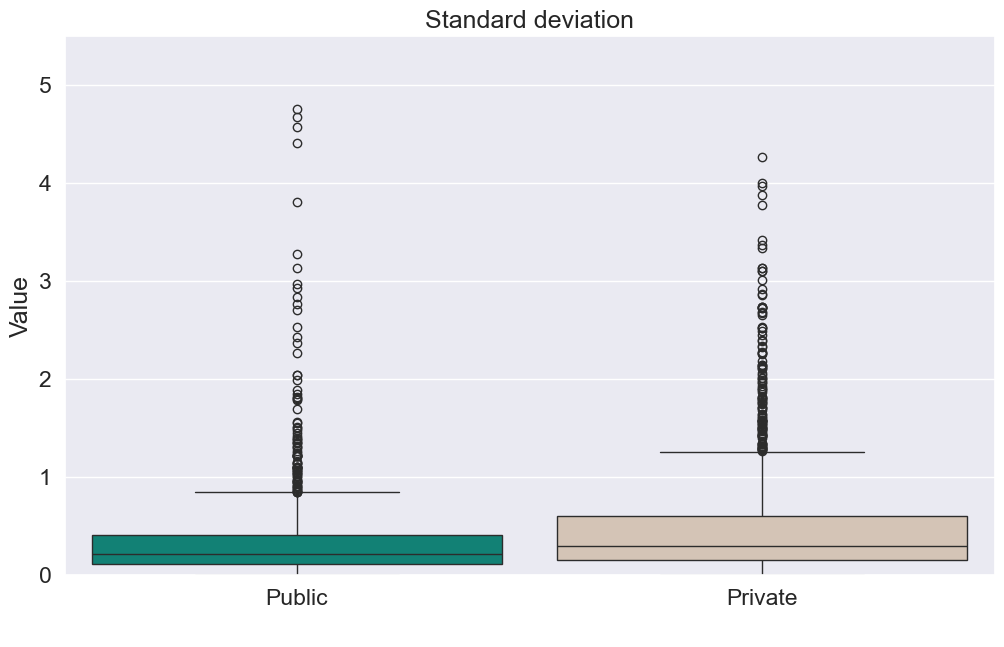

In [17]:
# Standard deviation
sns.set_theme()
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(12,7))
data = {
' ': [f'Public']*len(calc_ddgs_error)+[f'Private']*len(calc_ddgs_error_private),
'Value': calc_ddgs_error + calc_ddgs_error_private,
}
df_score = pd.DataFrame(data)
ax = sns.boxplot(x=' ', y='Value', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666'))
plt.title('Standard deviation')
plt.ylim(0,5.5)
plt.savefig('boxplot_standard_deviation.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_95638/1360253141.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=' ', y='Value', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666'))


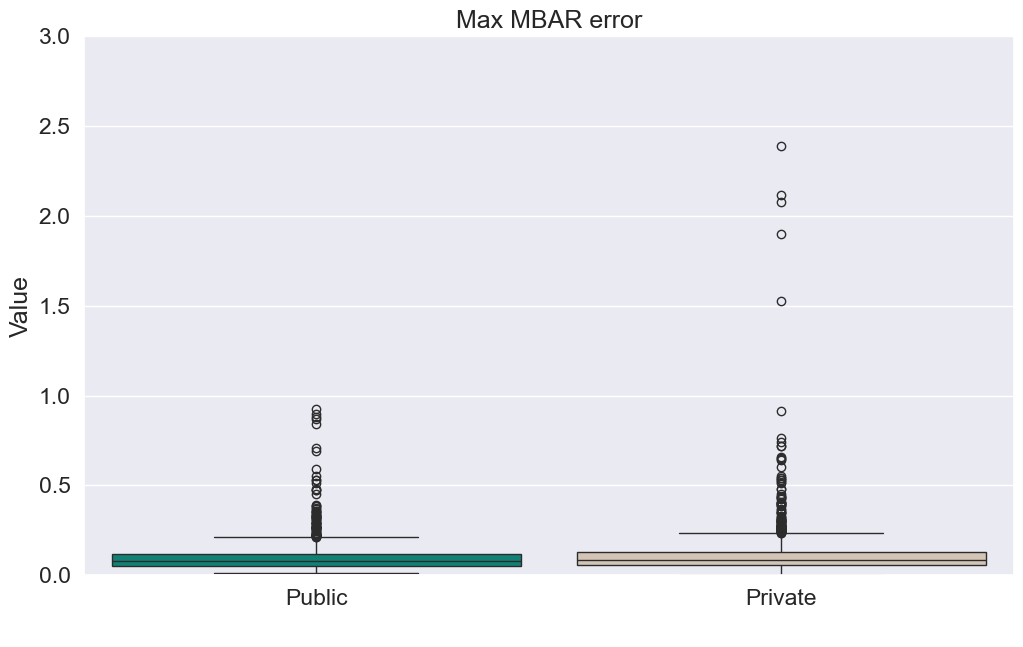

In [18]:
sns.set_theme()
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(12,7))
data = {
' ': [f'Public']*len(max_mbar)+ [f'Private']*len(max_mbar_private),
'Value': max_mbar.tolist() + max_mbar_private.tolist(),
}
df_score = pd.DataFrame(data)
ax = sns.boxplot(x=' ', y='Value', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666'))
plt.ylim(0,3)
plt.title('Max MBAR error')
plt.savefig('boxplot_mbar_error.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_95638/1672112486.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=' ', y='Value', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666'))


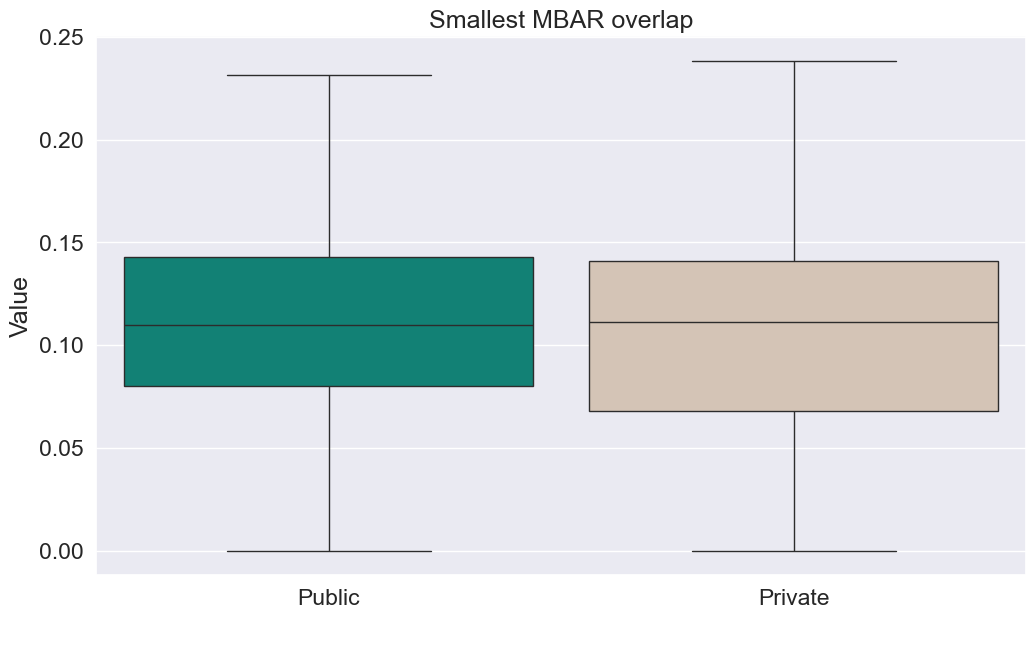

In [19]:
sns.set_theme()
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(12,7))
data = {
' ': [f'Public']*len(calc_ddgs_error) + [f'Private']*len(smallest_overlap_private),
'Value': smallest_overlap.tolist() + smallest_overlap_private.tolist(),
}
df_score = pd.DataFrame(data)
ax = sns.boxplot(x=' ', y='Value', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666'))
plt.title('Smallest MBAR overlap')
plt.savefig('boxplot_mbar_overlap.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(12,7))
data = {
' ': [f'Public']*len(calc_ddgs_error) + [f'Private']*len(smallest_overlap_private),
'Value': smallest_overlap.tolist() + smallest_overlap_private.tolist(),
}
df_score = pd.DataFrame(data)
ax = sns.boxplot(x=' ', y='Value', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666'))
plt.title('Smallest MBAR overlap')
plt.savefig('boxplot_mbar_overlap.png', dpi=300, bbox_inches='tight')
plt.show()

# Investigate Converged and unconverged edges

## Public

In [20]:
def converged_unconverged(data_metric, data_diff_calc_exp, threshold, direction='greater'):
    unconverged = []
    converged = []
    for inx, ov in enumerate(data_metric):
        diff_comp_exp = abs(data_diff_calc_exp[inx])
        if direction == 'greater':
            if ov > threshold:
                unconverged.append(diff_comp_exp)
            else:
                converged.append(diff_comp_exp) 
        if direction == 'smaller':
            if ov < threshold:
                unconverged.append(diff_comp_exp)
            else:
                converged.append(diff_comp_exp) 
    return converged, unconverged

In [21]:
# MBAR overlap
converged_mbar_ov, unconverged_mbar_ov = converged_unconverged(smallest_overlap, diff_calc_exp, threshold_mbar_overlap, direction='smaller')

In [22]:
# Standard deviation
converged_std, unconverged_std = converged_unconverged(calc_ddgs_error, diff_calc_exp, threshold_std)

In [23]:
# MBAR error
converged_mbar_error, unconverged_mbar_error = converged_unconverged(max_mbar, diff_calc_exp, threshold_mbar_error)

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/93317791.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=' ', y='Absolute error [kcal/mol]', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666', '#d9c4b1', '#666666', '#d9c4b1', '#666666'))


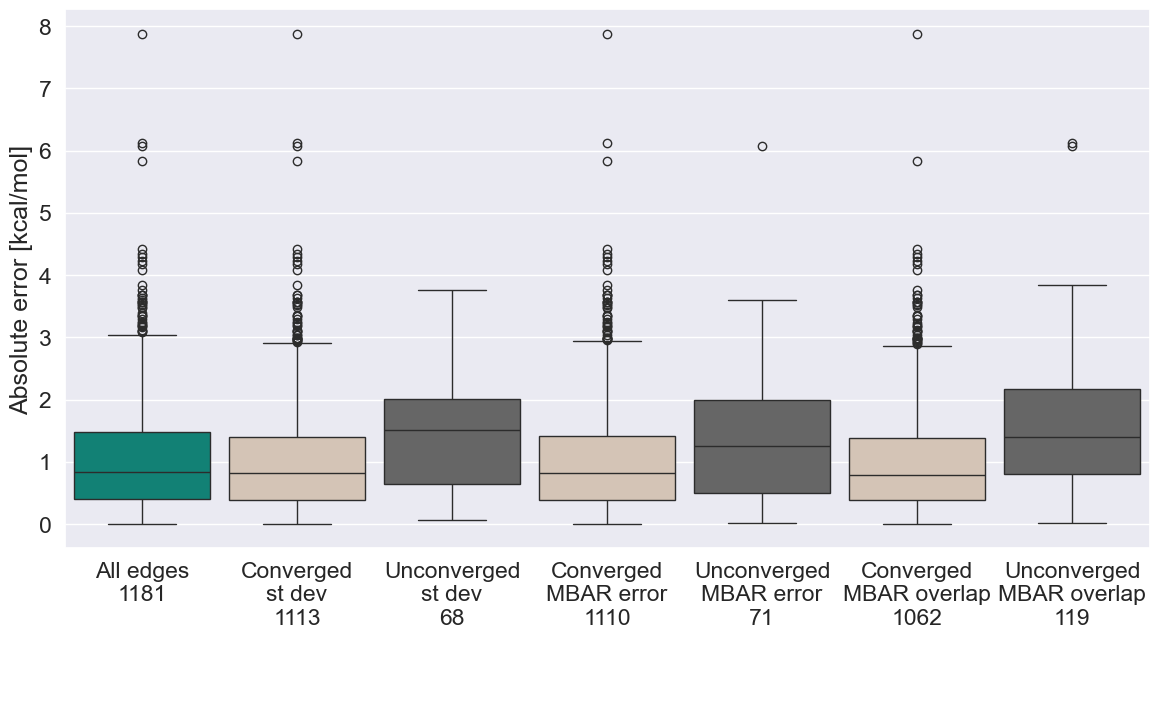

In [24]:
sns.set_theme()
sns.set(font_scale=1.5)
unconverged = [unconverged_std, unconverged_mbar_error, unconverged_mbar_ov]
converged = [converged_std, converged_mbar_error, converged_mbar_ov]
all_data = {}
fig, ax = plt.subplots(figsize=(14,7))
data = {
' ': [f'All edges\n{len(diff_calc_exp)}\n\n\n']*len(diff_calc_exp) +[f'Converged\nst dev\n{len(converged[0])}']*len(converged[0]) + [f'Unconverged\nst dev\n{len(unconverged[0])}']*len(unconverged[0])+[f'Converged\nMBAR error\n{len(converged[1])}']*len(converged[1]) + [f'Unconverged\nMBAR error\n{len(unconverged[1])}']*len(unconverged[1])+[f'Converged\nMBAR overlap\n{len(converged[2])}']*len(converged[2]) + [f'Unconverged\nMBAR overlap\n{len(unconverged[2])}']*len(unconverged[2]),
'Absolute error [kcal/mol]': [abs(i) for i in diff_calc_exp] +converged[0] + unconverged[0]+converged[1] + unconverged[1]+converged[2] + unconverged[2],
}
df_score = pd.DataFrame(data)
sns.boxplot(x=' ', y='Absolute error [kcal/mol]', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666', '#d9c4b1', '#666666', '#d9c4b1', '#666666'))
plt.savefig('converged_unconverged_public.png', dpi=300, bbox_inches='tight')
plt.show()

## Private

In [25]:
# MBAR overlap
converged_mbar_ov_private, unconverged_mbar_ov_private = converged_unconverged(smallest_overlap_private, diff_calc_exp_private, threshold_mbar_overlap, direction='smaller')

# Standard deviation
converged_std_private, unconverged_std_private = converged_unconverged(calc_ddgs_error_private, diff_calc_exp_private, threshold_std)

# MBAR error
converged_mbar_error_private, unconverged_mbar_error_private = converged_unconverged(max_mbar_private, diff_calc_exp_private, threshold_mbar_error)

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/460900275.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=' ', y='Absolute error [kcal/mol]', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666', '#d9c4b1', '#666666', '#d9c4b1', '#666666'))


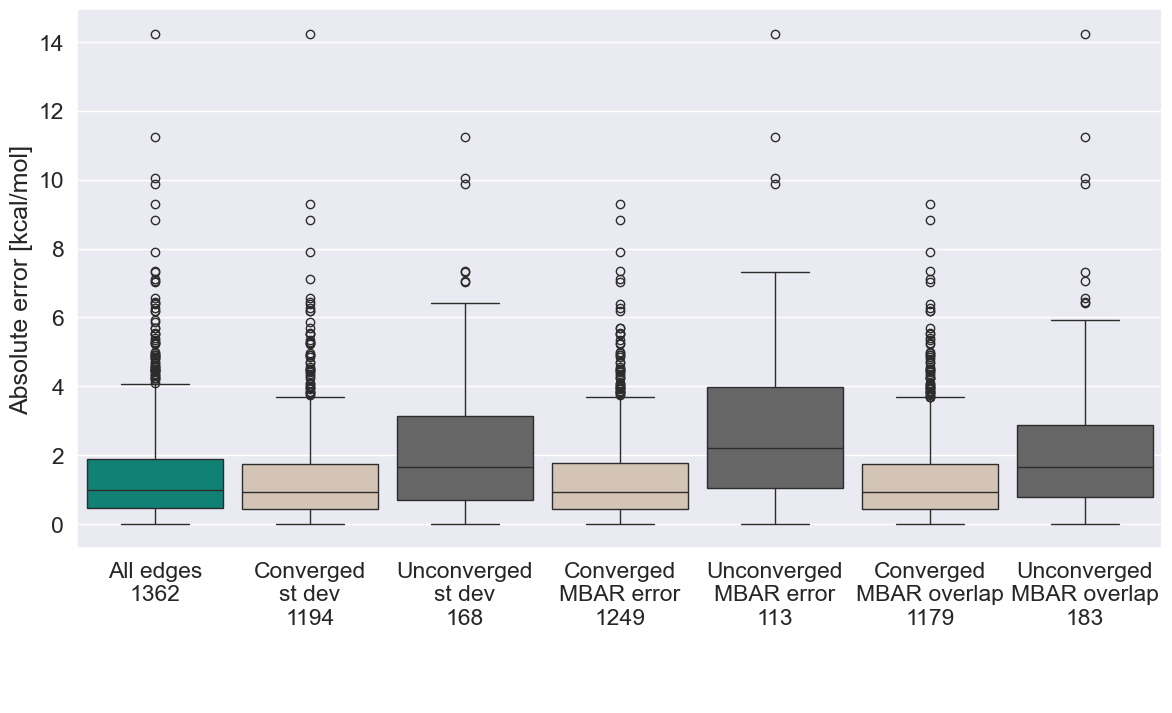

In [26]:
sns.set_theme()
sns.set(font_scale=1.5)
unconverged_private = [unconverged_std_private, unconverged_mbar_error_private, unconverged_mbar_ov_private]
converged_private = [converged_std_private, converged_mbar_error_private, converged_mbar_ov_private]
all_data = {}
fig, ax = plt.subplots(figsize=(14,7))
data = {
' ': [f'All edges\n{len(diff_calc_exp_private)}\n\n\n']*len(diff_calc_exp_private) +[f'Converged\nst dev\n{len(converged_private[0])}']*len(converged_private[0]) + [f'Unconverged\nst dev\n{len(unconverged_private[0])}']*len(unconverged_private[0])+[f'Converged\nMBAR error\n{len(converged_private[1])}']*len(converged_private[1]) + [f'Unconverged\nMBAR error\n{len(unconverged_private[1])}']*len(unconverged_private[1])+[f'Converged\nMBAR overlap\n{len(converged_private[2])}']*len(converged_private[2]) + [f'Unconverged\nMBAR overlap\n{len(unconverged_private[2])}']*len(unconverged_private[2]),
'Absolute error [kcal/mol]': [abs(i) for i in diff_calc_exp_private] +converged_private[0] + unconverged_private[0]+converged_private[1] + unconverged_private[1]+converged_private[2] + unconverged_private[2],
}
df_score = pd.DataFrame(data)
sns.boxplot(x=' ', y='Absolute error [kcal/mol]', data=df_score, gap=-0.1,palette=('#009384', '#d9c4b1', '#666666', '#d9c4b1', '#666666', '#d9c4b1', '#666666'))
plt.savefig('converged_unconverged_private.png', dpi=300, bbox_inches='tight')
plt.show()

## Remove unconverged edges

In [27]:
from cinnabar import FEMap
import networkx as nx
from itertools import combinations
import copy

def remove_edges_from_network(df: pd.DataFrame, bad_edges: list[tuple[str, str]]) -> pd.DataFrame:
    """
    Given the DataFrame of DDGs try and remove the list of edges and check that the network is still connected.

    Try and find the maximum number of edges which can be removed without breaking the network.

    Args:
        df: pd.DataFrame 
            The raw DDG values for a particular system
        bad_edges: list[tuple(str, str, float)]
            A list of tuples of ligand names representing edges which should be removed from the network and a penalty to determine how bad the edge is by some metric.
    Returns:
        The absoluate DG dataframe estimated with MLE and the list of edges removed from the network
    """
    graph = nx.MultiGraph()
    for _, row in df.iterrows():
        graph.add_edge(row["ligand_A"], row["ligand_B"])
    
    # try and remove all possible combinations of bad edges till we get a fully connected graph
    # start from the largest subset and exit early
    removeable_subsets = []
    for be in bad_edges:
        temp_graph = copy.deepcopy(graph)
        temp_graph.remove_edge(be[0], be[1])
        # check we are still connected
        if nx.is_connected(temp_graph):
            graph = temp_graph
            removeable_subsets.append(be)
    new_fe_map = FEMap()
    for _, row in df.iterrows():
        if (row["ligand_A"], row["ligand_B"]) not in graph.edges:
            continue
        complex_data = [row[f"complex_repeat_{i}_DG (kcal/mol)"] for i in range(3)]
        complex_dg = np.mean(complex_data)
        complex_error = np.std(complex_data)
        solvent_data = [row[f"solvent_repeat_{i}_DG (kcal/mol)"] for i in range(3)]
        solvent_dg = np.mean(solvent_data)
        solvent_error = np.std(solvent_data)
        ddg = complex_dg - solvent_dg
        # propagate errors
        ddg_error = (complex_error ** 2 + solvent_error ** 2) ** 0.5
        new_fe_map.add_relative_calculation(
            labelA=row["ligand_A"],
            labelB=row["ligand_B"],
            value=ddg,
            uncertainty=ddg_error,
        )
    new_fe_map.generate_absolute_values()
    return new_fe_map.get_absolute_dataframe(), new_fe_map.get_relative_dataframe(), len(removeable_subsets)

In [28]:
def stat_plot_removed_edges(df_new, df_t_dg, edges_gone, fname):
    
    if df_new is not None and edges_gone > 0:
        exp_dg = [df_t_dg[df_t_dg['ligand name'] == e]['Exp DG (kcal/mol)'].item() for e in df_new['label']]
        exp_ddg = [df_t_dg[df_t_dg['ligand name'] == e]['Exp dDG (kcal/mol)'].item() for e in df_new['label']]
        calc_dg = df_new['DG (kcal/mol)']
        calc_ddg = df_new['uncertainty (kcal/mol)']
        shift = sum(exp_dg) / len(exp_dg)
        # centralising
        # this should be replaced by providing one experimental result
        x_data = exp_dg - np.mean(exp_dg) + shift
        y_data = calc_dg - np.mean(calc_dg) + shift

        # Calculate the dynamic range of the dataset
        dynamic_range = abs(max(exp_dg) - min(exp_dg))
        # Only get correlation stats if at least 16 ligands, dynamic range of 3
        if len(df_new) >= 16 and dynamic_range >= 3:
            stats_out = _get_statistics(
                x_data, 
                y_data, 
                exp_ddg, 
                calc_ddg,
                statistics=["RMSE", "MUE", "R2", "KTAU"],
            )
        else:
            stats_out = _get_statistics(
                x_data, 
                y_data, 
                exp_ddg, 
                calc_ddg,
                statistics=["RMSE", "MUE"],
            )        
        return stats_out
    else: 
        return {}

In [29]:
def assemble_stats(stats_full, stats_removed, statistic):
    stat_items = []
    stat_items_full = []
    for group, data in stats_removed.items():
        if data:
            systems = list(data.keys())
            reordered_stats_full_group = {k: stats_full[group][k] for k in systems}
            df_r = pd.DataFrame(data=data.values(), index=systems)
            df_fep = pd.DataFrame(data=reordered_stats_full_group.values(), index=systems)
            labels = systems.copy()
            if statistic in df_r.columns and statistic in df_fep.columns:
                clean_df = df_r[statistic].dropna()
                clean_df_fep = df_fep[statistic].dropna()
                clean_df_fep = df_fep[statistic][df_fep[statistic].index.isin(clean_df.index)]
                low = df_r[f'{statistic}_low'].dropna()
                high = df_r[f'{statistic}_high'].dropna()
                low_fep = df_fep[f'{statistic}_low'][df_fep[statistic].index.isin(low.index)]
                high_fep = df_fep[f'{statistic}_high'][df_fep[statistic].index.isin(high.index)]
                for inx,r in enumerate(clean_df):
                    stat_items.append([r,low[inx], high[inx], group,clean_df.index[inx], df_r['removed'][inx]])
                for inx,r in enumerate(clean_df_fep):
                    stat_items_full.append([r,low_fep[inx], high_fep[inx], group,clean_df_fep.index[inx]])    
            else:
                continue
        else:
            continue
    return stat_items, stat_items_full

In [30]:
def plot_stats_removed_edges(stat_items, stat_items_full, statistic, title, fname):
    length = len(stat_items)
    x = np.arange(length)
    # Set up the figure
    fig, ax = plt.subplots(figsize=(16, 8))
    bar_width = 0.4

    ax.bar(x - bar_width/2, [r[0] for r in stat_items], yerr=([r[1] for r in stat_items], [r[2] for r in stat_items]), width=bar_width, label='Bad removed',
       color='#009384', capsize=3)
    ax.bar(x + bar_width/2, [r[0] for r in stat_items_full], yerr=([r[1] for r in stat_items_full], [r[2] for r in stat_items_full]), width=bar_width, label='Full',
       color='#d9c4b1', capsize=3)

    # Set labels and ticks
    ax.set_xticks(x)
    names = [f'{r[3]}\n{r[4]}\n{r[-1]}' for r in stat_items]
    ax.set_xticklabels(names, rotation=90, fontsize=14)
    ax.set_ylabel(statistic)
    ax.legend()

    plt.tight_layout()
    plt.xlim(-0.5, len(stat_items) - 0.5)
    plt.title(title)
    plt.savefig(fname, dpi=300, bbox_inches='tight')

In [31]:
def remove_unconverged_edges(edge_data, dg_data, metric, threshold, direction='greater'):
    stats_removed = {}
    for s in edge_data['system group'].unique():
        df_s = edge_data[edge_data['system group'] == s]
        df_s_dg = dg_data[dg_data['system group'] == s]
        stats_dict = {}
        for t in df_s['system name'].unique():
            df_t_dg = df_s_dg[df_s_dg['system name'] == t]
            df_t = df_s[df_s['system name'] == t]
            overall_metric = [metric[inx] for inx in df_t.index]
            df_t.reset_index(inplace=True, drop=True)
            df_t_dg.reset_index(inplace=True, drop=True)
            bad_edges = []
            
            for inx, i in enumerate(overall_metric):
                if direction == 'greater':
                    if i > threshold:
                        bad_edges.append([df_t['ligand_A'][inx], df_t['ligand_B'][inx], i])
                if direction == 'smaller':
                    if i < threshold:
                        bad_edges.append([df_t['ligand_A'][inx], df_t['ligand_B'][inx], i])
            bad_edges = sorted(bad_edges, key=lambda x: x[2], reverse=True)
            if bad_edges:
                try:
                    df_new, ddg_df_new, edges_gone = remove_edges_from_network(df_t, bad_edges)
                except (np.linalg.LinAlgError, ValueError):
                    continue
                stats_out = stat_plot_removed_edges(df_new, df_t_dg, edges_gone, f'{s}_{t}_remove_bad_std')
                stats_out['removed'] = f'{edges_gone}/{len(df_t)}'
                stats_dict[t] = stats_out 
        stats_removed[s] = stats_dict
    return stats_removed

In [32]:
stats_full = {}
for s in public_dg_data['system group'].unique():
    df_s = public_dg_data[public_dg_data['system group'] == s]
    df_s.reset_index(inplace=True, drop=True)
    stats_dict = {}
    for t in df_s['system name'].unique():
        df_t = df_s[df_s['system name'] == t]
        df_t.reset_index(inplace=True, drop=True)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Calculate the dynamic range of the dataset
            dynamic_range = abs(max(df_t['Exp DG (kcal/mol)']) - min(df_t['Exp DG (kcal/mol)']))
            # Only get correlation stats if at least 16 ligands, dynamic range of 3
            if len(df_t) >= 16 and dynamic_range >= 3:
                stats_out = _get_statistics(
                    df_t['Exp DG (kcal/mol)'], 
                    df_t['DG (kcal/mol)'], 
                    df_t['Exp dDG (kcal/mol)'], 
                    df_t['uncertainty (kcal/mol)'],
                    statistics=["RMSE", "MUE", "R2", "rho", "KTAU"],
                )
                
            else:
                stats_out = _get_statistics(
                    df_t['Exp DG (kcal/mol)'], 
                    df_t['DG (kcal/mol)'], 
                    df_t['Exp dDG (kcal/mol)'], 
                    df_t['uncertainty (kcal/mol)'],
                    statistics=["RMSE", "MUE"],
                )
            stats_dict[t] = stats_out 
    stats_full[s] = stats_dict

In [33]:
stats_full_private = {}
for s in private_dg_data['system group'].unique():
    df_s = private_dg_data[private_dg_data['system group'] == s]
    df_s.reset_index(inplace=True, drop=True)
    stats_dict = {}
    for t in df_s['system name'].unique():
        df_t = df_s[df_s['system name'] == t]
        df_t.reset_index(inplace=True, drop=True)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Calculate the dynamic range of the dataset
            dynamic_range = abs(max(df_t['Exp DG (kcal/mol)']) - min(df_t['Exp DG (kcal/mol)']))
            # Only get correlation stats if at least 16 ligands, dynamic range of 3
            if len(df_t) >= 16 and dynamic_range >= 3:
                stats_out = _get_statistics(
                    df_t['Exp DG (kcal/mol)'], 
                    df_t['DG (kcal/mol)'], 
                    df_t['Exp dDG (kcal/mol)'], 
                    df_t['uncertainty (kcal/mol)'],
                    statistics=["RMSE", "MUE", "R2", "rho", "KTAU"],
                )
                
            else:
                stats_out = _get_statistics(
                    df_t['Exp DG (kcal/mol)'], 
                    df_t['DG (kcal/mol)'], 
                    df_t['Exp dDG (kcal/mol)'], 
                    df_t['uncertainty (kcal/mol)'],
                    statistics=["RMSE", "MUE"],
                )
            stats_dict[t] = stats_out 
    stats_full_private[s] = stats_dict

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items.append([r,low[inx], high[inx], group,clean_df.index[inx], df_r['removed'][inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items_full.append([r,low_fep[inx], high_fep[inx], group,clean_df_fep.index[inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

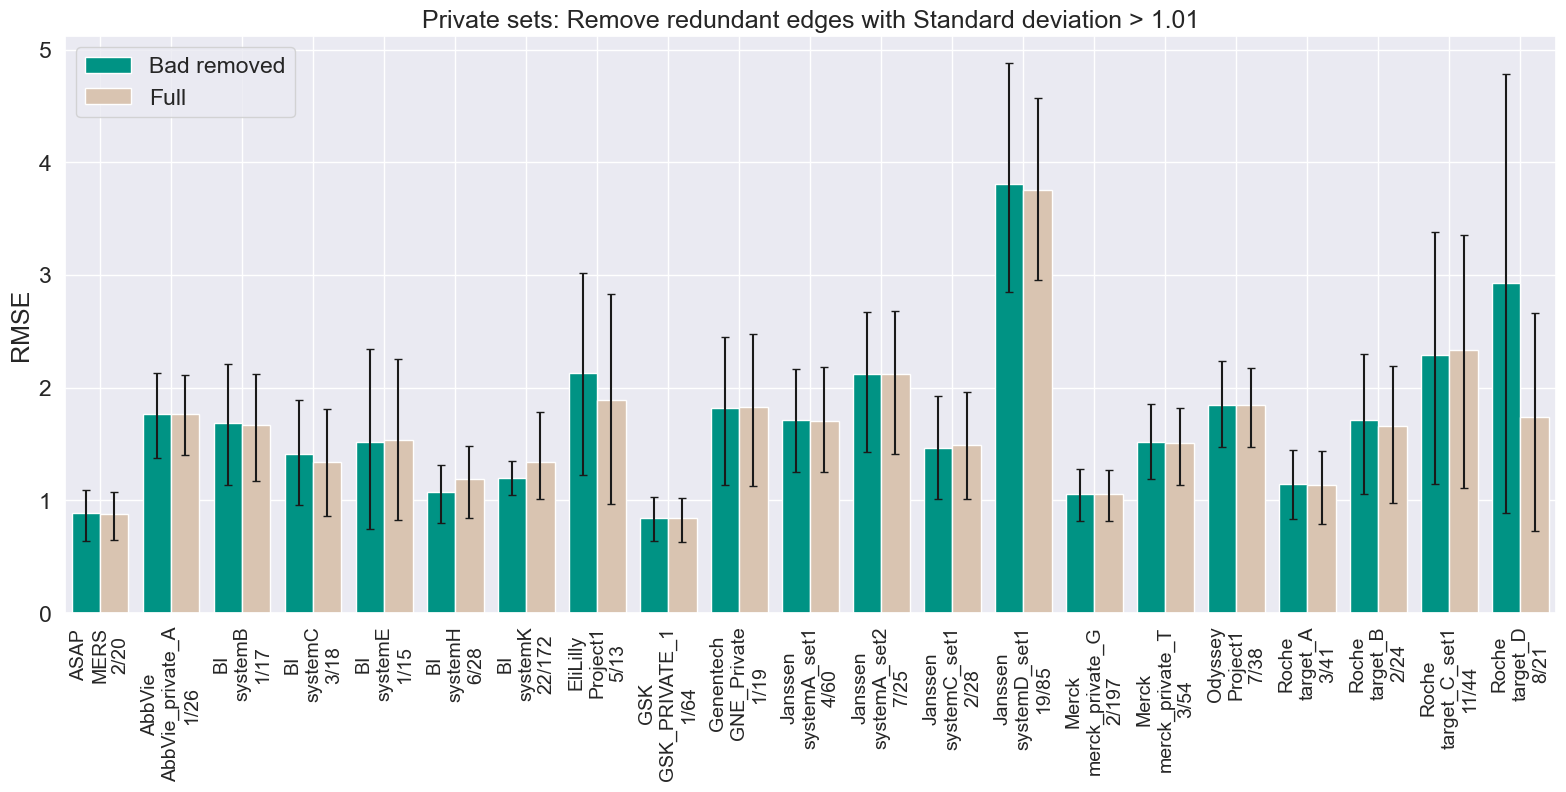

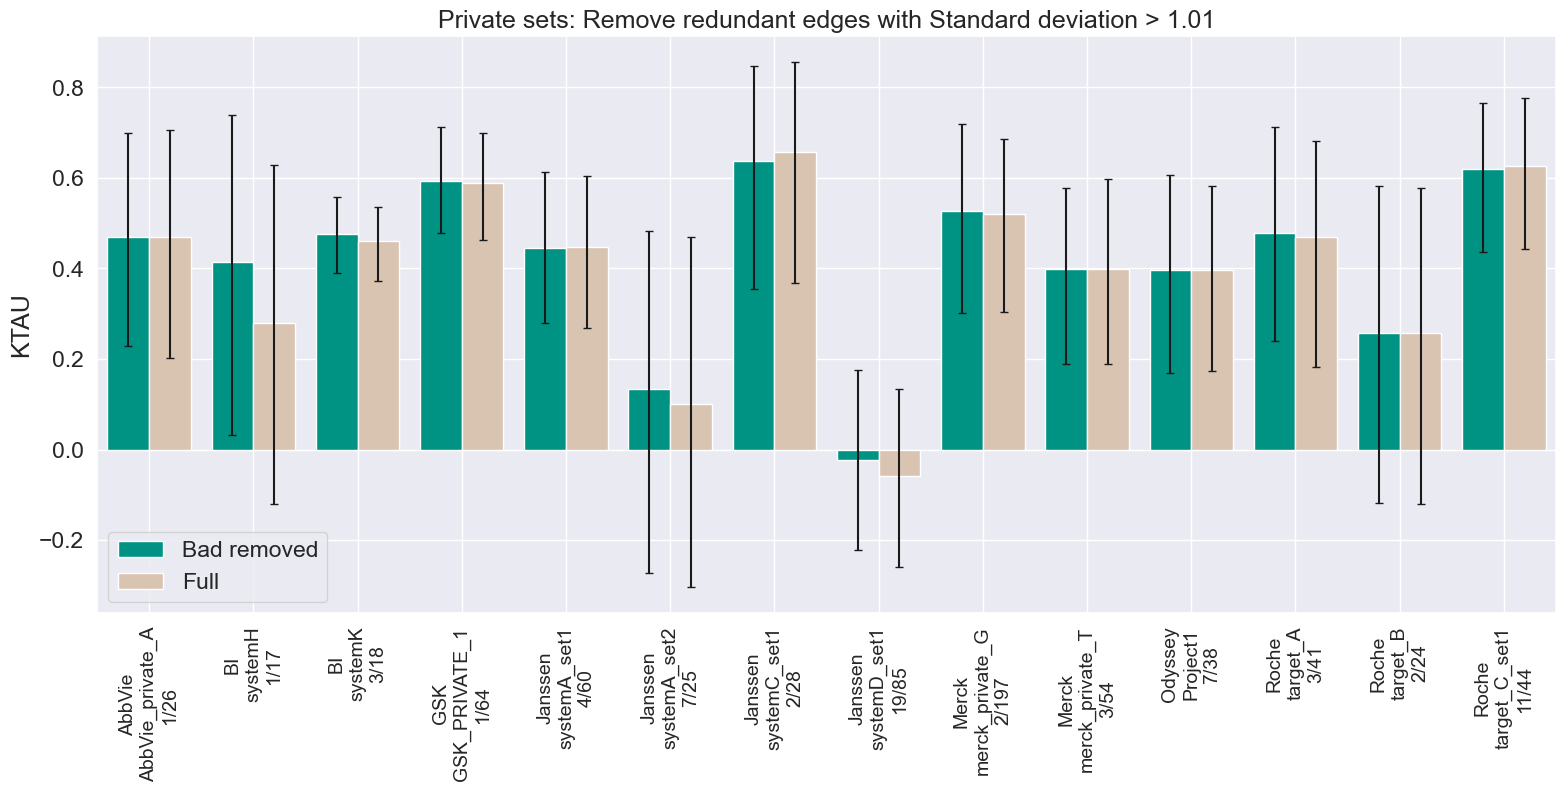

In [34]:
# Remove unconverged edges: Std private
protocol = f'Private sets: Remove redundant edges with Standard deviation > {threshold_std}'
stats_removed = remove_unconverged_edges(private_edge_data, private_dg_data, calc_ddgs_error_private, threshold_std, direction='greater')
statistics = ['RMSE', 'KTAU']
for statistic in statistics:
    stat_items, stat_items_full = assemble_stats(stats_full_private, stats_removed, statistic)
    plot_stats_removed_edges(stat_items, stat_items_full, statistic, protocol, f'bad_std_removed_private_{statistic}.png')

## High standard deviation

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items.append([r,low[inx], high[inx], group,clean_df.index[inx], df_r['removed'][inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items_full.append([r,low_fep[inx], high_fep[inx], group,clean_df_fep.index[inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

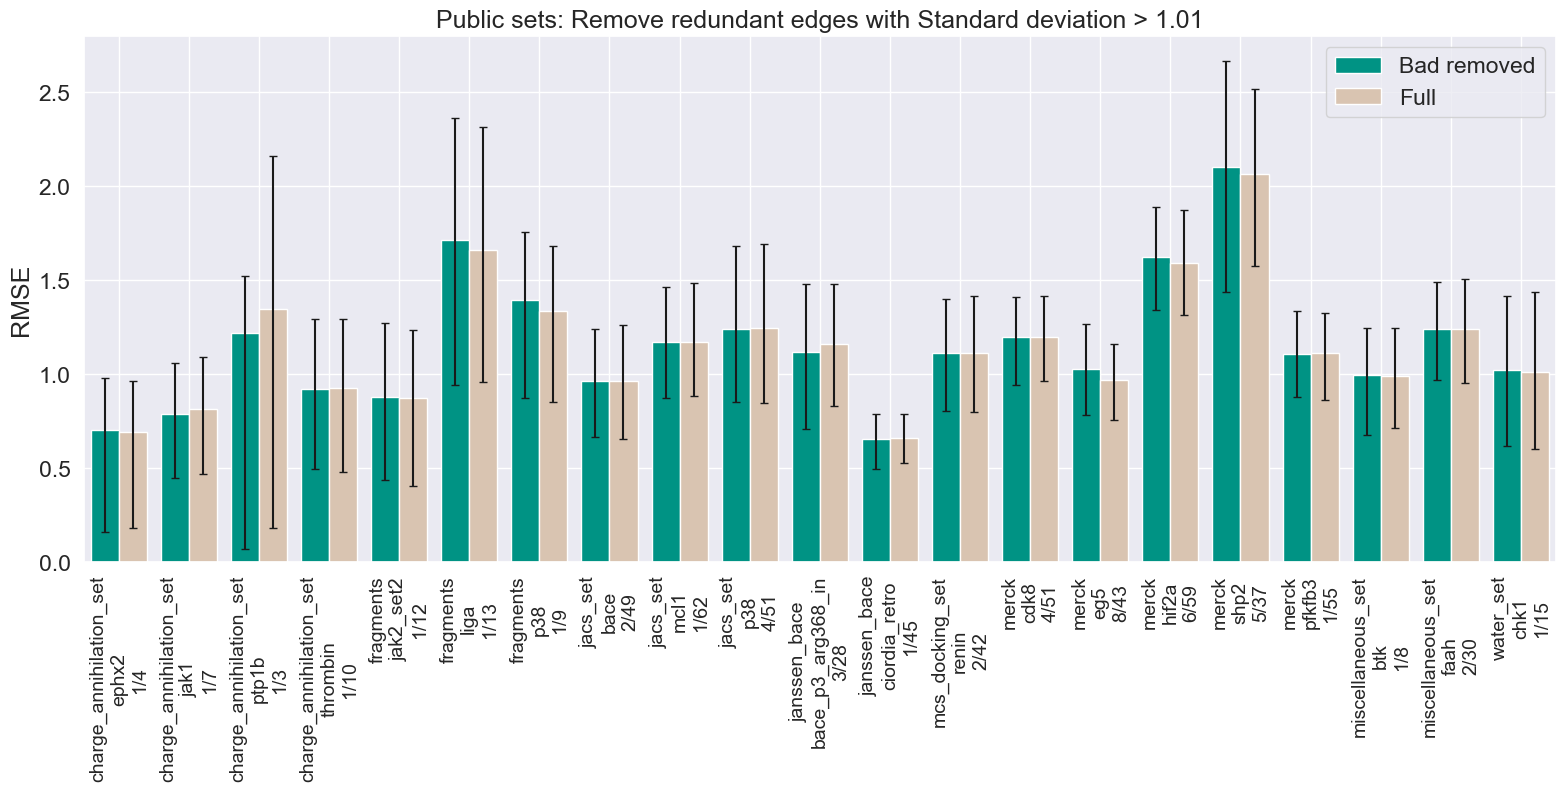

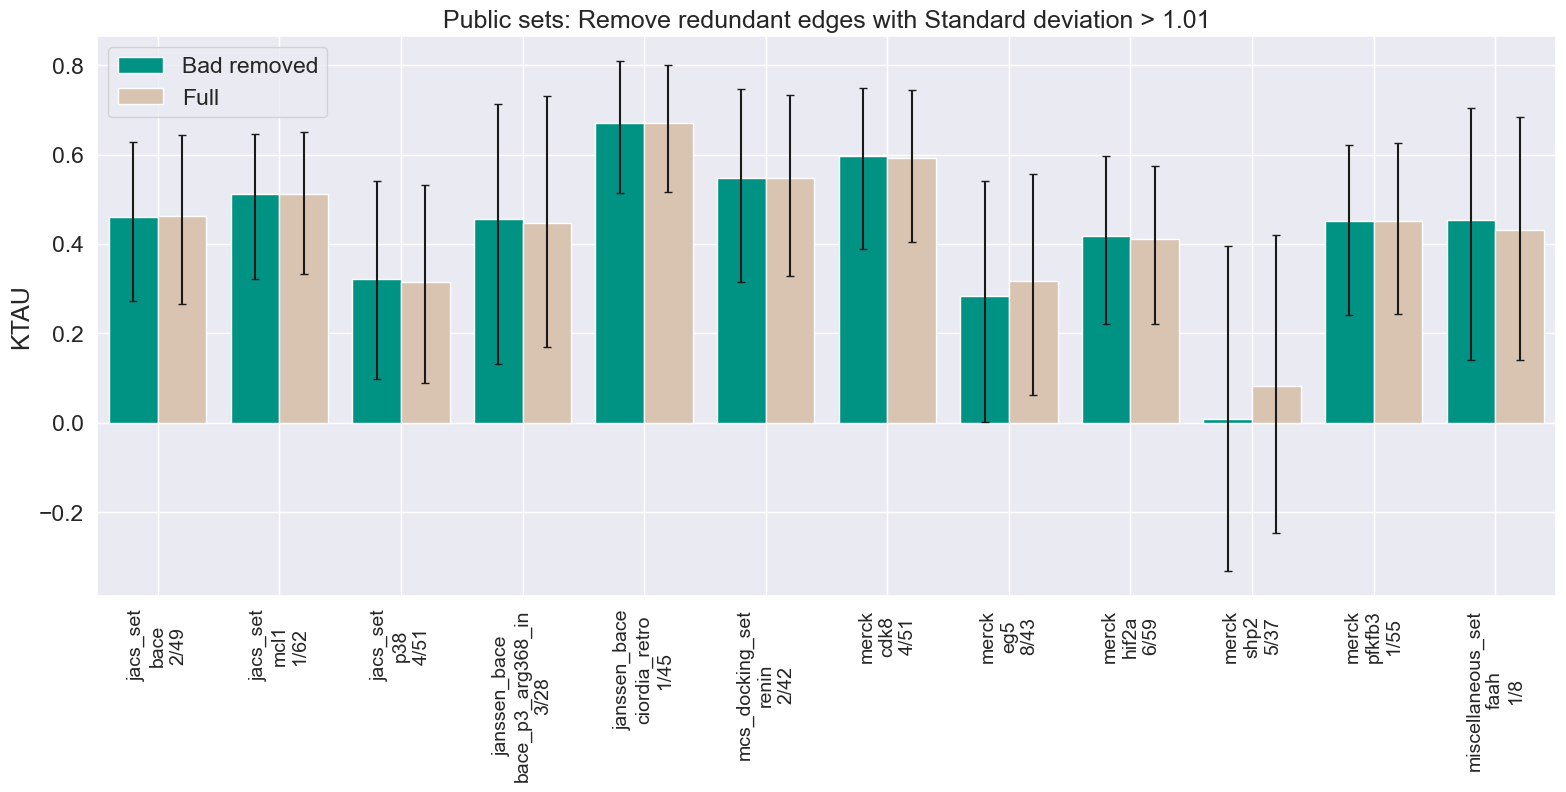

In [35]:
# Remove unconverged edges: Std
protocol = f'Public sets: Remove redundant edges with Standard deviation > {threshold_std}'
stats_removed = remove_unconverged_edges(public_edge_data, public_dg_data, calc_ddgs_error, threshold_std, direction='greater')
statistics = ['RMSE', 'KTAU']
for statistic in statistics:
    stat_items, stat_items_full = assemble_stats(stats_full, stats_removed, statistic)
    plot_stats_removed_edges(stat_items, stat_items_full, statistic, protocol, f'bad_std_removed_{statistic}.png')

## High MBAR error

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items.append([r,low[inx], high[inx], group,clean_df.index[inx], df_r['removed'][inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items_full.append([r,low_fep[inx], high_fep[inx], group,clean_df_fep.index[inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

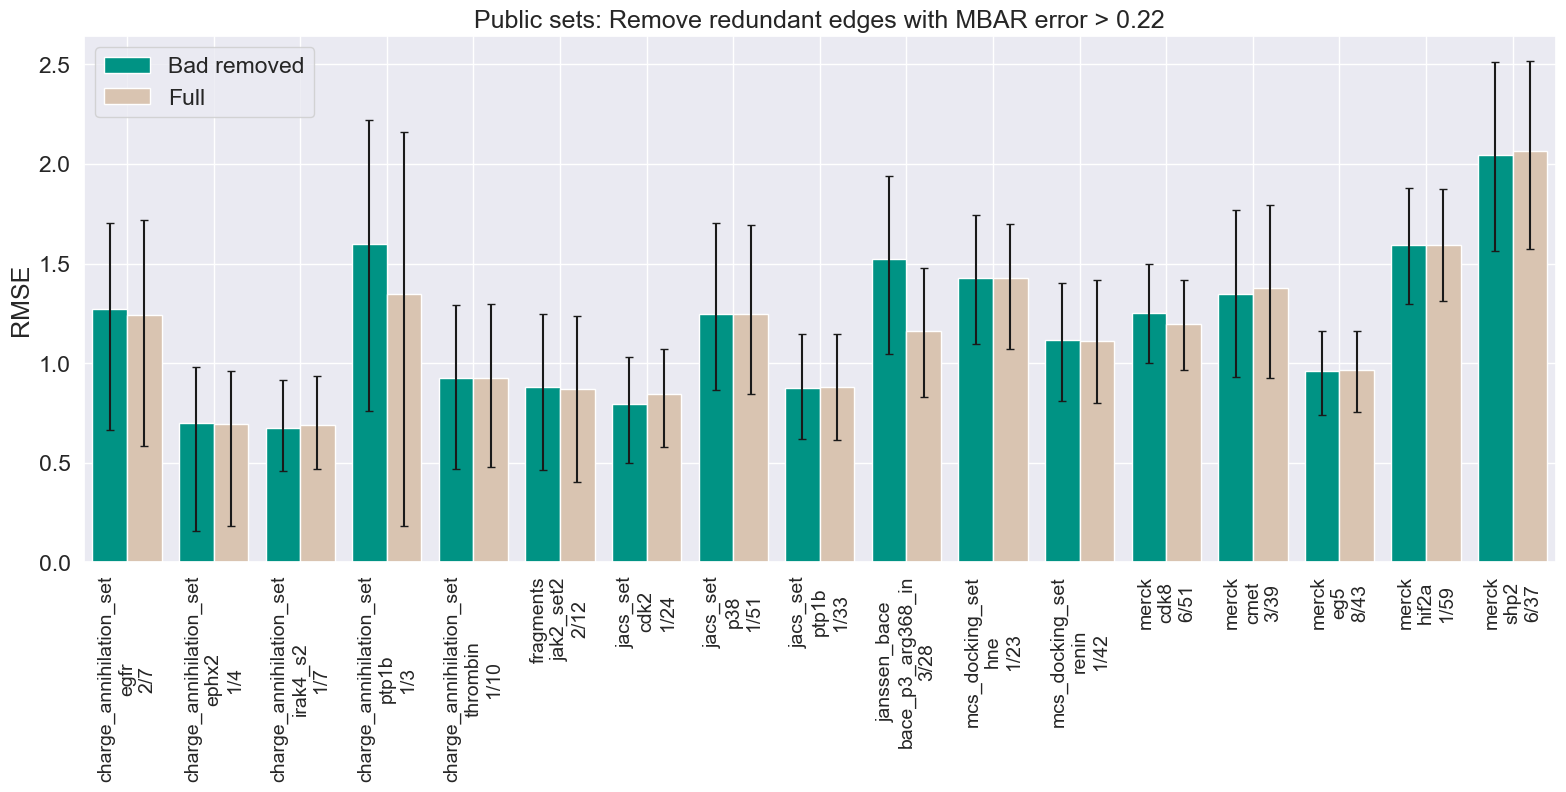

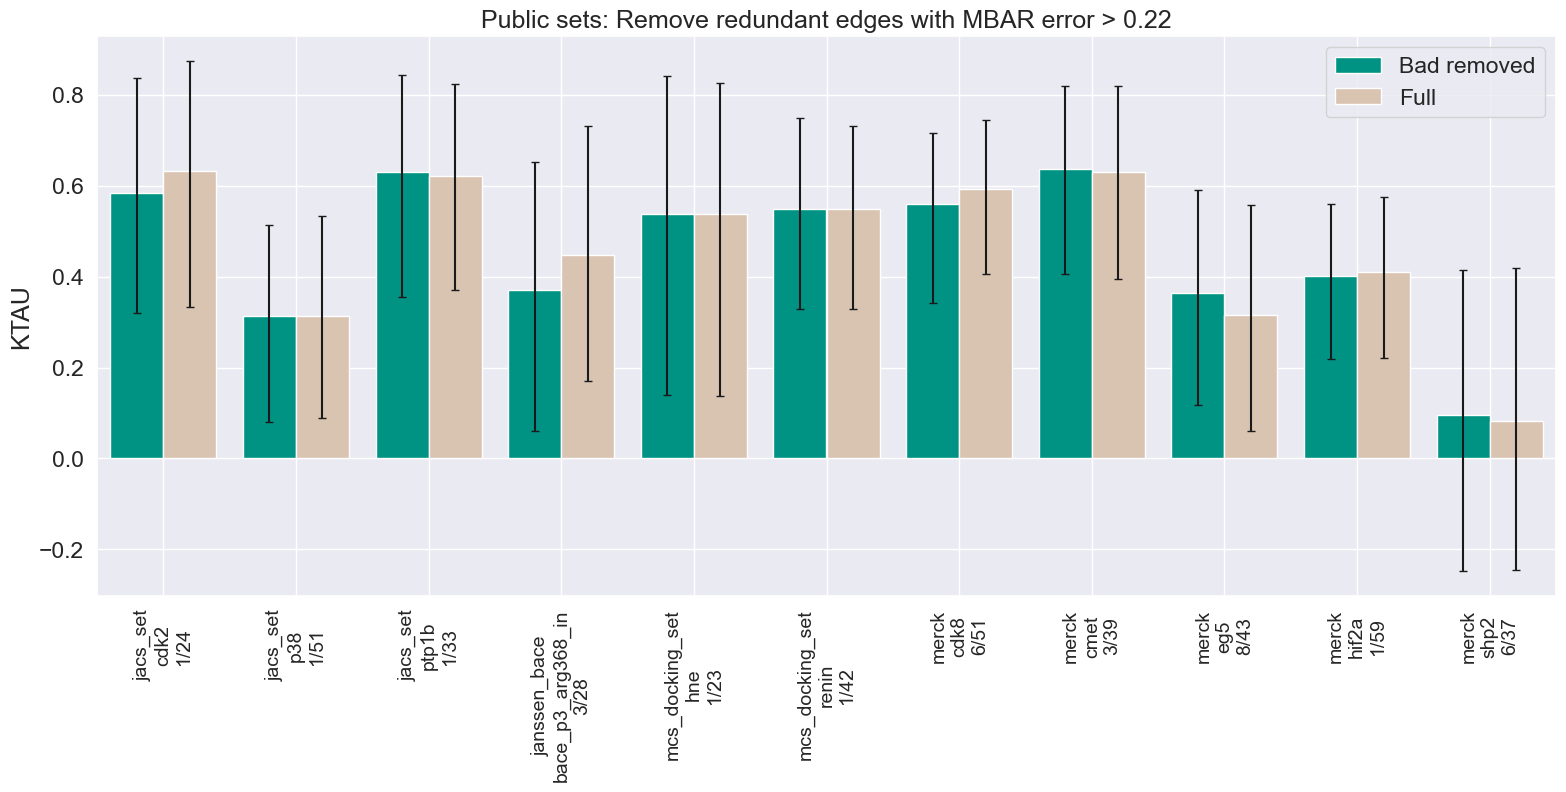

In [36]:
# Remove unconverged edges: MBAR error
protocol = f'Public sets: Remove redundant edges with MBAR error > {threshold_mbar_error}'
stats_removed = remove_unconverged_edges(public_edge_data, public_dg_data, max_mbar, threshold_mbar_error, direction='greater')
statistics = ['RMSE', 'KTAU']
for statistic in statistics:
    stat_items, stat_items_full = assemble_stats(stats_full, stats_removed, statistic)
    plot_stats_removed_edges(stat_items, stat_items_full, statistic, protocol, f'bad_MBAR_error_removed_{statistic}.png')

In [37]:
# Roche target D: The RMSE is much higher after removal of edges. 
# Ligand 10 is only connected to the other ligands by 2 edges. 
# Both edges have large MBAR error, very low Lomap score. Removing one made things worse here.

## Poor MBAR overlap

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items.append([r,low[inx], high[inx], group,clean_df.index[inx], df_r['removed'][inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items_full.append([r,low_fep[inx], high_fep[inx], group,clean_df_fep.index[inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

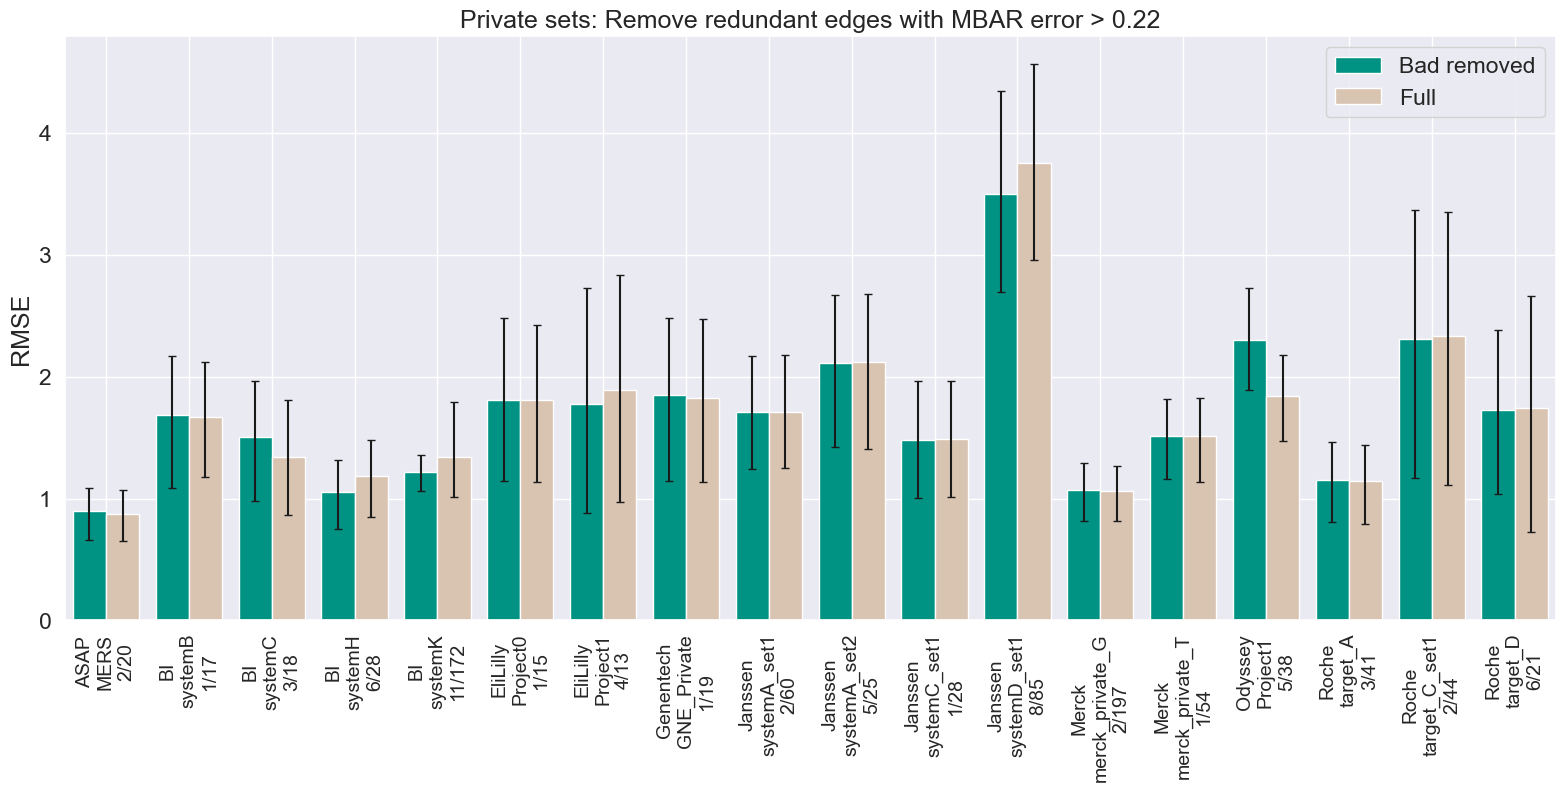

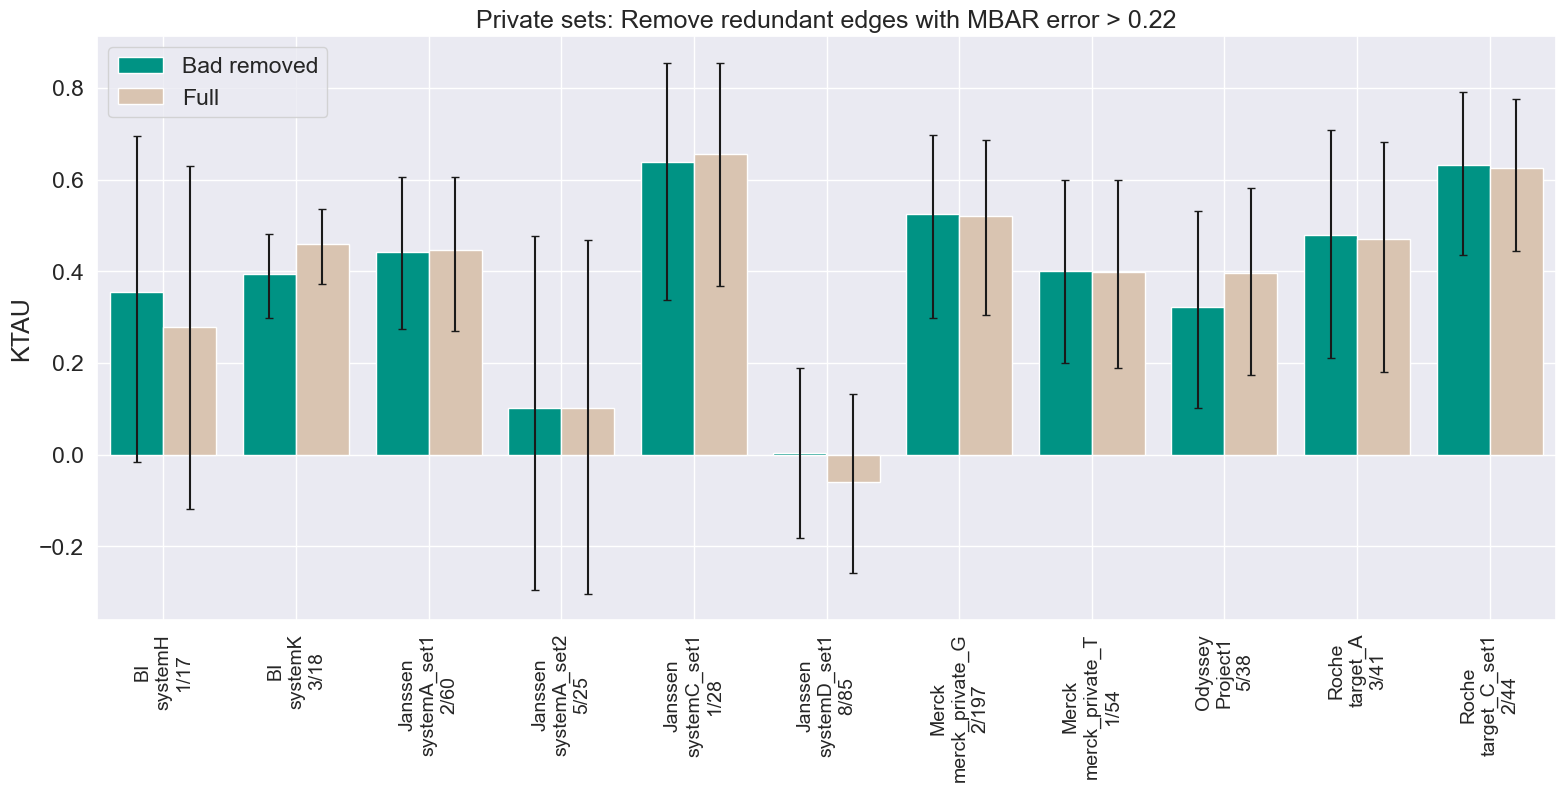

In [38]:
# Remove unconverged edges: MBAR error private
protocol = f'Private sets: Remove redundant edges with MBAR error > {threshold_mbar_error}'
stats_removed = remove_unconverged_edges(private_edge_data, private_dg_data, max_mbar_private, threshold_mbar_error, direction='greater')
statistics = ['RMSE', 'KTAU']
for statistic in statistics:
    stat_items, stat_items_full = assemble_stats(stats_full_private, stats_removed, statistic)
    plot_stats_removed_edges(stat_items, stat_items_full, statistic, protocol, f'bad_MBAR_error_removed_{statistic}_private.png')

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items.append([r,low[inx], high[inx], group,clean_df.index[inx], df_r['removed'][inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items_full.append([r,low_fep[inx], high_fep[inx], group,clean_df_fep.index[inx]])


[[1.1857878593436504, 0.49965096751347626, 0.3443761385347539, 'fragments', 'p38', '2/9'], [0.9636282370209186, 0.17879918036074127, 0.18809023359239951, 'jacs_set', 'p38', '3/51']]


/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items.append([r,low[inx], high[inx], group,clean_df.index[inx], df_r['removed'][inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items_full.append([r,low_fep[inx], high_fep[inx], group,clean_df_fep.index[inx]])


[[0.4542307433474361, 0.172530543597134, 0.1526172453326493, 'jacs_set', 'p38', '3/51']]


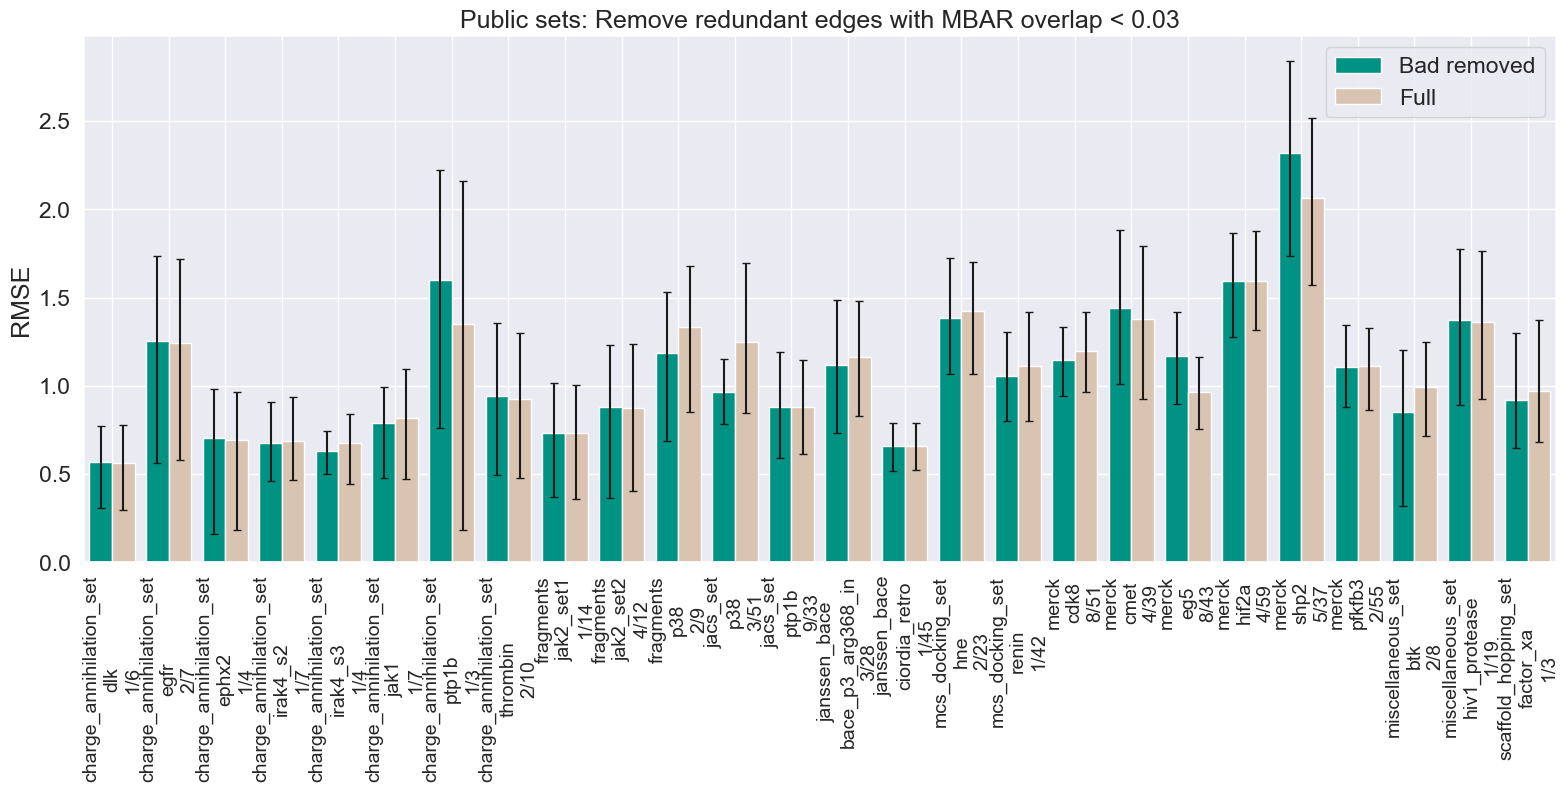

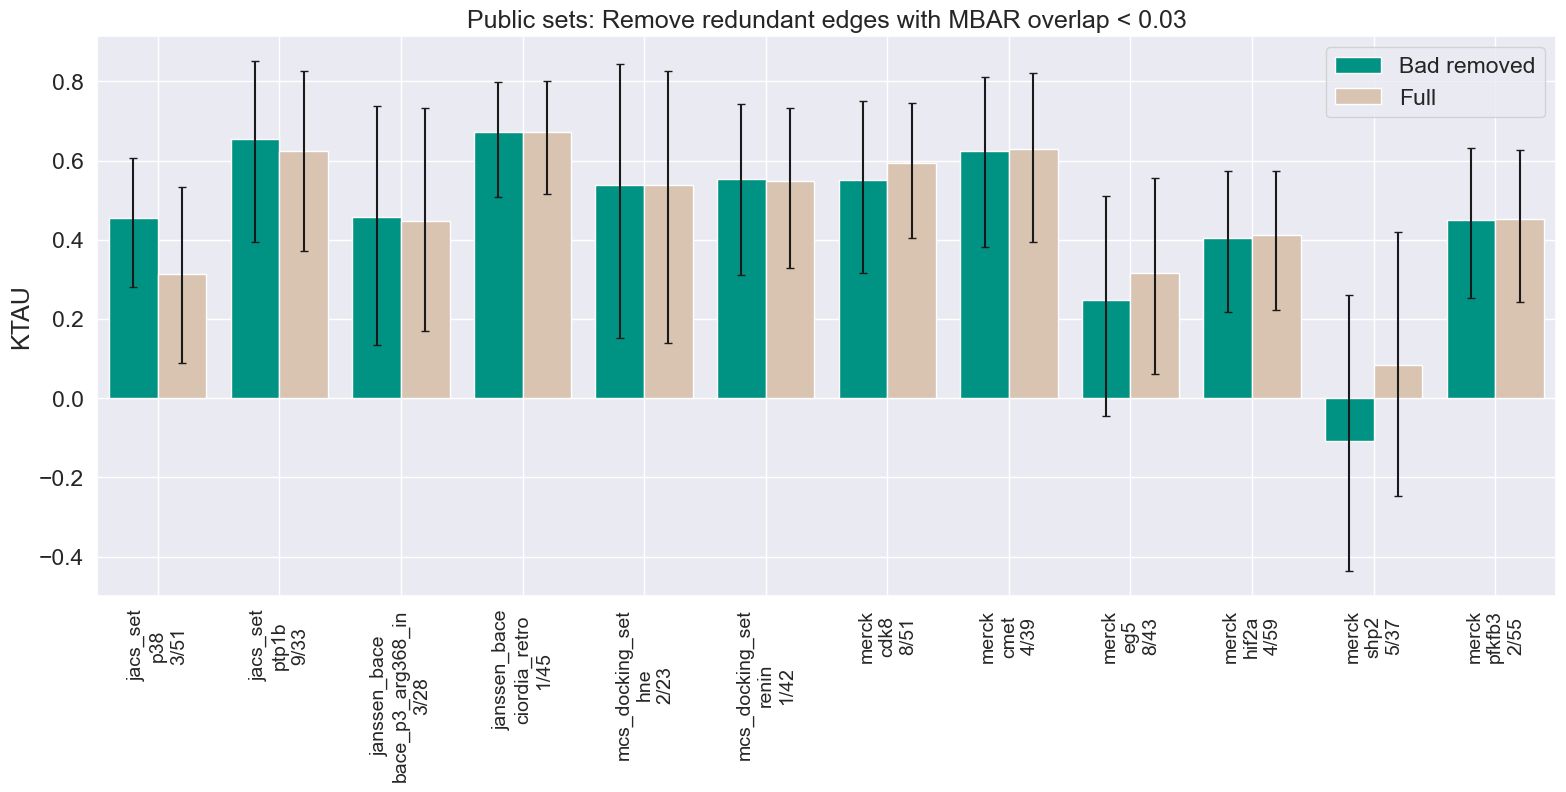

In [39]:
# Remove unconverged edges: Bad MBAR overlap
stats_removed = {}
protocol = f'Public sets: Remove redundant edges with MBAR overlap < {threshold_mbar_overlap}'
stats_removed = remove_unconverged_edges(public_edge_data, public_dg_data, smallest_overlap, threshold_mbar_overlap, direction='smaller')
statistics = ['RMSE', 'KTAU']
for statistic in statistics:
    stat_items, stat_items_full = assemble_stats(stats_full, stats_removed, statistic)
    print([s for s in stat_items if 'p38' in s])
    plot_stats_removed_edges(stat_items, stat_items_full, statistic, protocol, f'bad_overlap_removed_{statistic}.png')

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items.append([r,low[inx], high[inx], group,clean_df.index[inx], df_r['removed'][inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat_items_full.append([r,low_fep[inx], high_fep[inx], group,clean_df_fep.index[inx]])
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_43166/1826844295.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

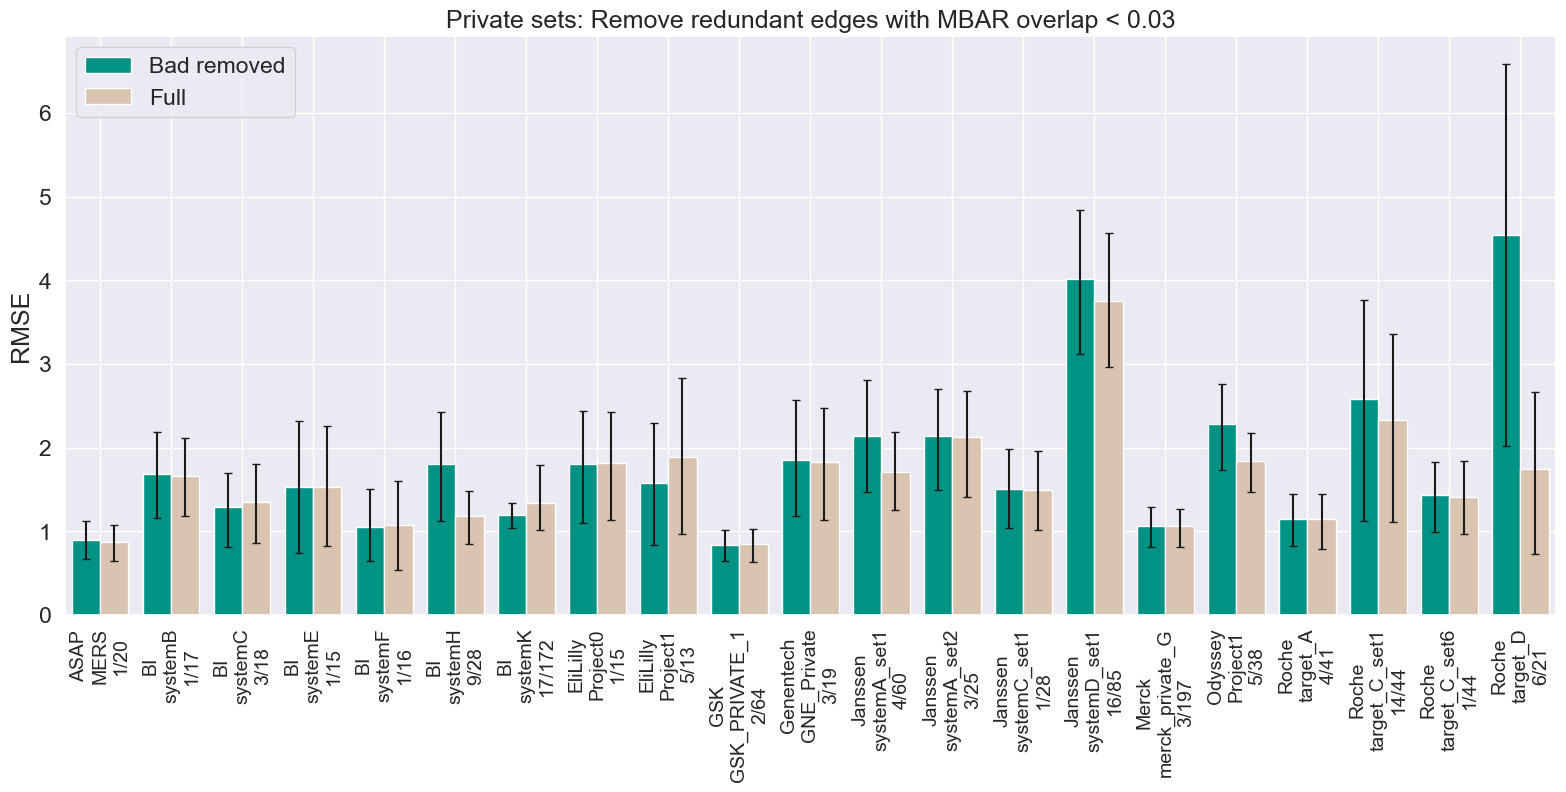

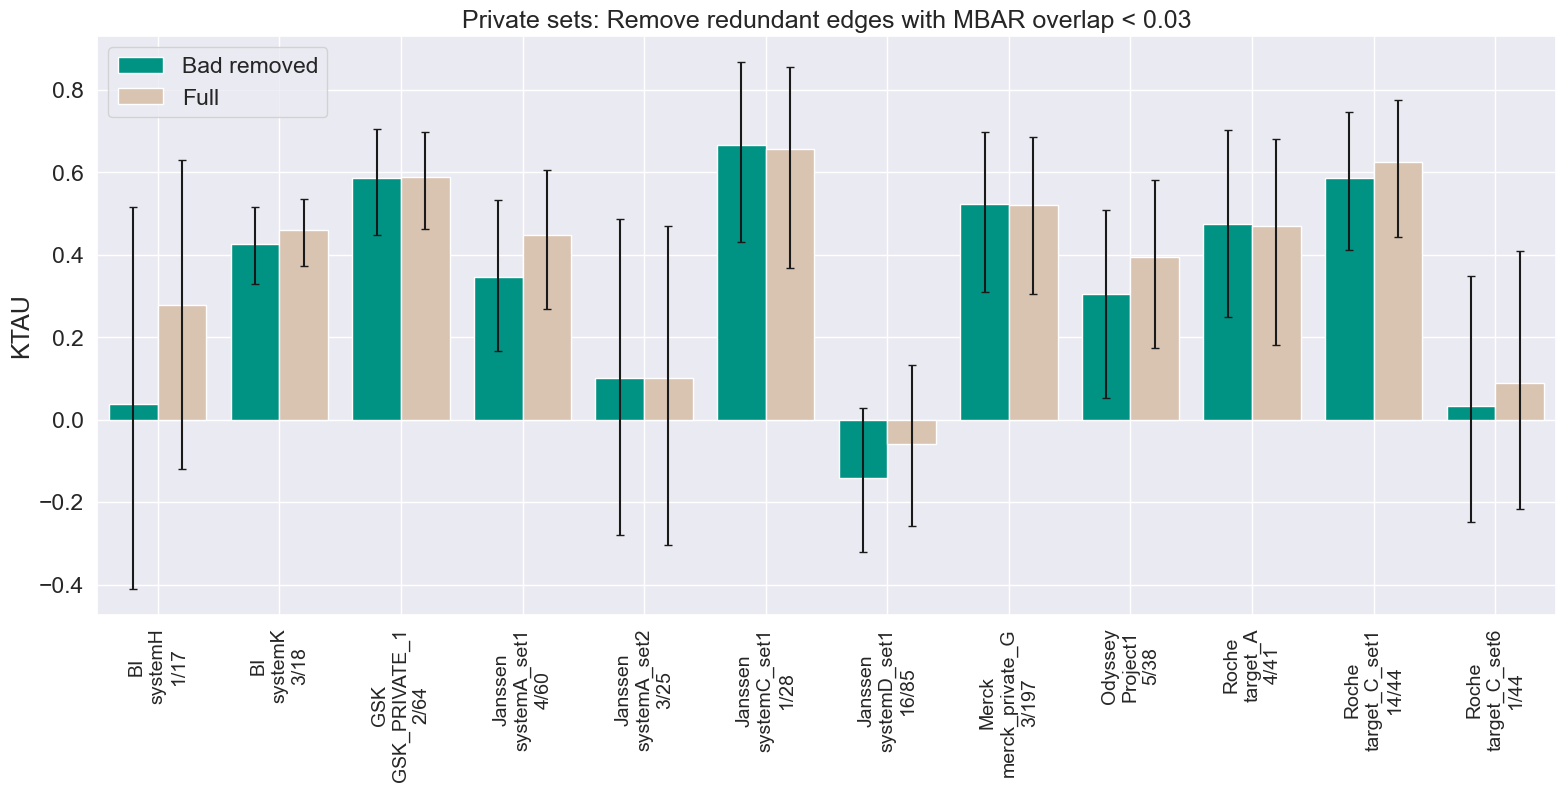

In [40]:
# Remove unconverged edges: Bad MBAR overlap private
stats_removed = {}
protocol = f'Private sets: Remove redundant edges with MBAR overlap < {threshold_mbar_overlap}'
stats_removed = remove_unconverged_edges(private_edge_data, private_dg_data, smallest_overlap_private, threshold_mbar_overlap, direction='smaller')
statistics = ['RMSE', 'KTAU']
for statistic in statistics:
    stat_items, stat_items_full = assemble_stats(stats_full_private, stats_removed, statistic)
    plot_stats_removed_edges(stat_items, stat_items_full, statistic, protocol, f'bad_overlap_removed_private_{statistic}.png')

# Looking at the edge difficulty

In [41]:
scores = ["lomap_score", "volume_score", "shape_score", "morgan_tanimoto_similarity", r"$\Delta$HAC" + '\n\n\n',
          "difference_solvent_accessible_surface_area", "atom_pair_dice_similarity", "topological_torsion_dice_similarity",
          "difference_num_rings_AB", "difference_num_rot_bonds_AB"]

In [42]:
public_edge_data[r"$\Delta$HAC" + '\n\n\n'] = public_edge_data["num_heavy_dummy_A"] + public_edge_data["num_heavy_dummy_B"]

In [43]:
abs_diff_calc_exp = [abs(i) for i in diff_calc_exp]

In [44]:
# Private sets
private_edge_data[r"$\Delta$HAC" + '\n\n\n'] = private_edge_data["num_heavy_dummy_A"] + private_edge_data["num_heavy_dummy_B"]

In [45]:
# Reverse shape score
public_edge_data['shape_score'] = 1-public_edge_data['shape_score']
private_edge_data['shape_score'] = 1-private_edge_data['shape_score']

# Divide the solvent asseccible surface area by 10 to be more similar to other scores
public_edge_data['difference_solvent_accessible_surface_area'] = public_edge_data['difference_solvent_accessible_surface_area']/10
private_edge_data['difference_solvent_accessible_surface_area'] = private_edge_data['difference_solvent_accessible_surface_area']/10

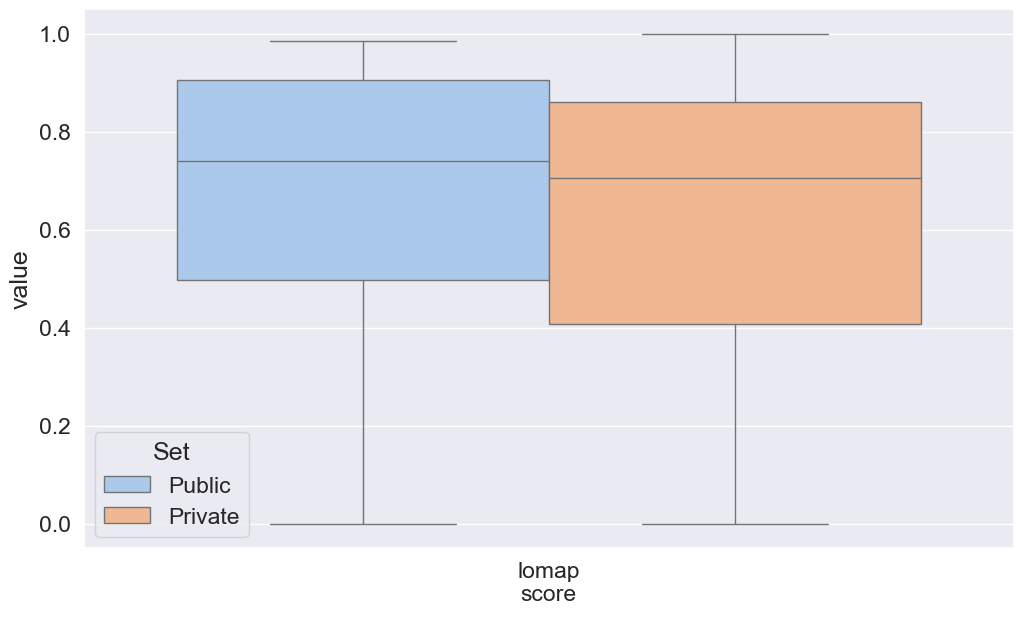

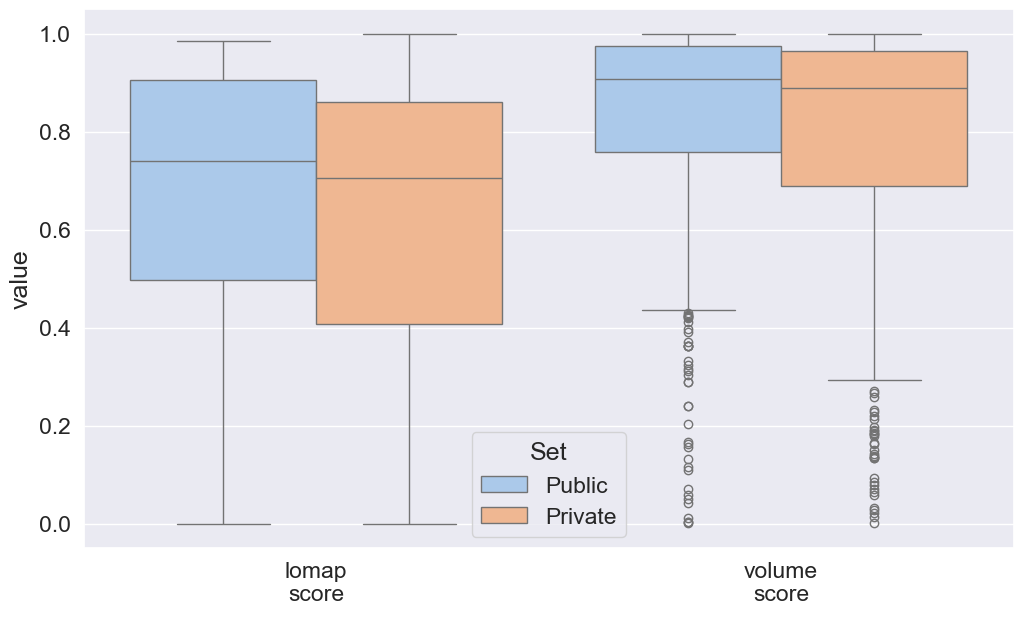

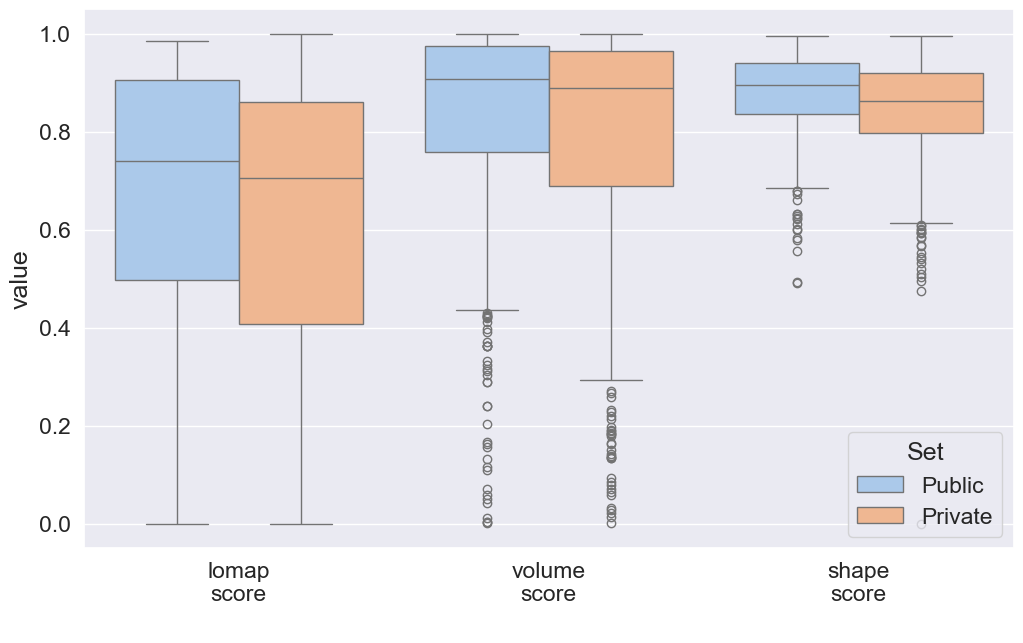

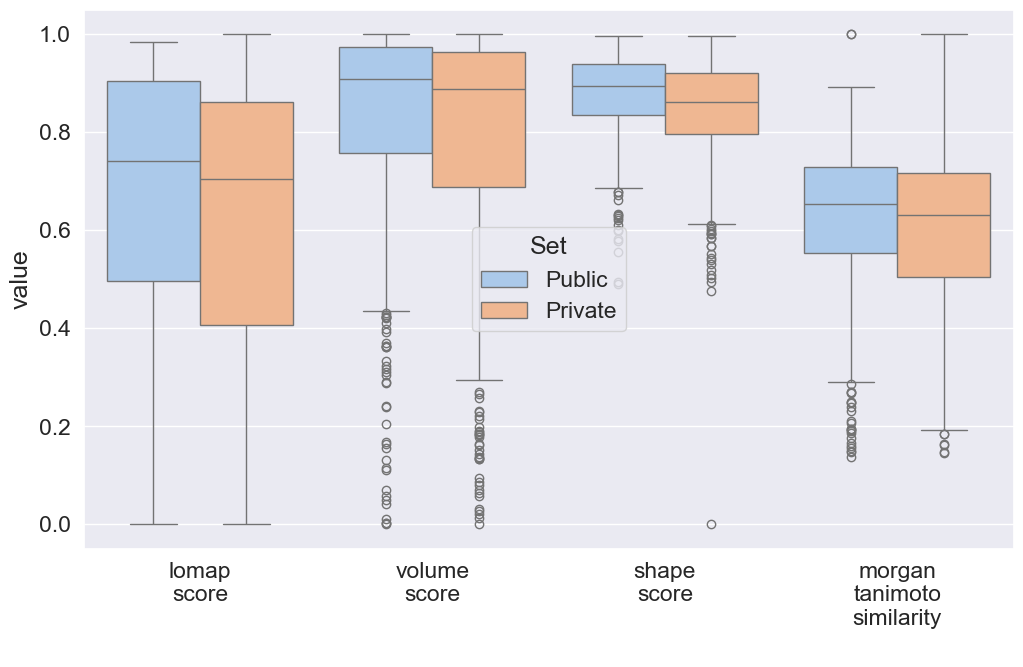

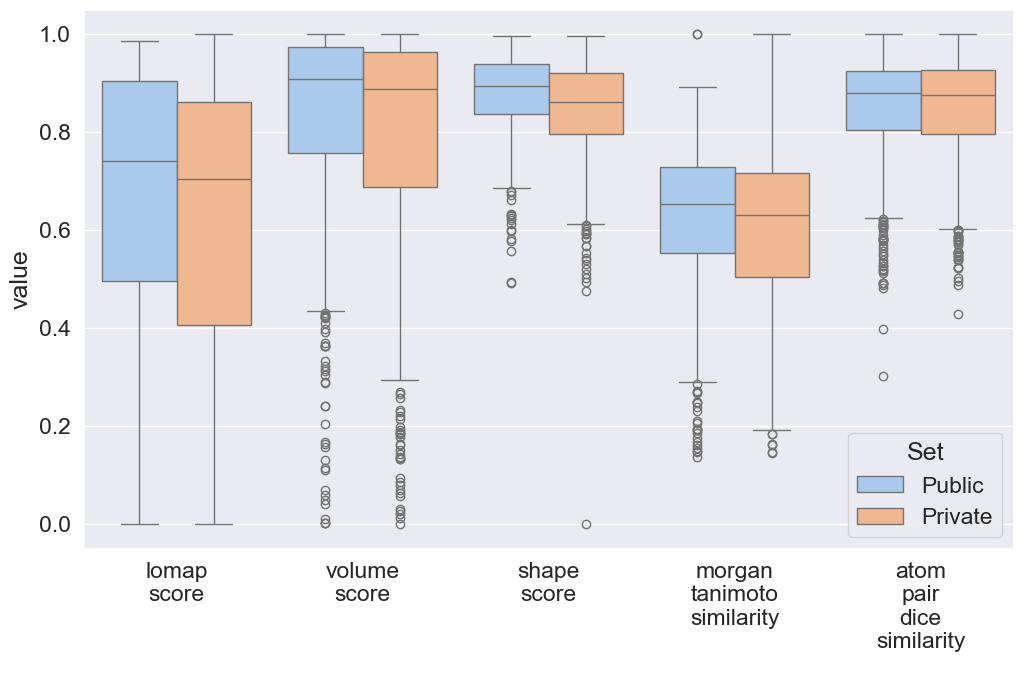

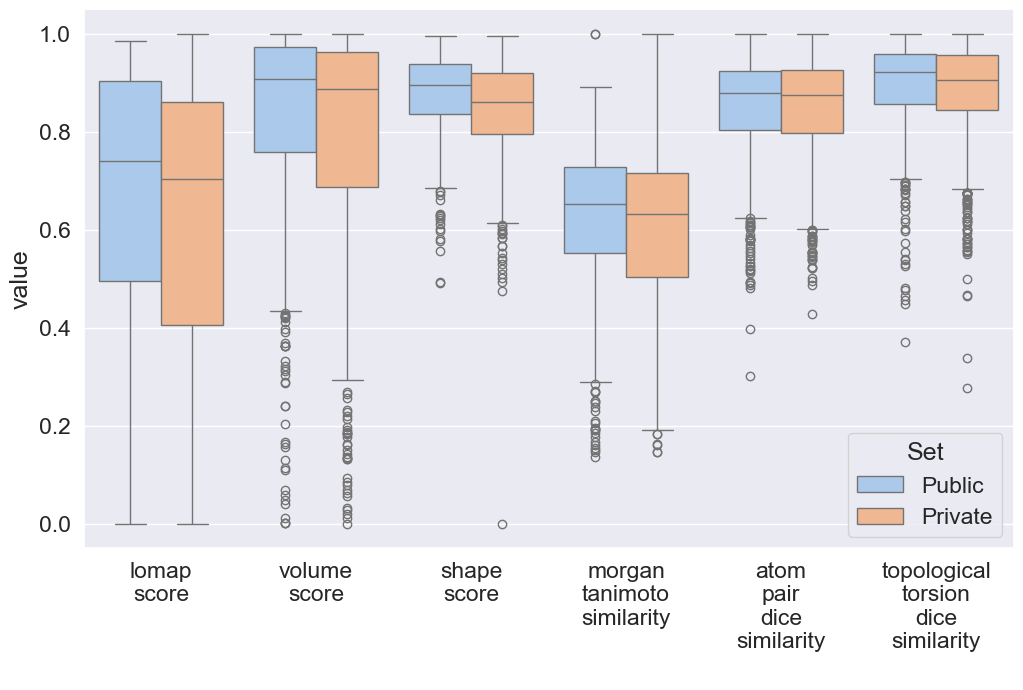

In [46]:
scores_1 = ["lomap_score", "volume_score", "shape_score", "morgan_tanimoto_similarity", 
          "atom_pair_dice_similarity", "topological_torsion_dice_similarity",
        ]
data = {}
data[' '] = []
data['value'] = []
data['Set'] = []
data_private = {}
data_private[' '] = []
data_private['value'] = []
for s in scores_1:
    # Generate multiple datasets
    data[' '].extend([f'{s.replace('_', '\n')}']*(len(public_edge_data)+len(private_edge_data)))
    data['value'].extend(public_edge_data[s].tolist()+private_edge_data[s].tolist())
    data['Set'].extend([f'Public']*len(public_edge_data) +[f'Private']*len(private_edge_data))
    df_data = pd.DataFrame(data)
    df_data_private = pd.DataFrame(data_private)
    
    fig, ax = plt.subplots(figsize=(12,7))
    sns.boxplot(x=' ', y='value', data=df_data, hue='Set', palette="pastel")
plt.savefig('scores_boxplot.png', bbox_inches='tight')

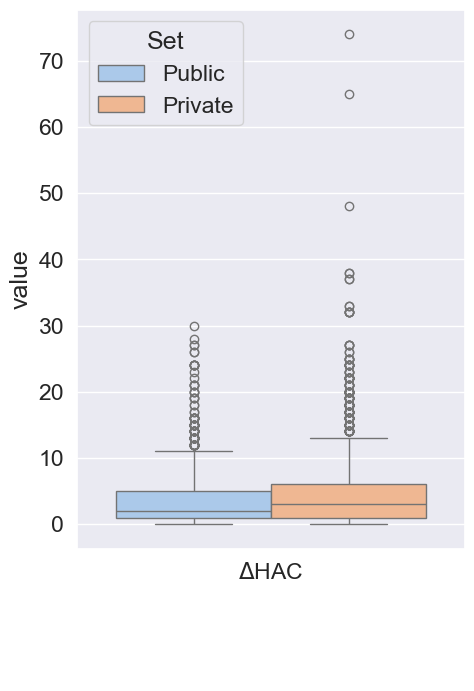

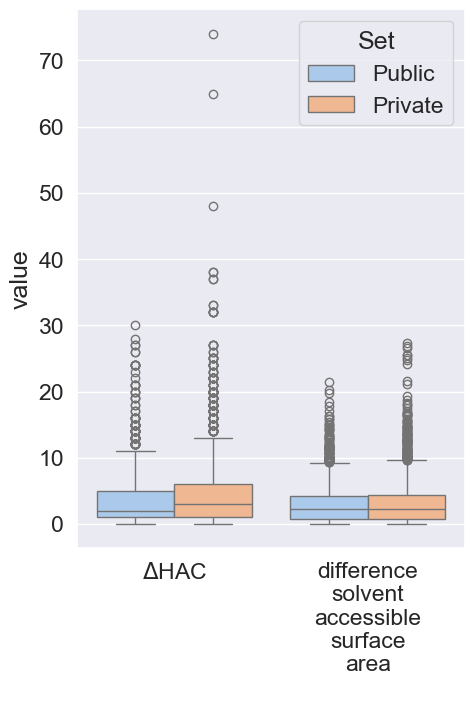

In [47]:
scores_2 = [r"$\Delta$HAC" + '\n\n\n',
          "difference_solvent_accessible_surface_area"]
data = {}
data[' '] = []
data['value'] = []
data['Set'] = []
data_private = {}
data_private[' '] = []
data_private['value'] = []
for s in scores_2:
    # Generate multiple datasets
    data[' '].extend([f'{s.replace('_', '\n')}']*(len(public_edge_data)+len(private_edge_data)))
    data['value'].extend(public_edge_data[s].tolist()+private_edge_data[s].tolist())
    data['Set'].extend([f'Public']*len(public_edge_data) +[f'Private']*len(private_edge_data))
    df_data = pd.DataFrame(data)
    df_data_private = pd.DataFrame(data_private)
    
    fig, ax = plt.subplots(figsize=(5,7))
    sns.boxplot(x=' ', y='value', data=df_data, hue='Set', palette="pastel")
# plt.show()
plt.savefig('scores_boxplot_2.png', bbox_inches='tight')

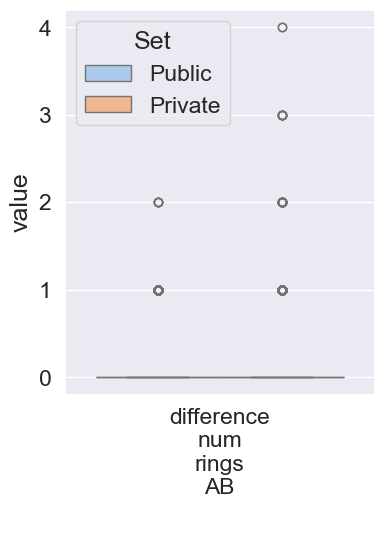

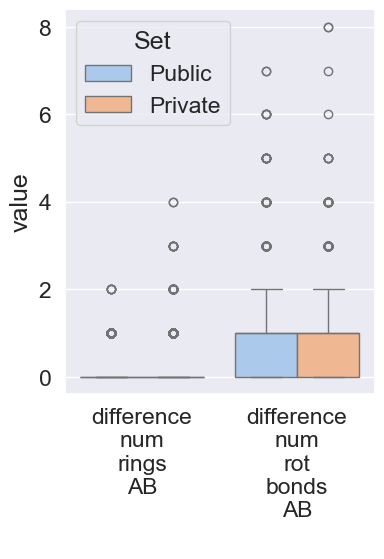

In [48]:
scores_3 = ["difference_num_rings_AB", "difference_num_rot_bonds_AB"]
data = {}
data[' '] = []
data['value'] = []
data['Set'] = []
data_private = {}
data_private[' '] = []
data_private['value'] = []
for s in scores_3:
    # Generate multiple datasets
    data[' '].extend([f'{s.replace('_', '\n')}']*(len(public_edge_data)+len(private_edge_data)))
    data['value'].extend(public_edge_data[s].tolist()+private_edge_data[s].tolist())
    data['Set'].extend([f'Public']*len(public_edge_data) +[f'Private']*len(private_edge_data))
    df_data = pd.DataFrame(data)
    df_data_private = pd.DataFrame(data_private)
    
    fig, ax = plt.subplots(figsize=(4,5))
    sns.boxplot(x=' ', y='value', data=df_data, hue='Set', palette="pastel")
# plt.show()
plt.savefig('scores_boxplot_3.png', bbox_inches='tight')

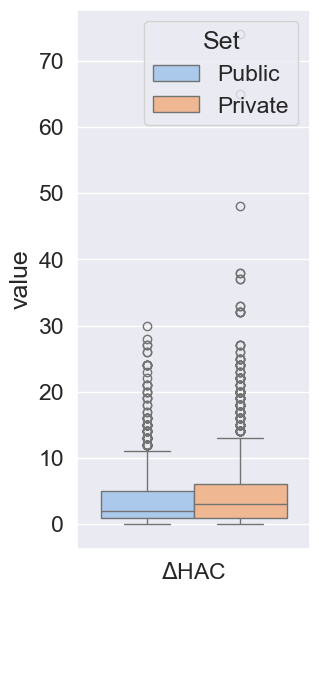

In [49]:
scores = [r"$\Delta$HAC" + '\n\n\n']
data = {}
data[' '] = []
data['value'] = []
data['Set'] = []
data_private = {}
data_private[' '] = []
data_private['value'] = []
for s in scores:
    data[' '].extend([f'{s.replace('_', '\n')}']*(len(public_edge_data)+len(private_edge_data)))
    data['value'].extend(public_edge_data[s].tolist()+private_edge_data[s].tolist())
    data['Set'].extend([f'Public']*len(public_edge_data) +[f'Private']*len(private_edge_data))
    df_data = pd.DataFrame(data)
    df_data_private = pd.DataFrame(data_private)
    
    fig, ax = plt.subplots(figsize=(3,7))
    sns.boxplot(x=' ', y='value', data=df_data, hue='Set', palette="pastel")
        # sns.boxplot(x=' ', y='value', data=df_data_private, palette="pastel")
# plt.show()
plt.savefig('scores_boxplot_hac.png', bbox_inches='tight')

In [50]:
def plot_score_convergence(edge_data, metric, threshold, filename, direction='greater'):
    data = {}
    data[' '] = []
    data['value'] = []
    data['Method'] = []
    scores = [
        "lomap_score", "volume_score", "shape_score", "morgan_tanimoto_similarity", "atom_pair_dice_similarity", "topological_torsion_dice_similarity",
    ]
    
    for s in scores:
        unconverged = []
        converged = []
        for inx, error in enumerate(metric):
            if direction == 'greater':
                if error > threshold:
                    unconverged.append(edge_data[s][inx])
                else:
                    converged.append(edge_data[s][inx])
            if direction == 'smaller':
                if error < threshold:
                    unconverged.append(edge_data[s][inx])
                else:
                    converged.append(edge_data[s][inx])
        # Generate multiple datasets
        data[' '].extend([f'{s.replace('_', '\n')}']*len(converged+unconverged+edge_data[s].tolist()))
        data['value'].extend(edge_data[s].tolist() +converged + unconverged)
        data['Method'].extend([f'All edges\n{len(edge_data)}']*len(edge_data) +[f'Converged\n{len(converged)}']*len(converged) + [f'Unconverged\n{len(unconverged)}']*len(unconverged))
        df_score = pd.DataFrame(data)
        # Create additional grouping data
        # Plots graph
        fig, ax = plt.subplots(figsize=(15,7))
        sns.boxplot(x=' ', y='value', data=df_score, hue='Method', palette=('#009384', '#d9c4b1', '#666666'))
    plt.savefig(filename, bbox_inches='tight')

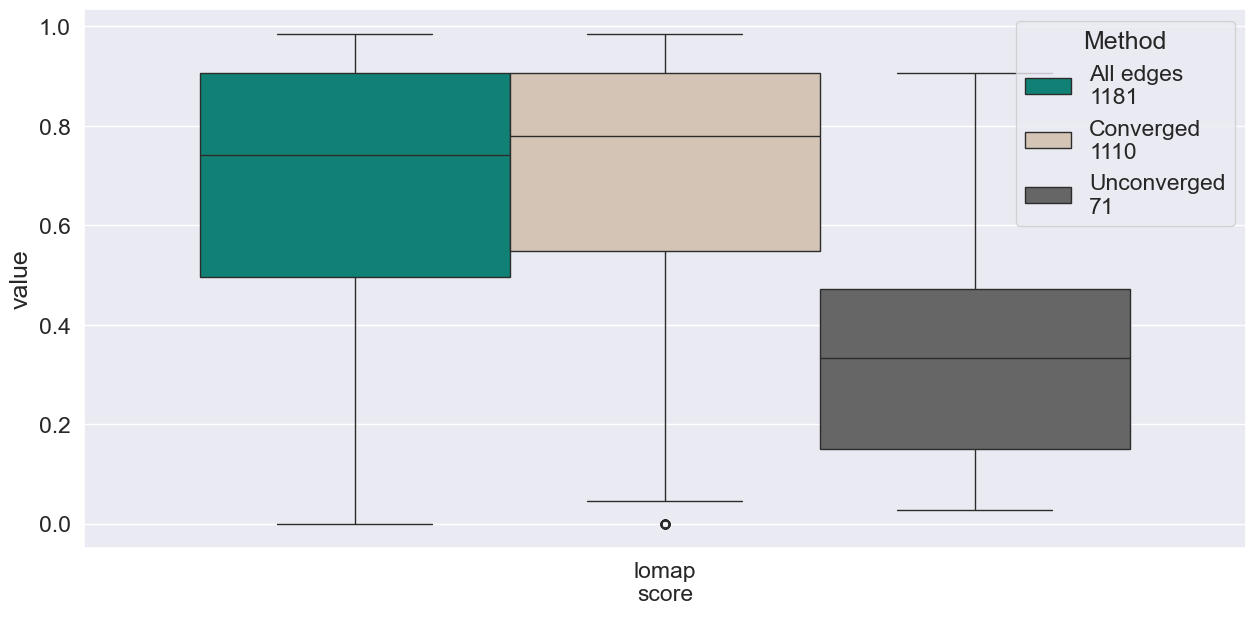

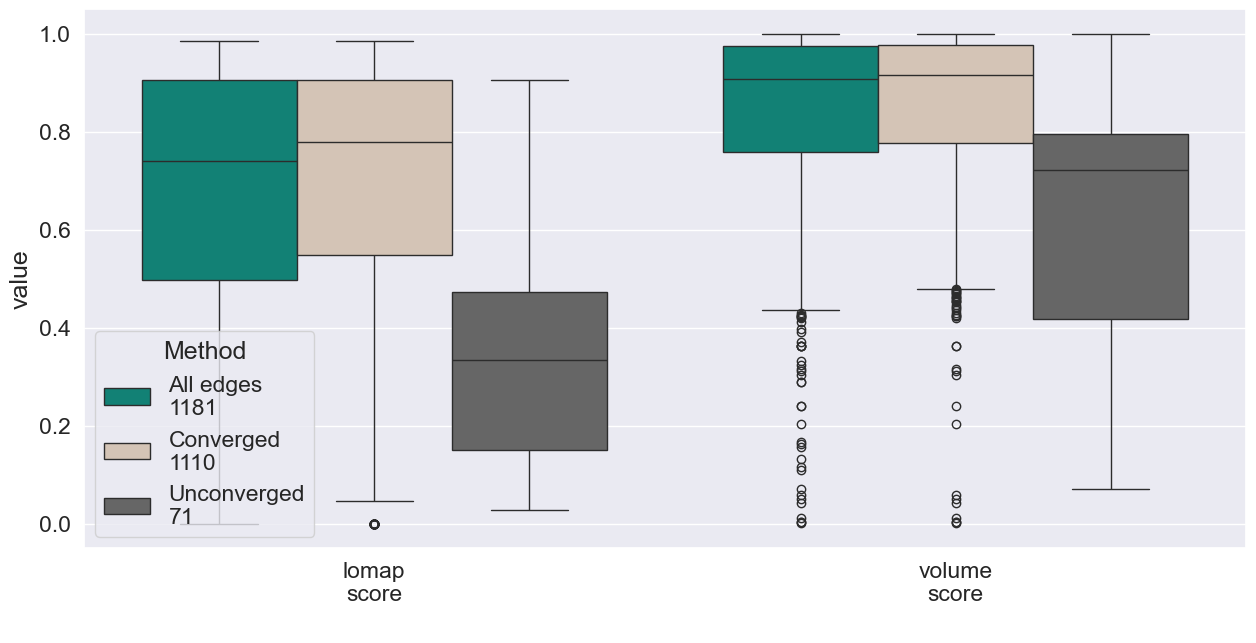

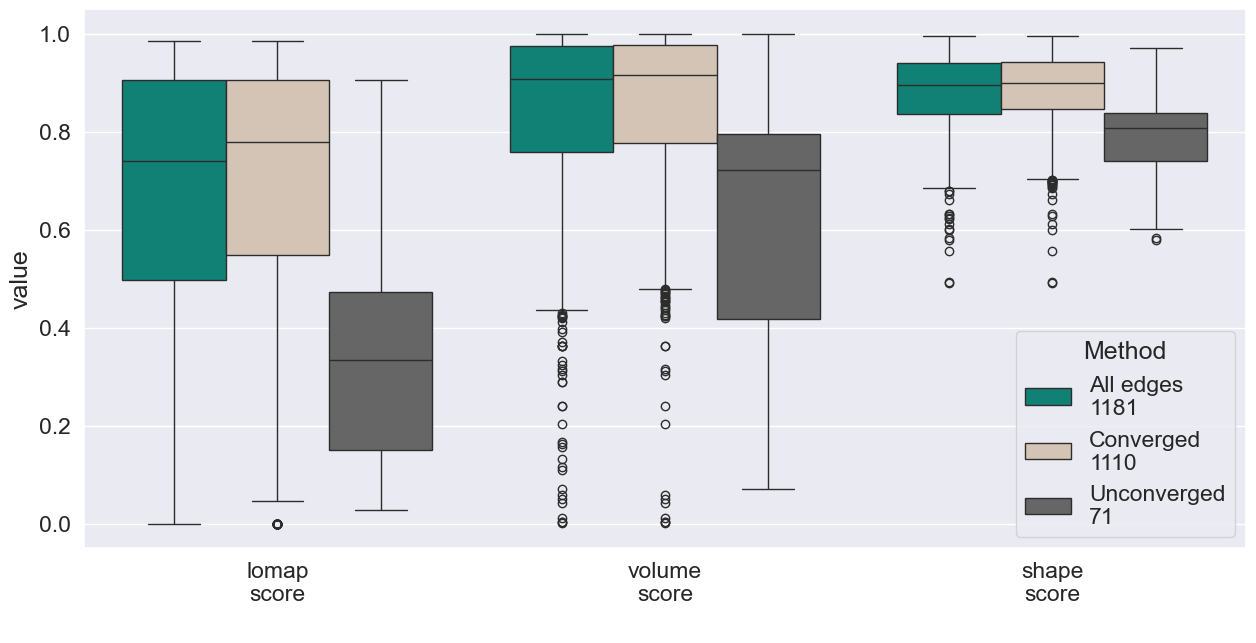

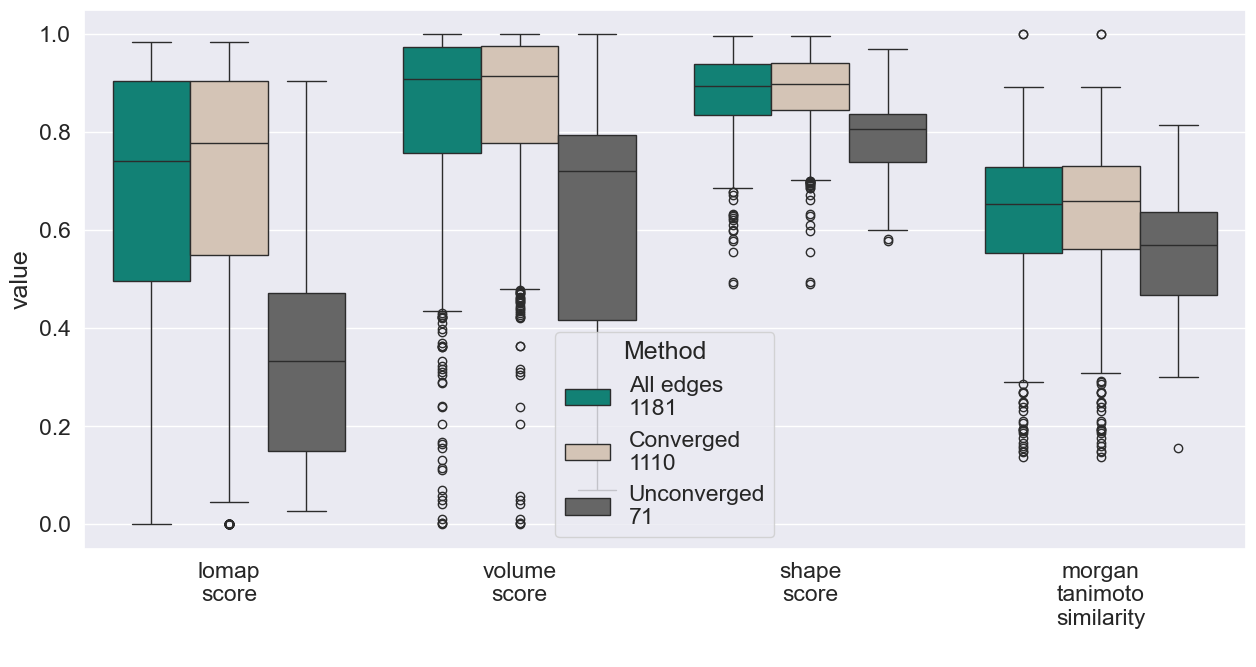

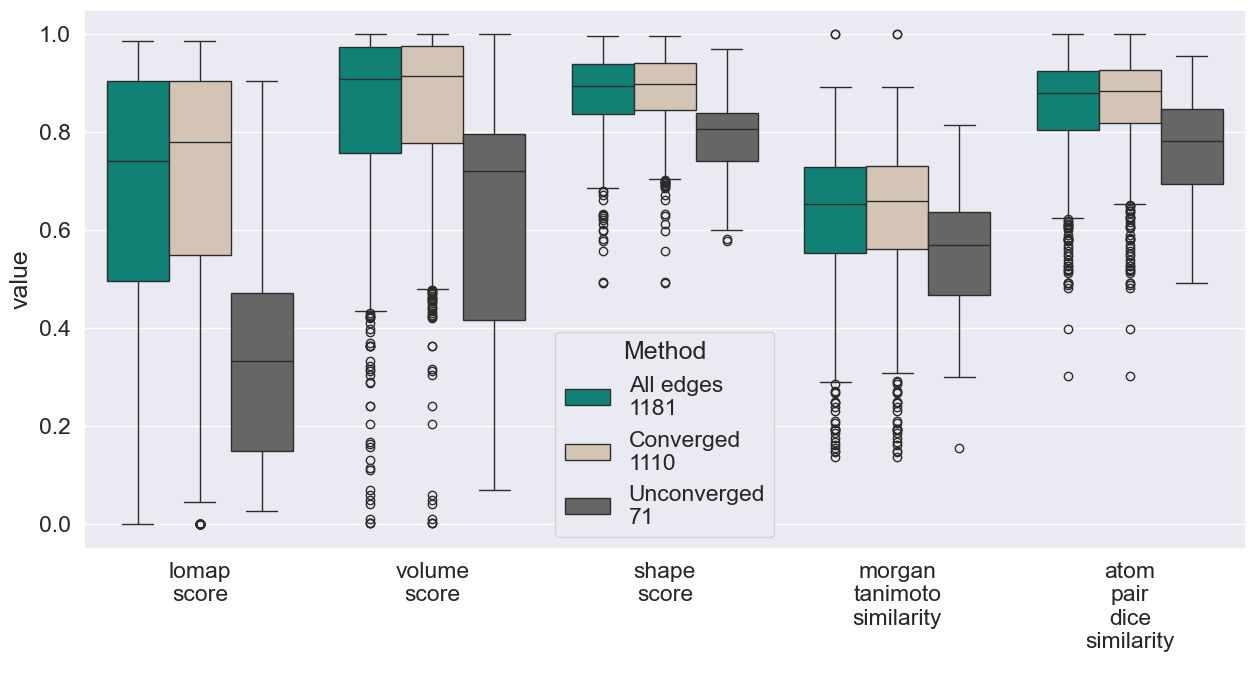

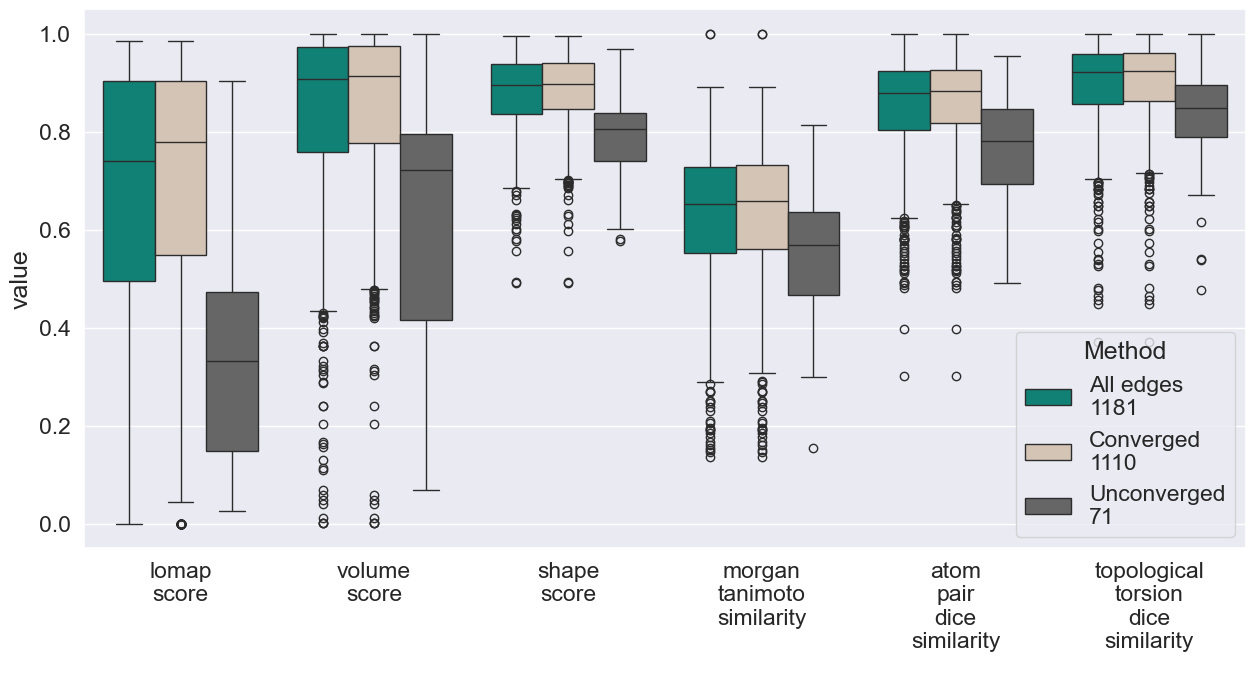

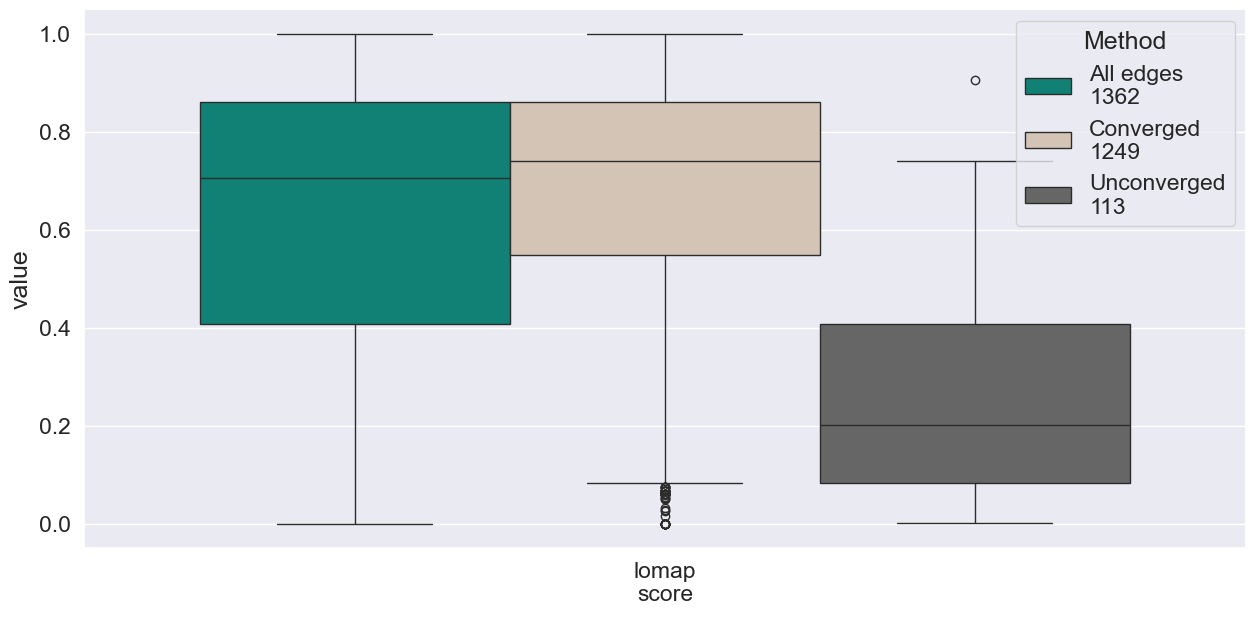

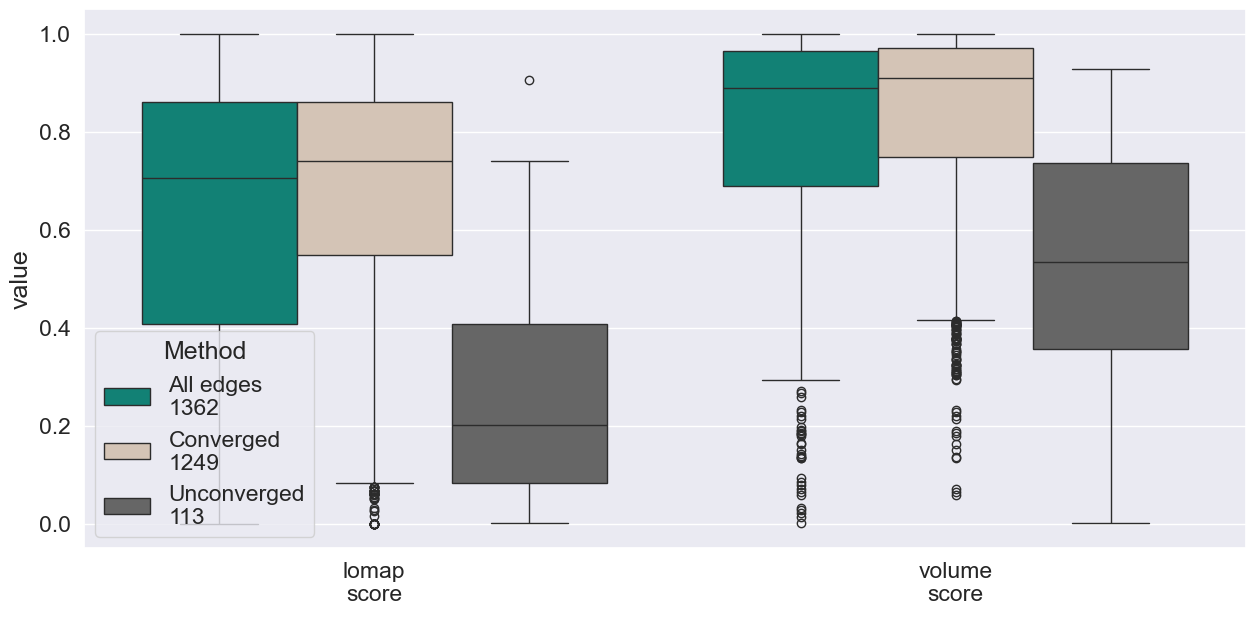

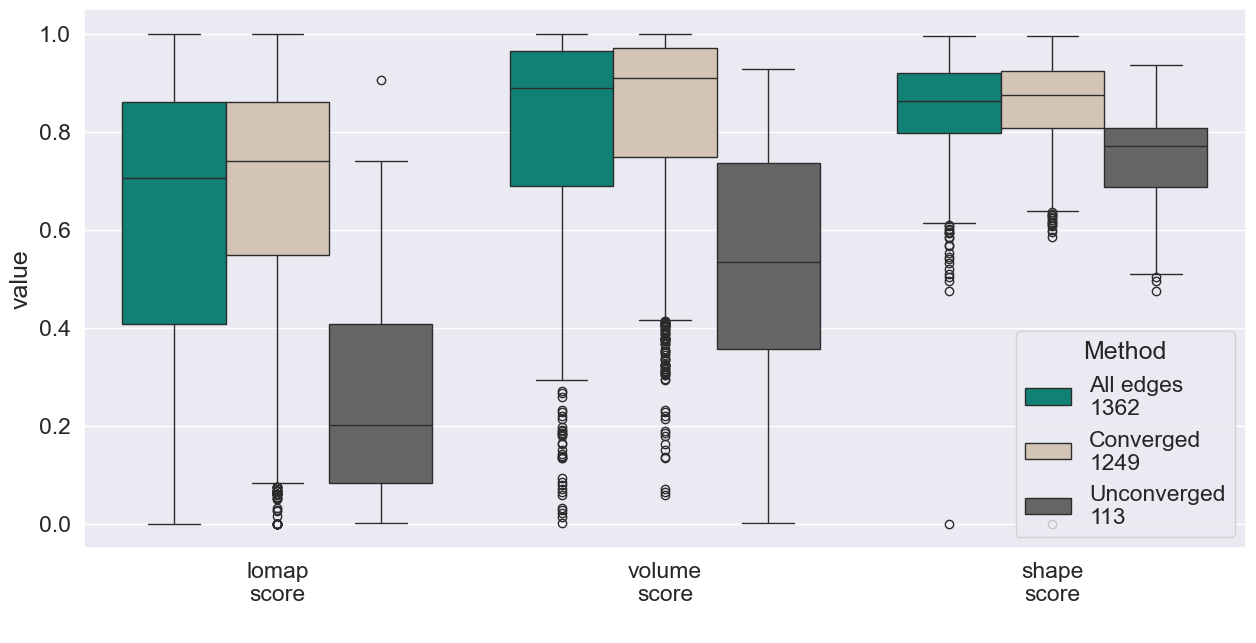

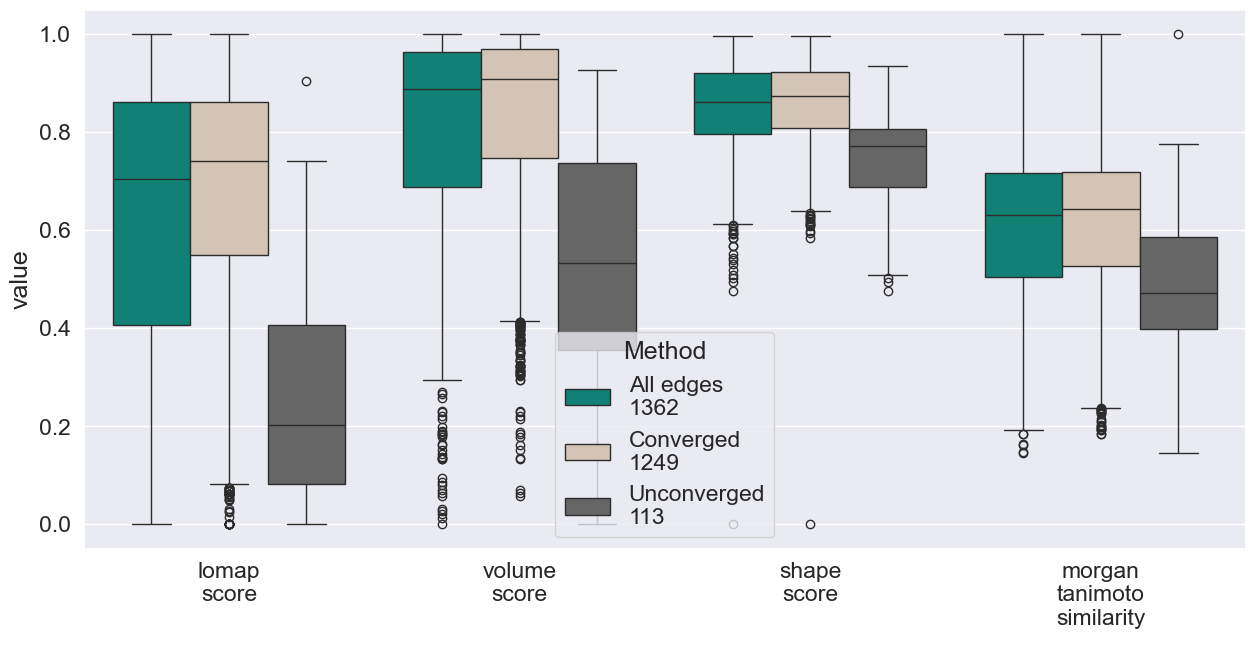

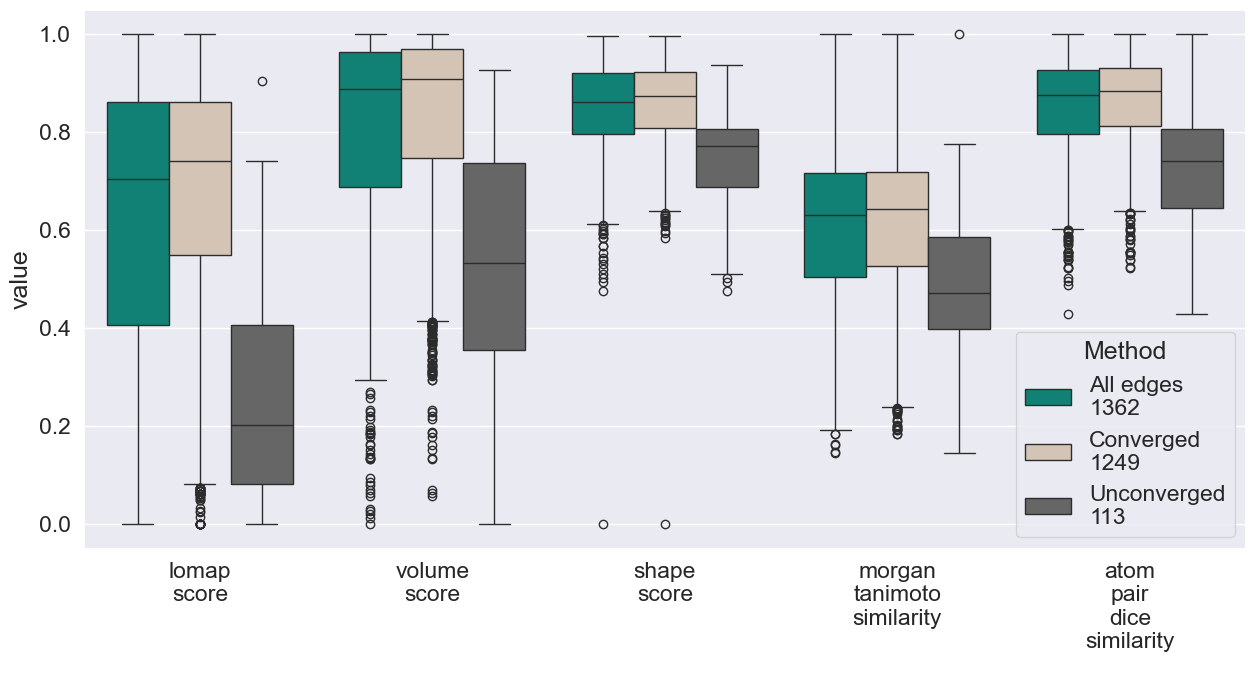

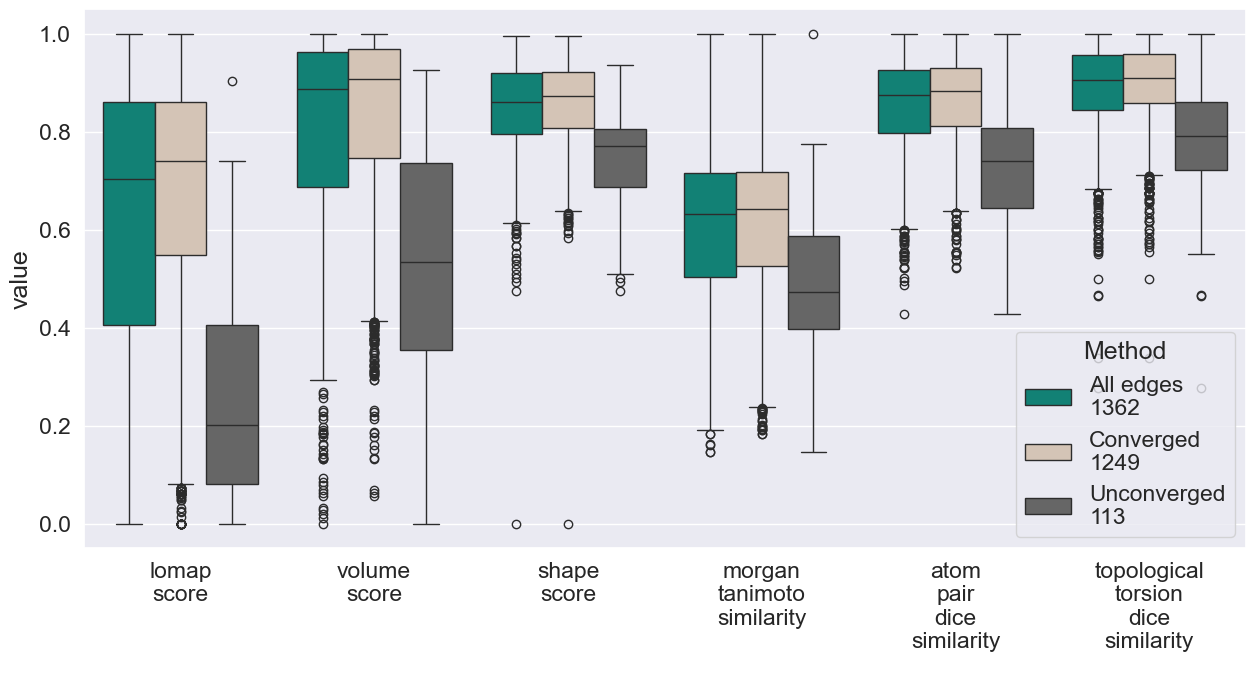

In [51]:
# MBAR error
plot_score_convergence(public_edge_data, max_mbar, threshold_mbar_error, 'score_convergence_mbar_error.png', direction='greater')
plot_score_convergence(private_edge_data, max_mbar_private, threshold_mbar_error, 'score_convergence_mbar_error_private.png', direction='greater')

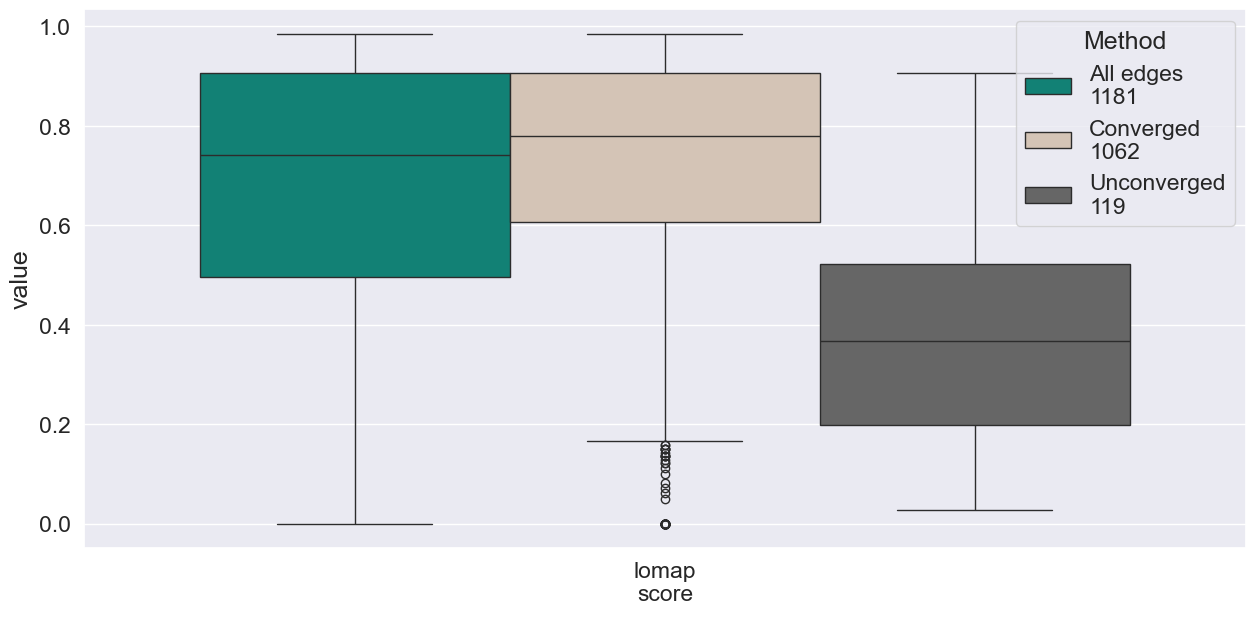

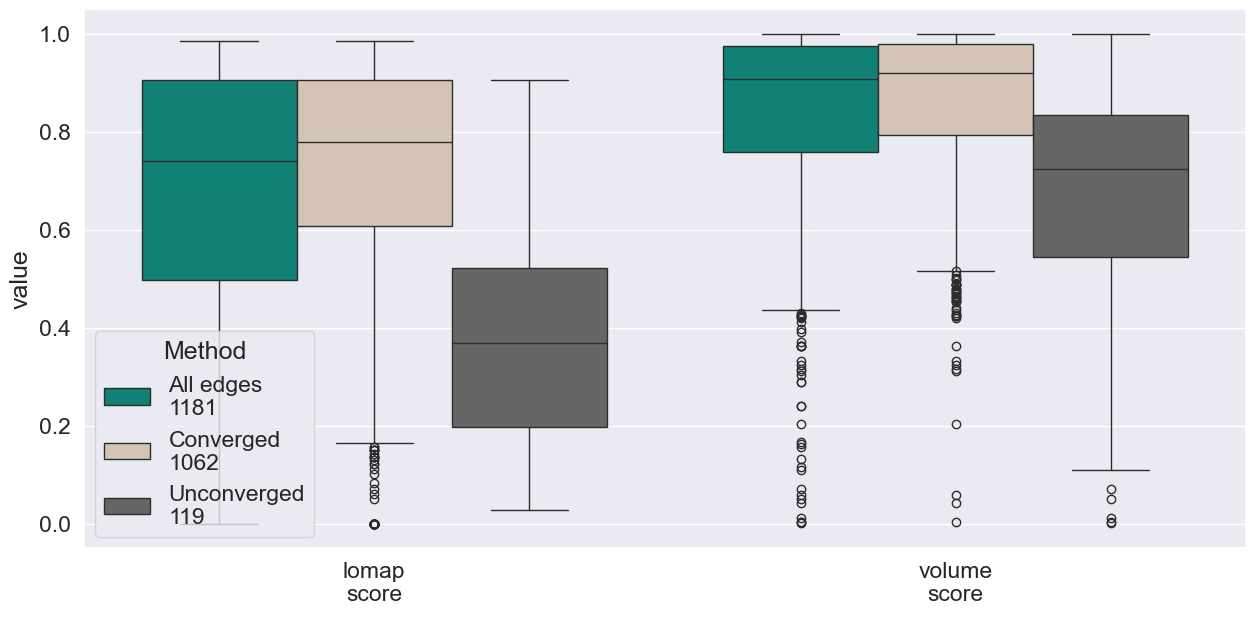

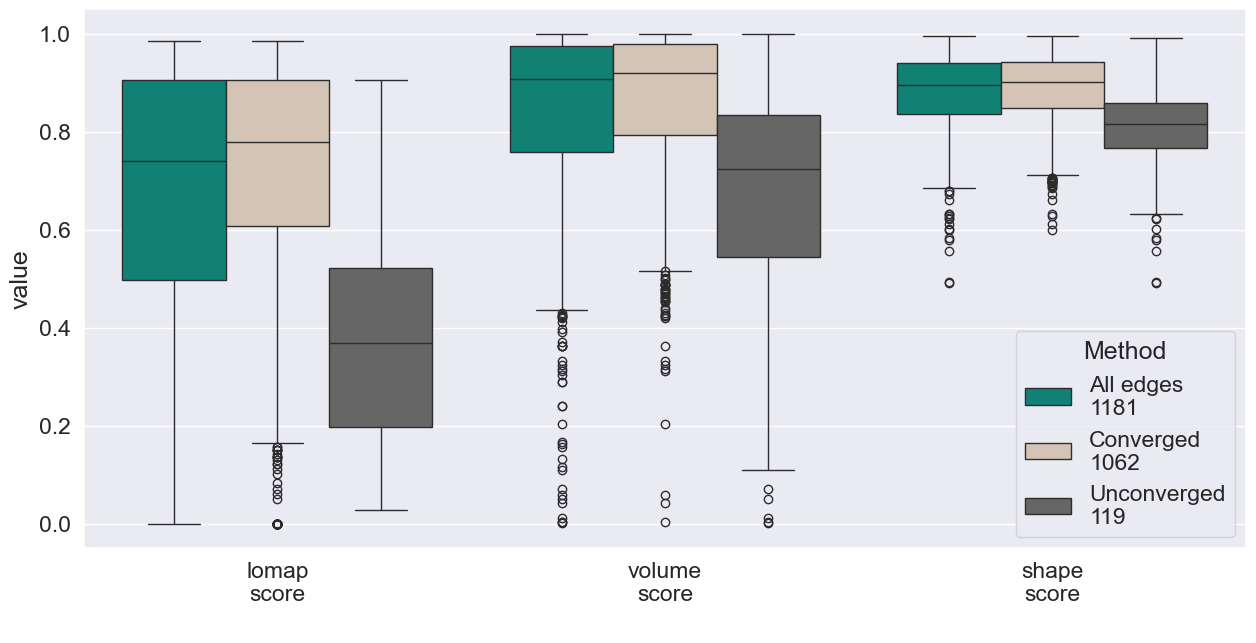

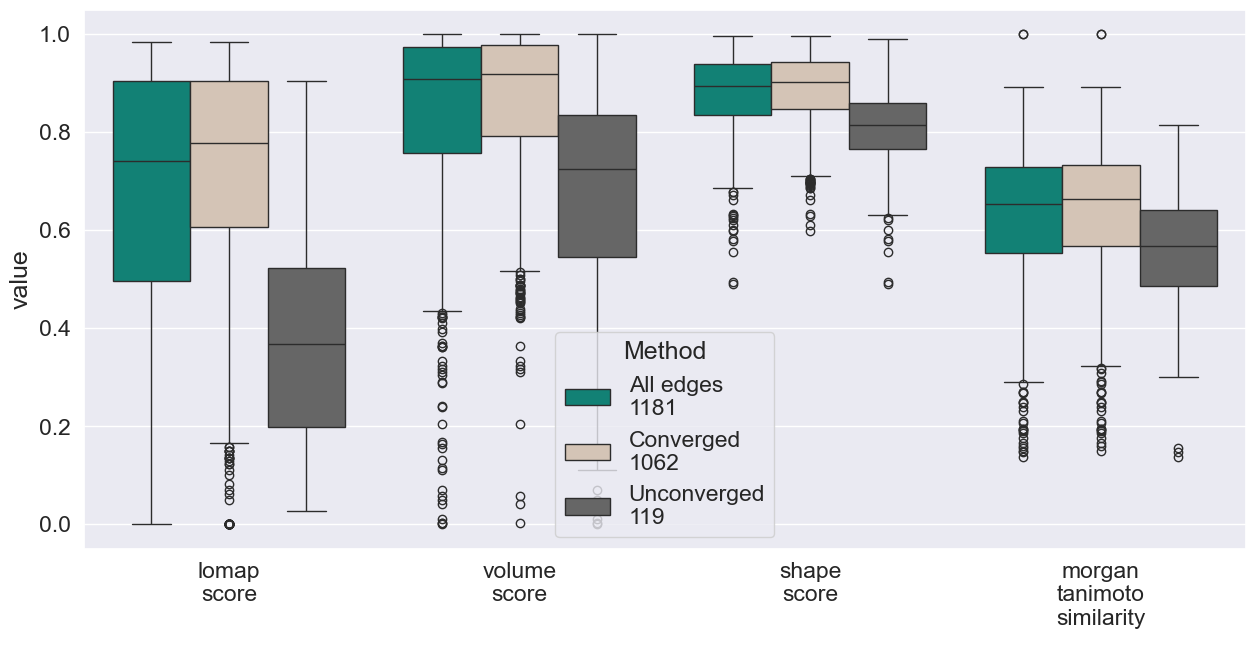

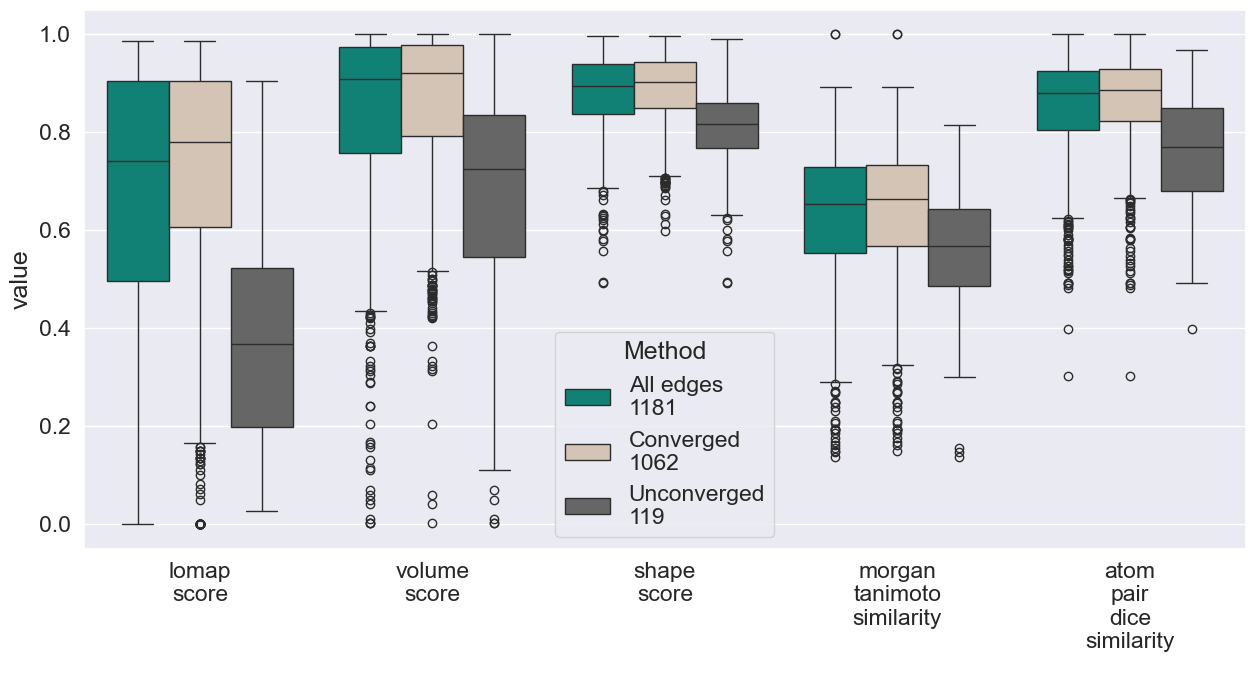

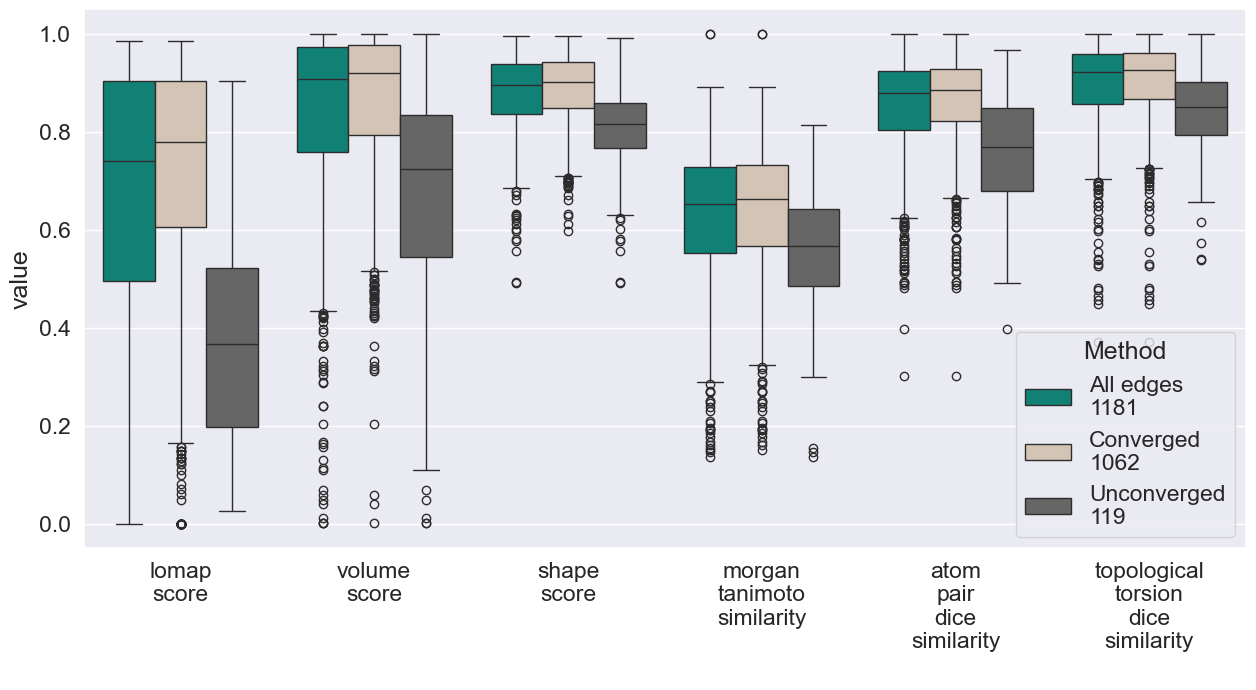

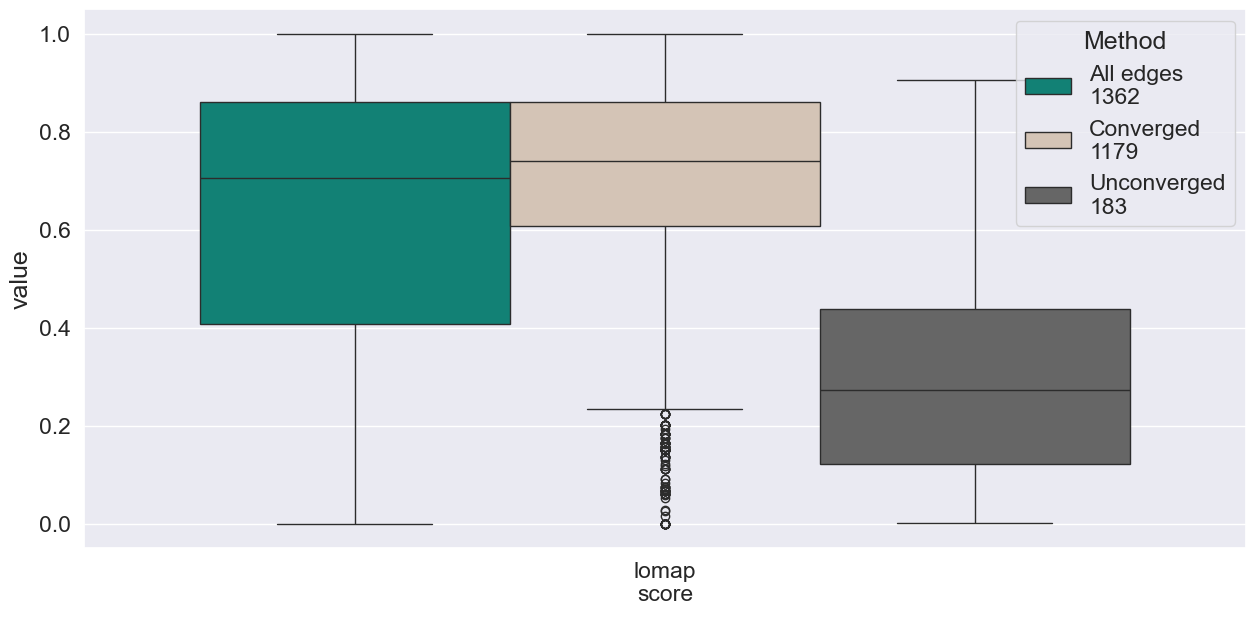

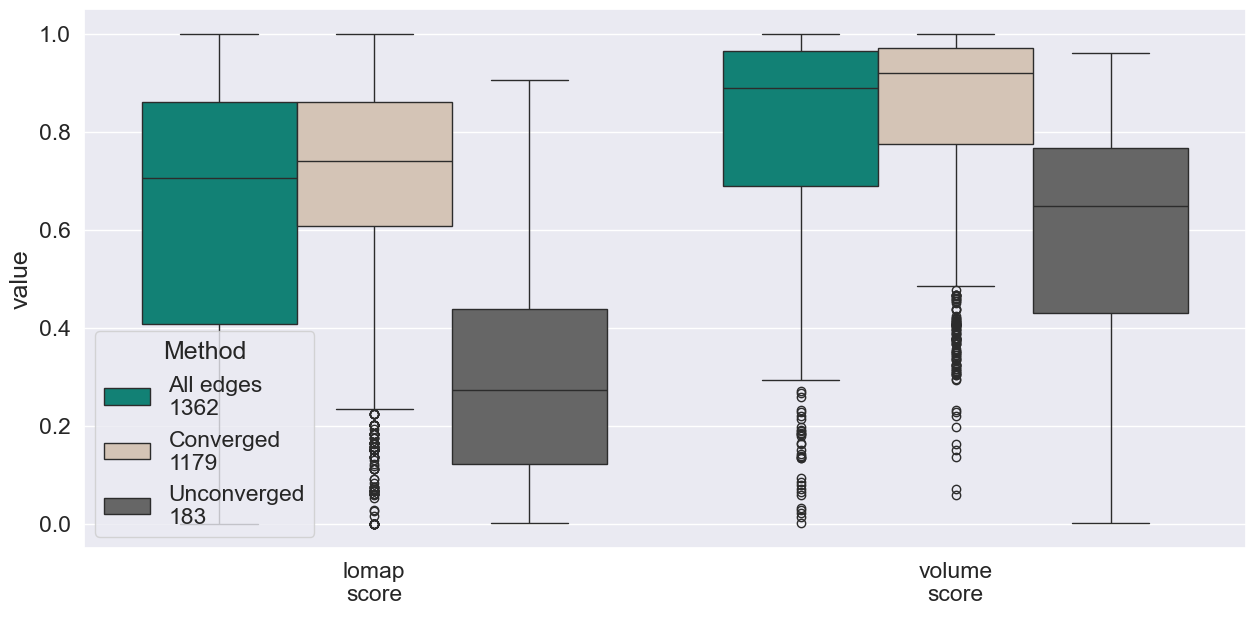

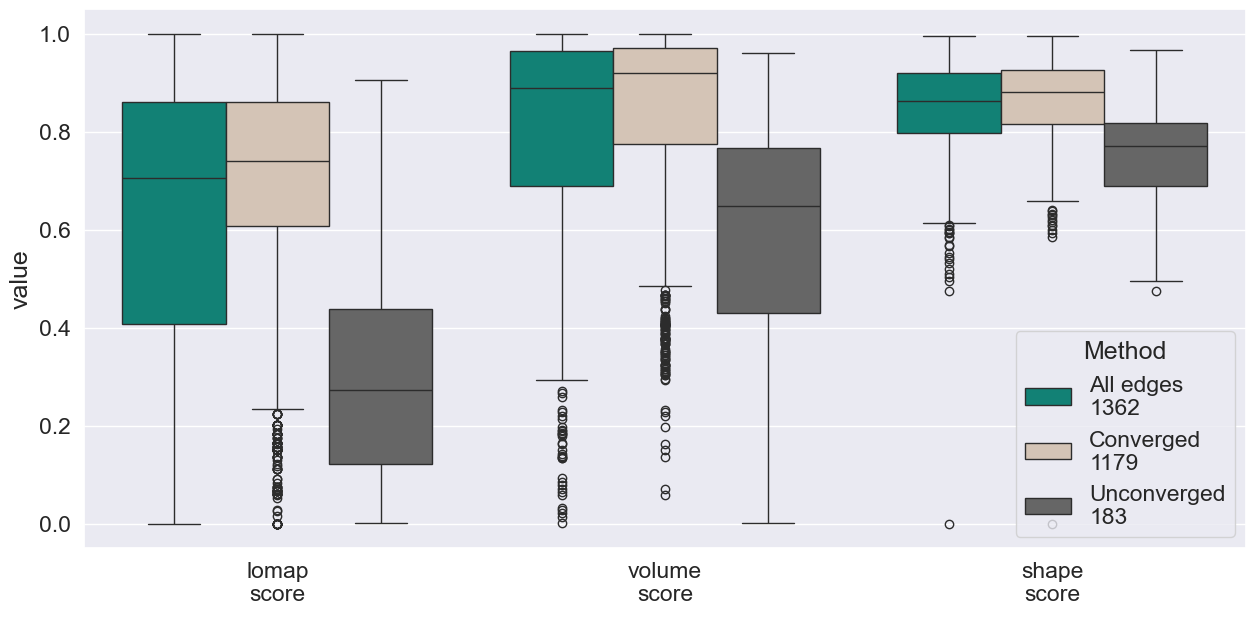

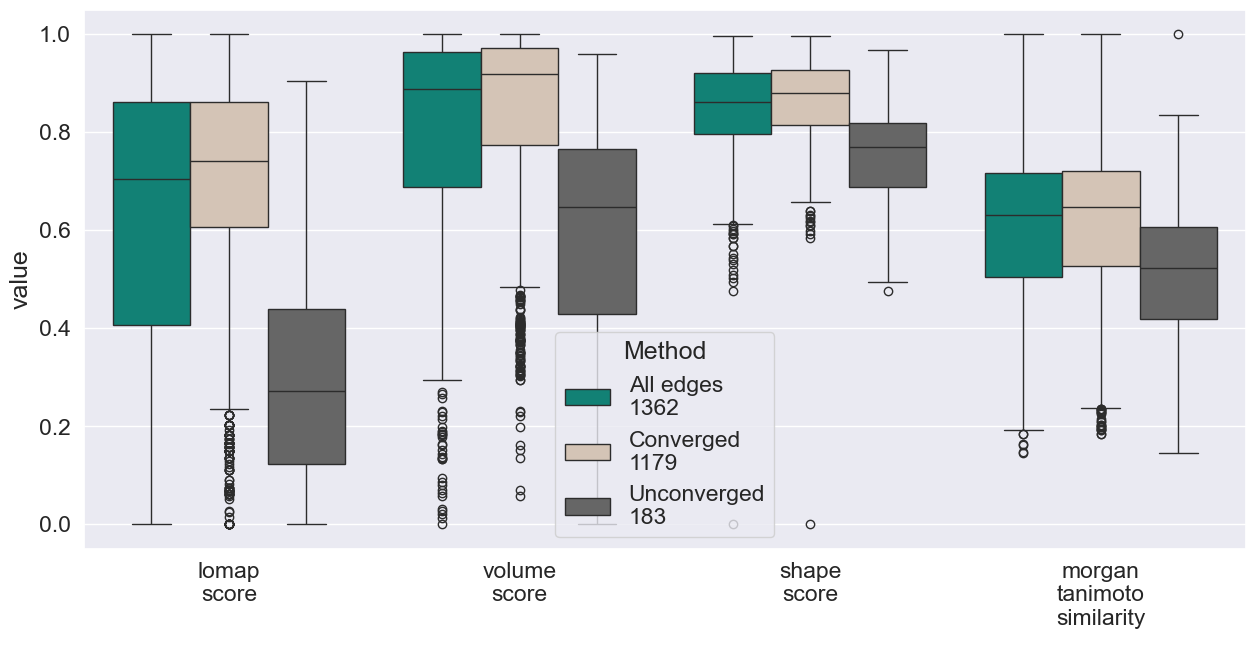

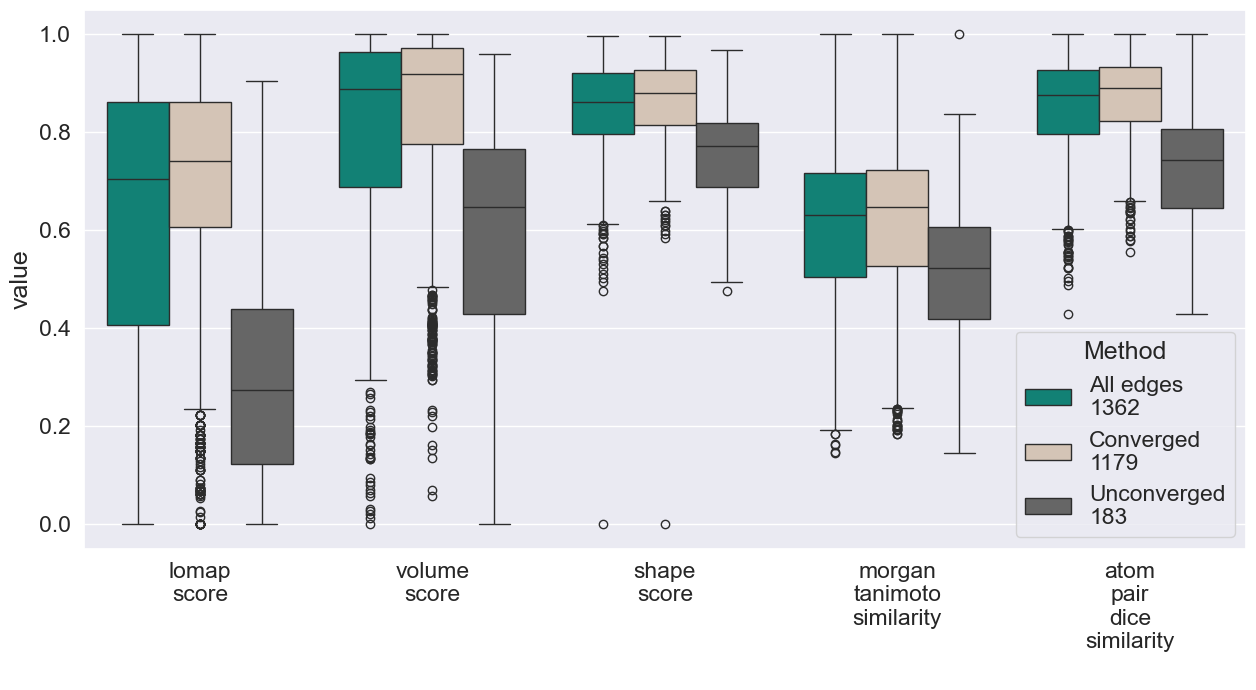

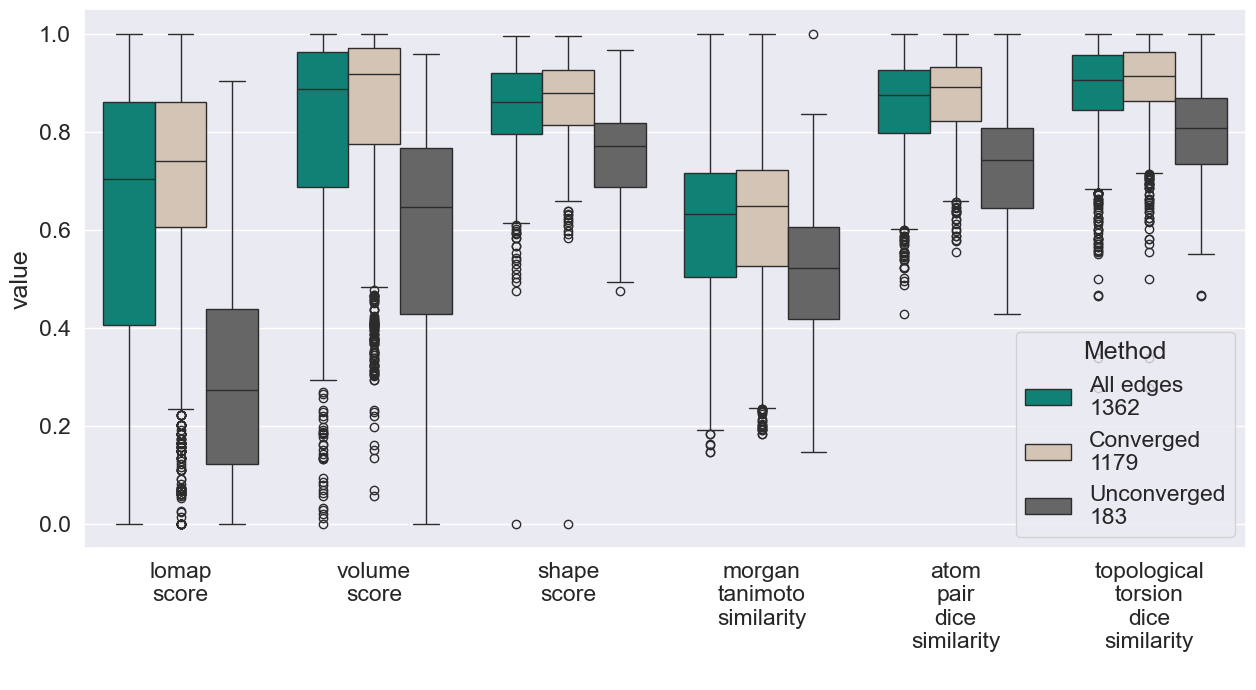

In [52]:
# MBAR overlap
plot_score_convergence(public_edge_data, smallest_overlap, threshold_mbar_overlap, 'score_convergence_mbar_overlap.png', direction='smaller')
plot_score_convergence(private_edge_data, smallest_overlap_private, threshold_mbar_overlap, 'score_convergence_mbar_overlap_private.png', direction='smaller')

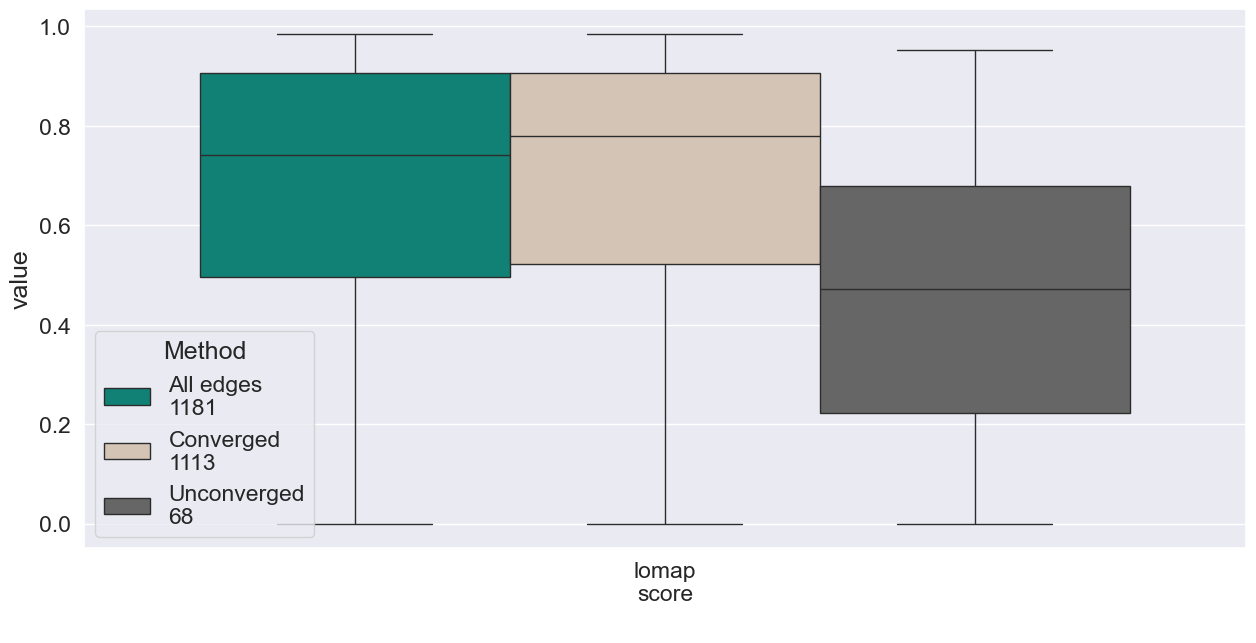

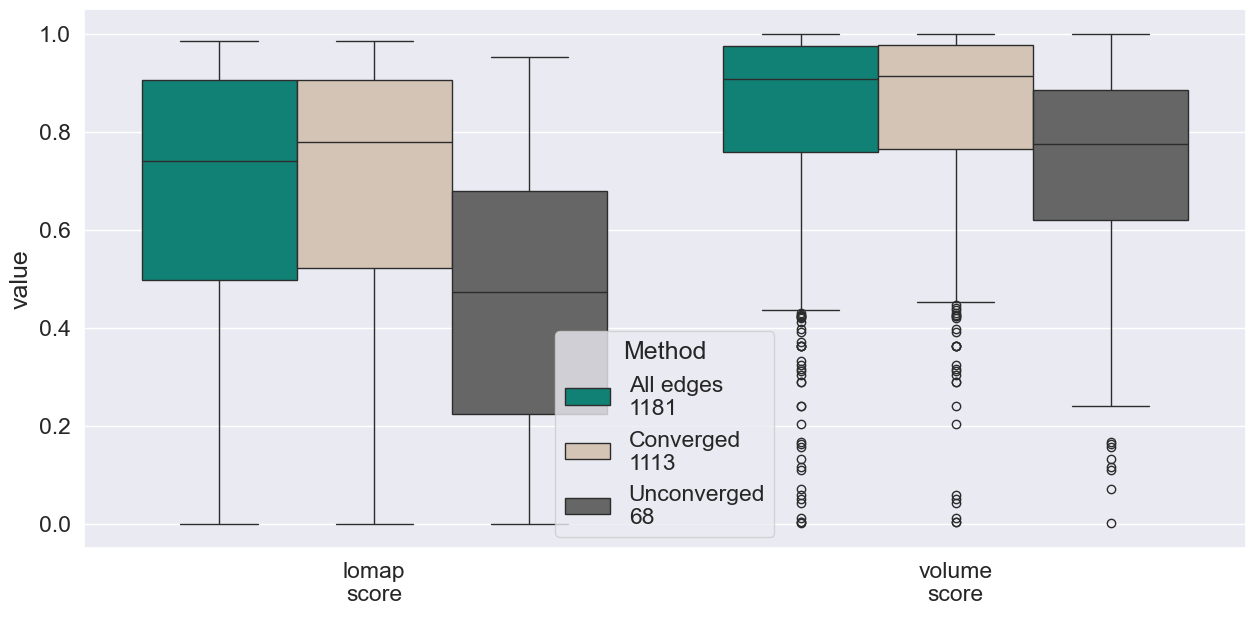

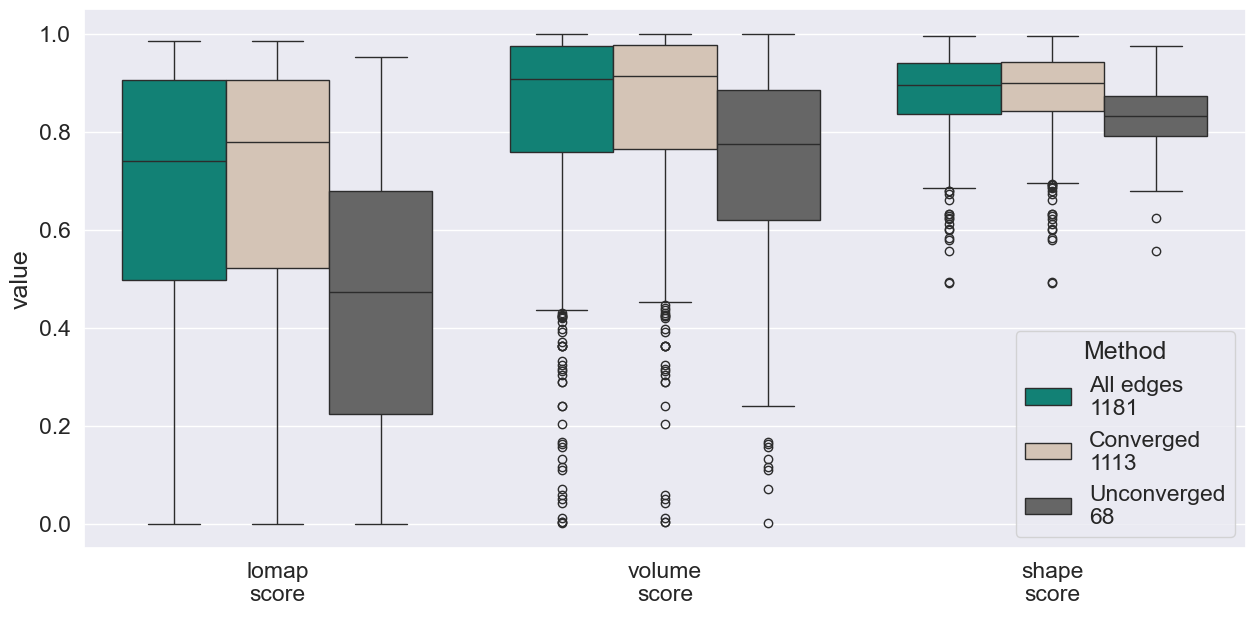

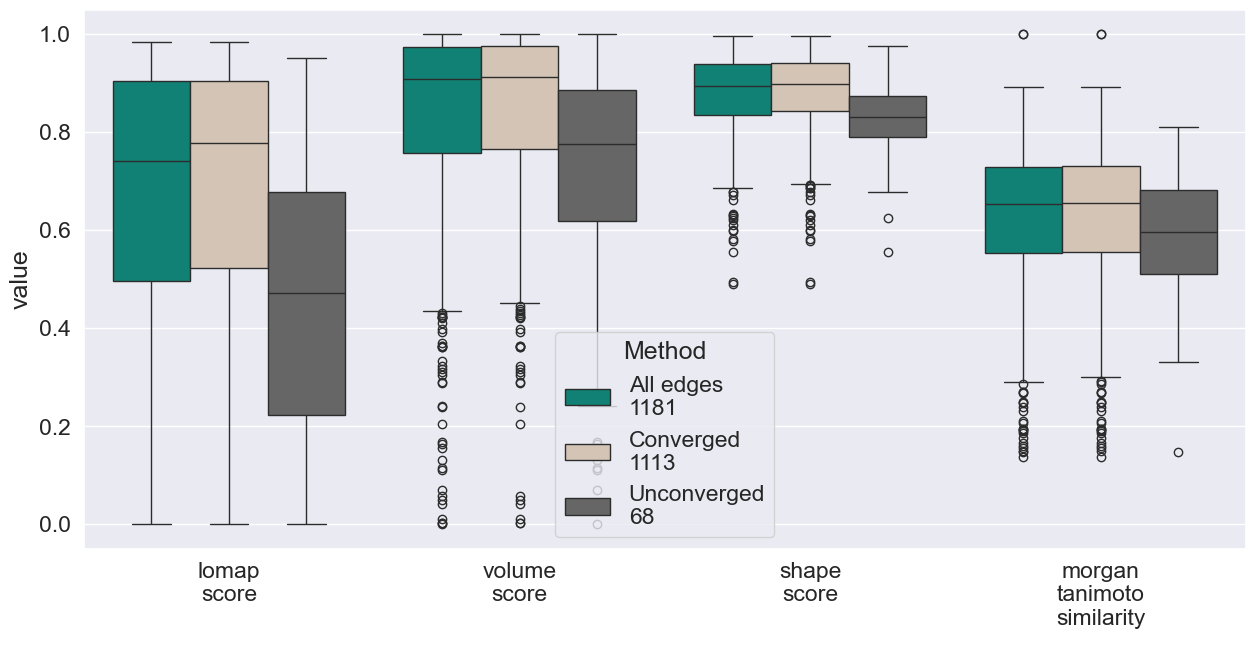

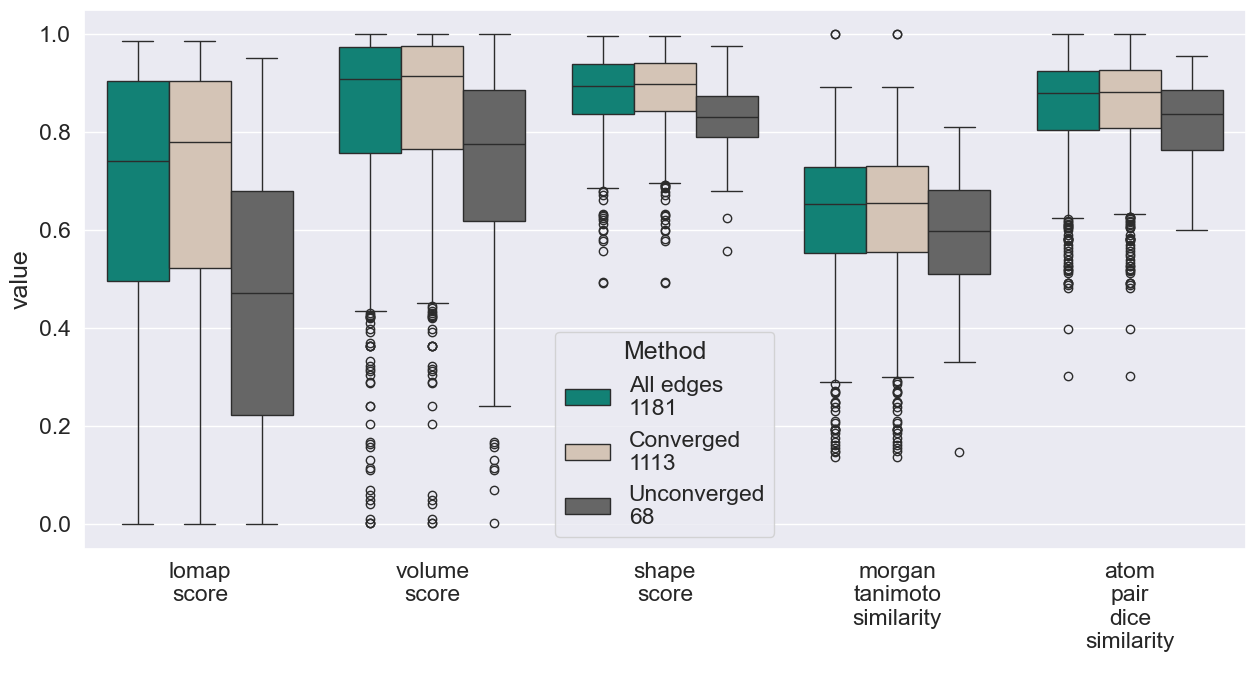

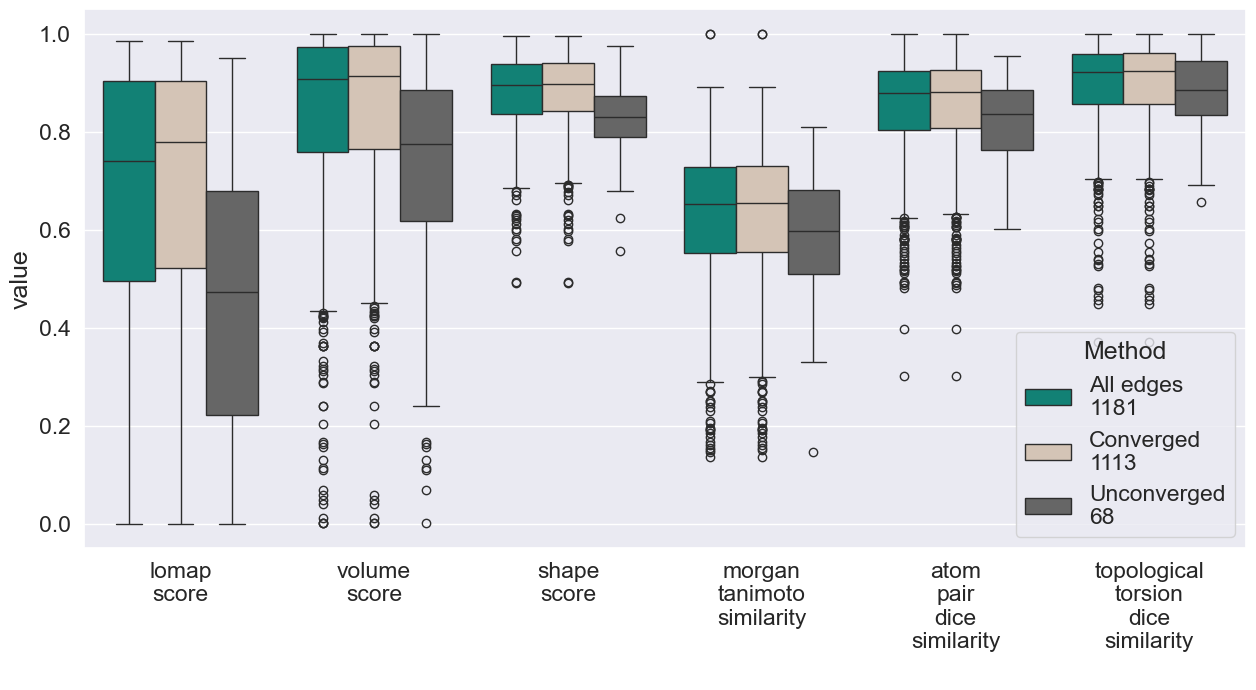

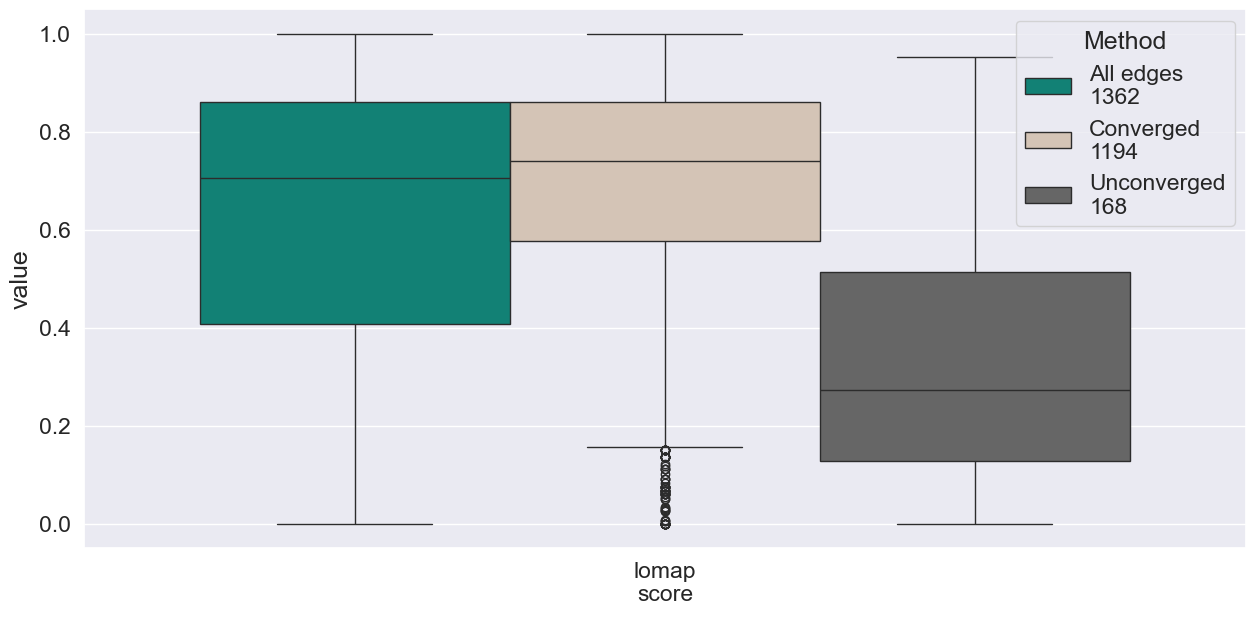

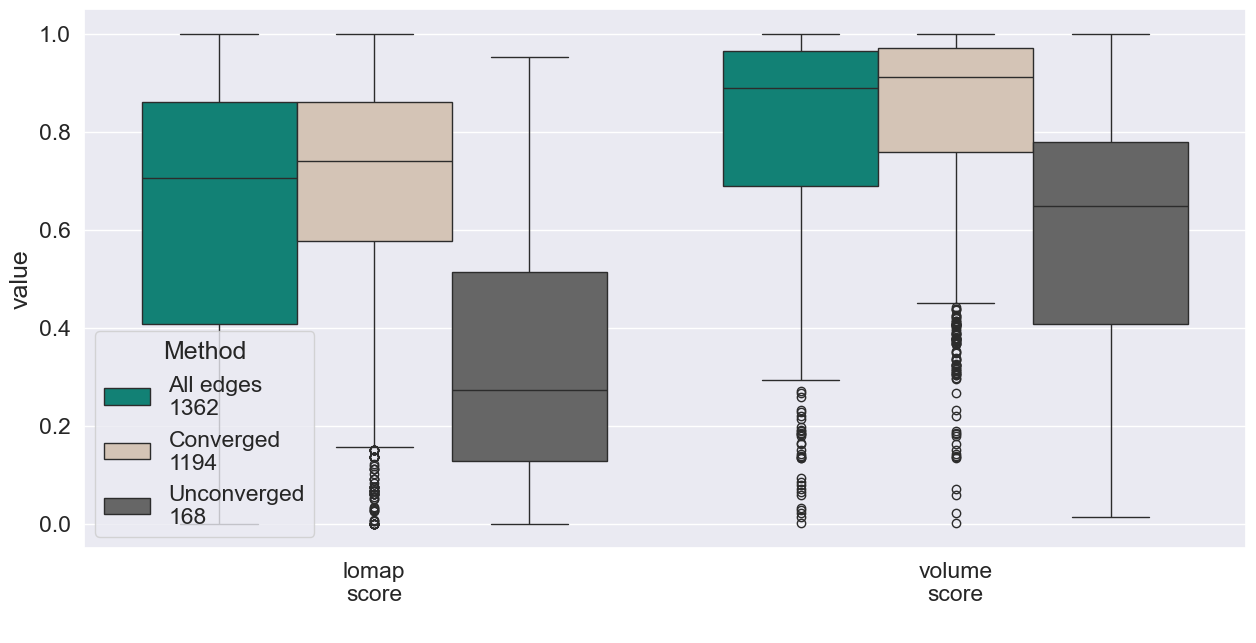

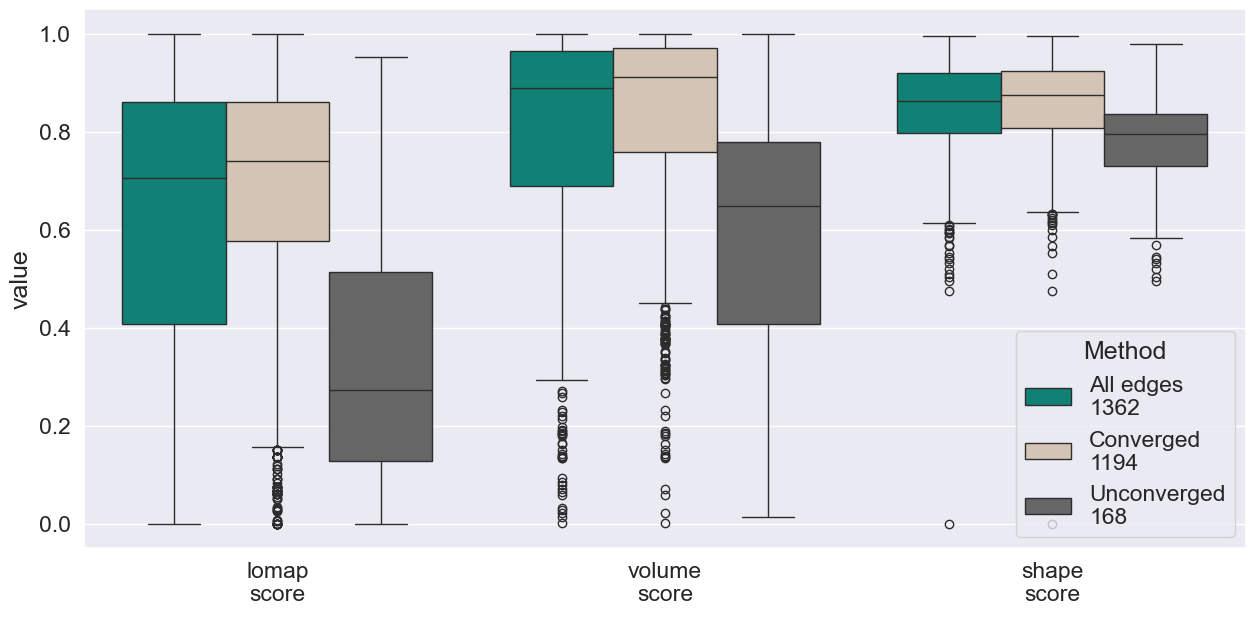

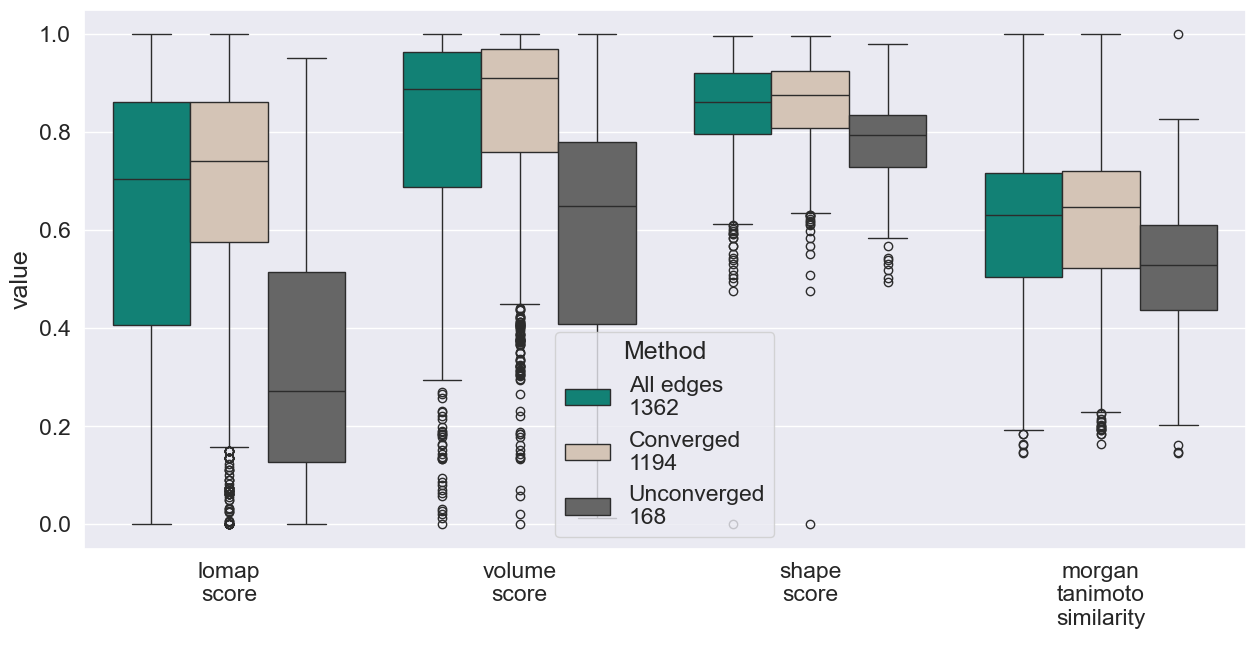

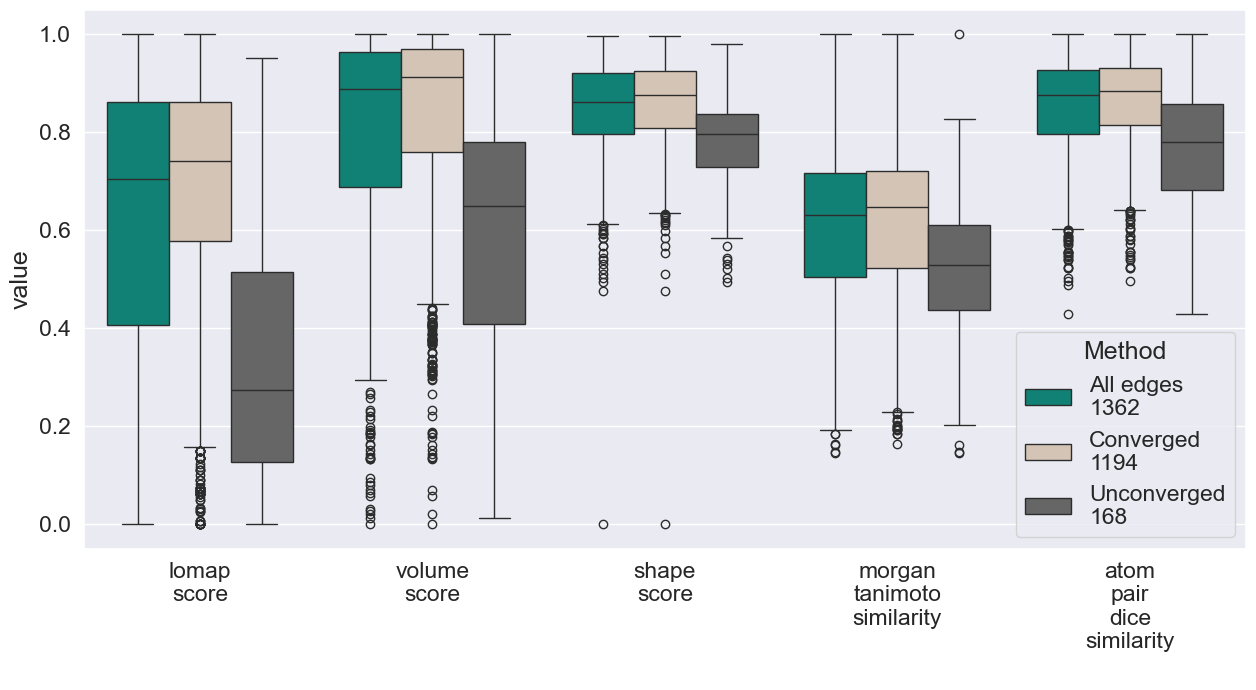

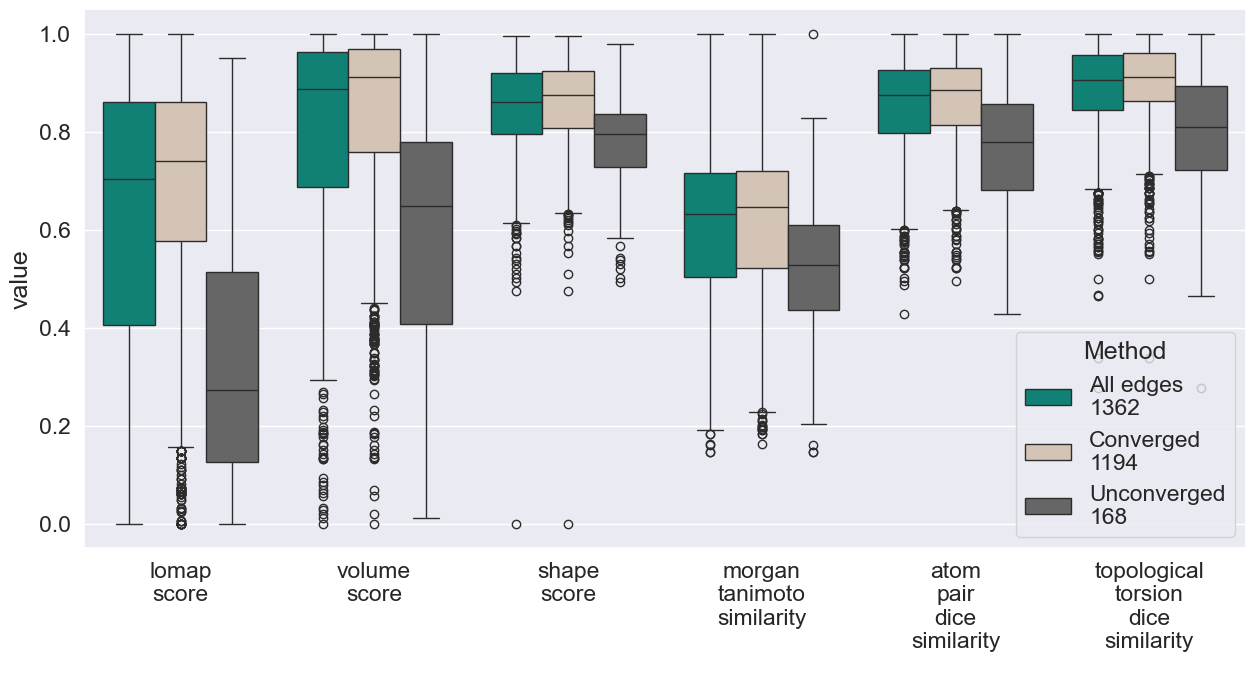

In [53]:
# Standard dev
plot_score_convergence(public_edge_data, calc_ddgs_error, threshold_std, 'score_convergence_std.png', direction='greater')
plot_score_convergence(private_edge_data, calc_ddgs_error_private, threshold_std, 'score_convergence_std_private.png', direction='greater')

In [62]:
df_scores = public_edge_data.loc[:, 'lomap_score':'topological_torsion_dice_similarity']
df_scores = df_scores.drop('alchemical_charge_difference', axis=1)
df_scores[r'$\Delta$HAC'] = df_scores['num_heavy_dummy_A'] + df_scores['num_heavy_dummy_B']
df_scores = df_scores.drop('num_heavy_dummy_A', axis=1)
df_scores = df_scores.drop('num_heavy_dummy_B', axis=1)
df_scores = df_scores.drop('num_heavy_core', axis=1)
df_scores = df_scores.drop('mapping_rmsd_score', axis=1)
df_scores = df_scores.drop('difference_num_rings_AB', axis=1)
df_scores = df_scores.drop('difference_num_rot_bonds_AB', axis=1)
df_scores = df_scores.drop('charge_score', axis=1)
# Multiply some columns by -1 such that 1 is the best score and 0 worst
df_scores[r'$\Delta$HAC'] = df_scores[r'$\Delta$HAC']*-1
df_scores['difference_solvent_accessible_surface_area'] = df_scores['difference_solvent_accessible_surface_area']*-1

In [63]:
scores = ["lomap_score", "volume_score", "shape_score", "morgan_tanimoto_similarity", r"$\Delta$HAC" + '\n\n\n',
          "difference_solvent_accessible_surface_area", "atom_pair_dice_similarity", "topological_torsion_dice_similarity",
          "difference_num_rings_AB", "difference_num_rot_bonds_AB"]
scores_dict = {}
for s in scores:
    scores_dict[s] = s.replace("_", "\n")

In [64]:
df_scores = df_scores.rename(columns=scores_dict)

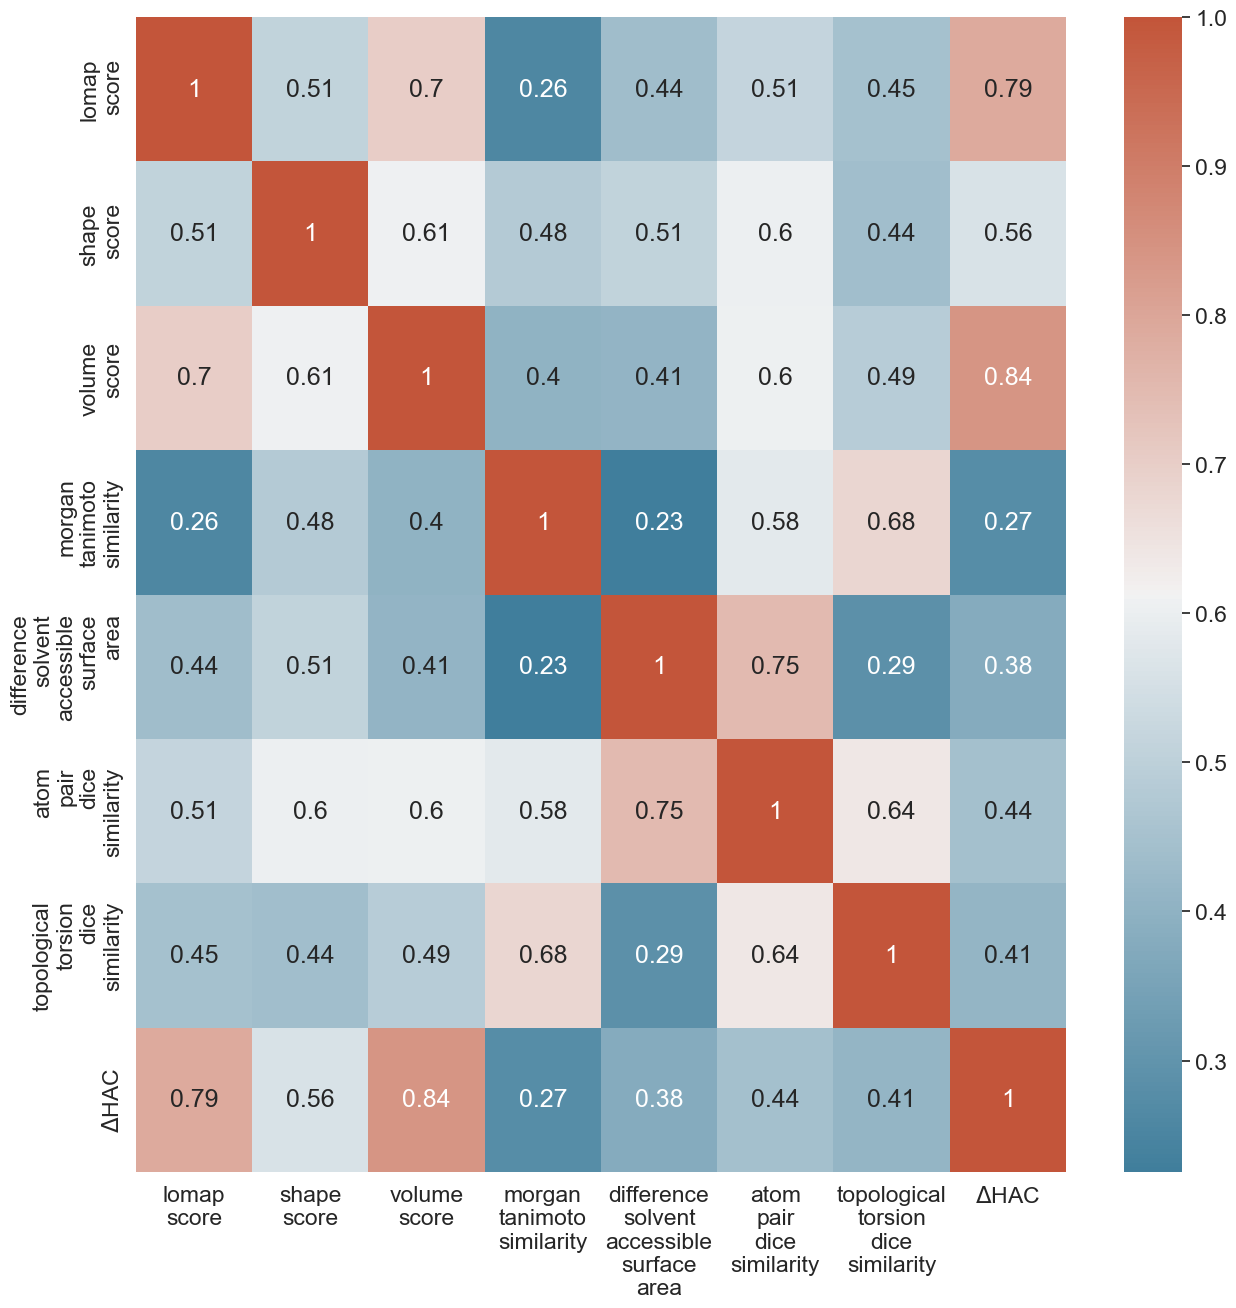

In [65]:
# Get heatmap of scores
corr = df_scores.corr()
f, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)
plt.savefig('heat_map_scores.png', bbox_inches='tight')